Importing Libraries and Data Cleaning

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import Trainer, TrainingArguments
from transformers import TrainerCallback

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df_train = pd.read_csv('/content/drive/My Drive/cnn_dailymail/train.csv')

In [ ]:
# df_test = pd.read_csv('/content/drive/My Drive/cnn_dailymail/test.csv')

In [ ]:
#df_val = pd.read_csv('/content/drive/My Drive/cnn_dailymail/validation.csv')

In [ ]:
# df_train.drop(columns=["id"], inplace=True )
# df_train.rename(columns={"highlights":"summary"},inplace=True)

# df_val.drop(columns=["id"], inplace=True )
# df_val.rename(columns={"highlights":"summary"},inplace=True)

# df_test.drop(columns=["id"], inplace=True )
# df_test.rename(columns={"highlights":"summary"},inplace=True)

In [ ]:
# df_train.head()

,article,summary
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
# df_train_compressed = df_train.sample(frac=0.1, random_state=42)

# # Save the sampled data to a new CSV file
# df_train_compressed.to_csv("train_data_compressed.csv", index=False)


In [ ]:
# df_test_compressed = df_test.sample(frac=0.1, random_state=42)

# # Save the sampled data to a new CSV file
# df_test_compressed.to_csv("test_data_compressed.csv", index=False)


In [ ]:
# df_val_compressed = df_val.sample(frac=0.1, random_state=42)

# # Save the sampled data to a new CSV file
# df_val_compressed.to_csv("val_data_compressed.csv", index=False)


In [ ]:
df_train_compressed = pd.read_csv('/content/drive/My Drive/train_data_compressed_10_percent.csv')
df_test_compressed = pd.read_csv('/content/drive/My Drive/test_data_compressed_10_percent.csv')
df_val_compressed = pd.read_csv('/content/drive/My Drive/val_data_compressed.csv')


In [ ]:
df_val_compressed.drop(['id'],axis=1,inplace=True)
df_val_compressed.rename(columns={"highlights":"summary"},inplace=True)
df_val_compressed

,article,summary
0,A bird that was long thought to have gone exti...,"Was last spotted in Burma in 1941,and was thou..."
1,A Sydney pastor has spoken about the incredibl...,Pastor Mal Feebrey discovered he had terminal ...
2,Everton boss Roberto Martinez feels the poor c...,Everton take on Dynamo Kiev in the Europa Leag...
3,The so-called ‘health tourism gap’ between the...,Hospitals still failing to claw back the cost ...
4,North Carolina State University disbanded a fr...,North Carolina State University has disbanded ...
...,...,...
1332,A little boy born with a rare brain disease th...,Tate Burley was born with Miller Dieker Lissen...
1333,Tony Abbott has pleaded with Labor to back leg...,Tony Abbott has pleaded with Labor to back a n...
1334,Milos Raonic gatecrashed a party seemingly res...,Milos Raonic beat Rafael Nadal 4-6 7-6 (12/10)...
1335,(CNN)Vin Diesel has been paying tribute to his...,Diesel named his daughter Pauline after Walker...


In [ ]:
df_test_compressed

,article,summary
0,Comedian Jenny Eclair travelled with her other...,The comedian stayed with Flavours who offer a ...
1,A woman of Arab and Jewish descent who was str...,The federal government will give Shoshana Hebs...
2,World No 1 Novak Djokovic has apologised to th...,Novak Djokovic beat Andy Murray 7-6 4-6 6-0 in...
3,(CNN)ISIS on Wednesday released more than 200 ...,Most of those released were women and children...
4,Hillary Clinton’s security detail arrived at a...,"Second modified, armored van spotted near Des ..."
...,...,...
1144,Huddersfield coach Paul Anderson is hoping to ...,Huddersfield have plummeted to ninth in Super ...
1145,Club Tijuana star Juan Arango conjured memorie...,Juan Arango escaped punishment from the refere...
1146,The first ever drawing of The Beatles' famous ...,First drawing of Yellow Submarine to fetch mor...
1147,South Sydney hooker Issac Luke is at the centr...,Souths hooker Issac Luke has become embroiled ...


T5 Model (without fine tuning)

In [ ]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('T5-base')
model = AutoModelWithLMHead.from_pretrained('T5-base', return_dict=True)

# Assuming your DataFrame is named 'df' and the column containing articles is 'article_column'

# Create an empty DataFrame to store the summaries
df_test_pred = pd.DataFrame(columns=['Summary'])
i=0
# Iterate through each row in the DataFrame
for index, row in df_test_compressed.iterrows():
    # Get the article from the specified column
    article = row['article']

    # Tokenize and generate summary
    inputs = tokenizer.encode("summarize: " + article, return_tensors='pt', max_length=512, truncation=True)
    output = model.generate(inputs, min_length=80, max_length=100)
    summary = tokenizer.decode(output[0])

    # Append the original article and summary to the new DataFrame
    df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)
    i+=1
    print(i,summary)

# Display or save the resulting DataFrame
print(df_test_pred)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1509: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


1 <pad> 'activity holidays' can range from Pilates to kayaking, or painting to pottery. a trip to Venice provided inspiration for budding artists. a trip to london in the summer provided inspiration for the budding artists. a trip to london in the summer provided inspiration for the budding artists. a trip to london in the summer provided inspiration for the budding artists.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


2 <pad> the federal government will give Shoshana Hebshi $40,000 as compensation for being humiliated on the 10th anniversary of 9/11. armed agents forced her from a plane at Detroit Metropolitan airport, made her undress during a search and held her for hours. Hebshi, who has a Jewish mother and Saudi Arabian father, has said she was ethnically profiled based on her dark complexion.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


3 <pad> world no 1 apologised to ball boy after he was caught in a tirade. the incident happened during the final of the Miami open on sunday. the world no 1 grabbed a towel from the startled youngster. he said he'sincerely hopes he forgives me' and'regrets' the incident.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


4 <pad> most of those released were women and children; the rest were ill or elderly. it wasn't immediately clear what motivated the release. the majority of the freed Yazidis were women and children. they were sent to the Kurdish regional capital, Irbil. a commander in the peshmerga force says arab tribal leaders helped coordinate the release.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


5 <pad> the two vehicles are mechanically identical and have raised roofs, deep-tinted windows and new york license plates. the original van, nicknamed 'Scooby' after the cartoon show, sports a mustard-yellow tag. the second has blue and white plates of a different design. both armored vehicles have raised roofs, deep-tinted windows and new york license plates.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


6 <pad> Tim Swiel will return to Harlequins on a full-time contract. the 21-year-old spent four months on loan with the sharks earlier this season. he made 10 appearances during his loan spell, featuring in the european champions cup, Aviva Premiership and LV= Cup. click here for all the latest rugby news.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


7 <pad> channel 10 show the project accidentally used footage of the wrong comic. they were promoting upcoming guest on the show, upcoming comedian Michael Che. but two of the clips shown were of the comic's castmate, Jay Pharoah. presenter Waleed Aly apologised for the embarrassing blunder. he said 'we stuffed up' after viewers pointed out the mistake.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


8 <pad> aston villa beat liverpool 2-1 in the semi-finals of the fa cup at wembley. the result means that the midfielder's final game would have been his final before he leaves for the los angeles galaxy in the summer. here, sportsmail looks at the midfielder's performance at wembley.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


9 <pad> singer has written a public letter to the just group imploring them to stop using angora wool. the retailer has so far refused to back down on their stance in using the fur. angora wool is used in a number of clothing lines including just jeans, portmans, dotti, Peter Alexander, jacquie e, and jay yays.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


10 <pad> the music video was released on the boxer's facebook page on monday. it includes a montage of Pacquiao's fights and humanitarian efforts. the tune translates as 'I will fight for the fillipino'. the 36-year-old also unveiled the mouth guard he will wear during his $300m mega-fight with mayweather.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


11 <pad> millie marotta, 36, is giving colouring books an adult twist with her sellout volume Animal Kingdom. the black and white book is made up of detailed line illustrations of animals, plants and birds. the book has sold 500,000 copies worldwide and been translated into 19 different languages. the former art teacher took eight months to complete the illustrations in their entirety.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


12 <pad> french photographer and illustrator, Thomas Lamadieu, takes snaps of the sky in courtyards and built-up areas. the space in between then acts as a canvas for his playful illustrations which he has dubbed'sky art'. he has visited Belgium, Germany, Canada, the united states and south Korea in the past year alone. 'the bearded man in my images stands for the sky itself, the big man in the


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


13 <pad> real madrid are desperate to nab manchester united goalkeeper David De Gea. but they are prepared to wait until next summer if they don't negotiate. the spanish paper calls the move 'operation de gea'. 'iker casillas' has been seen as unreliable by real's fans.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


14 <pad> the 20-year-old has struggled to repeat impressive form he showed for the reds last season. he has managed just six goals this season - one less than Stoke frontman Jon Walters. despite being one of the club's star men, he has struggled to repeat the impressive form he showed for the club last season. he has been offered a £100,000-a-week deal to stay at the club.


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


15 <pad> the experts say that the best way to revive a stale loaf is to run it under water. run it under the tap and keep the cut edge away from direct flow of water. then turn your oven on to a warm temperature - around 150 degrees. when you have wet your bread put it in the oven for between 6 and 13 minutes. nutritionist Luvisa Nillson says that the trick does actually work.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


16 <pad> a size 10 Samantha says she's 'fabulous' and adores her nose. she says society isn't letting us admit that we're beautiful. a study found 96% of women chose the 'average' option. 'it's self-protection', says the author. 'it's the very same members of society that won't let us admit that we're beautiful'


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


17 <pad> student answered 10 questions in final of the BBC quiz show. he helped gonville and caius College, Cambridge defeat magdalen. viewers were astounded by his general knowledge prowess. but he admits he had help from some unlikely sources. he has now been sacked from the university of london.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


18 <pad> couple, who have 11 children, plan to renew their wedding vows in Las Vegas. they will stay at the circus circus hotel and will be whisked away in a limousine. they will also go on a helicopter tour across the desert, it is reported. the couple, who have only just got back together, are planning the trip. they hit headlines last year after demanding bigger council house for their huge brood.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


19 <pad> england striker scored his 30th goal of the season against Newcastle. he became the first Spurs player since Gary Lineker to reach the 30-mark. 'he deserves this moment because he has worked a lot,' says Mauricio pochettino. 'i think our performance was better than Newcastle's,' says pochettino.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


20 <pad> a video shows a tow company employee belittling and berating a teen. adam holmes: the video was a ploy to show a mean girl who never left high school. holmes: we should have known better than to have used such words. holmes: we should have been more careful with what we say about the video.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


21 <pad> the unidentified concert goer was photographed at the festival wearing a shirt emblazoned with the words 'eat sleep rave repeat' the shirt was a play on the fatboy slim song 'eat sleep rave repeat', which was released in 2013. the shirt was shared on twitter on sunday by jemayel Khawaja, the managing editor of vice's music and culture channel Thump.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


22 <pad> the clip was filmed on Saturday in shortandy village, 40 miles north of the capital Astana. it captures the cloud hovering in the sky for 15 minutes before suddenly vanishing without trace. locals watched the mysterious cloud hover ominously over Shortandy for a quarter of an hour before it vanished as quickly as it appeared.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


23 <pad> leSean McCoy was shipped to the Buffalo Bills in exchange for linebacker Kiko Alonso. he says the Eagles have a college feel and he doesn't like star talent. 'it was "deSean Jackson – a high-flying, take-off-the-top-of-the-defense receiver". Or "the quick, elusive LeSean McCoy",


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


24 <pad> daxing internet addiction treatment centre has so far welcomed 6,000 patients. claims to have 'cured' 75 per cent of them. wangyin, or internet addiction, affects 24 million of its 632 million internet users. many have back and eyesight problems due to 14 hours a day staring at screens. wangyin is a form of mental illness, 90 per cent of patients are clinically depressed.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


25 <pad> shelley dufresne, 32, was arrested in September after a student at destrehan high school in louisiana started bragging that he was sleeping with two teachers. investigation later revealed that the unidentified teen had sex with both his current teacher at the time, dufresne, and his teacher from the prior year, 24-year-old Rachel Respess. the married mother-of-three


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


26 <pad> professor John Warren discovered avocado trees switch from male to female in a matter of hours. the plants flower with their 'female parts' ready to be pollinated by bees. the flowers close for the night and then the next morning they reopen. but now they use their'male anthers' to spread their pollen.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


27 <pad> inverness beat Celtic 2-0 in their Scottish Cup semi-final. a penalty and red card could have been a turning point. but inverness boss says it was a handball and a red card. he says he knows he would have felt aggrieved. 'it's typical of Inverness that we don't do anything easy,' he says.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


28 <pad> 'as a teenager I used to get into fights because of it,' says Stuart McCall. 'they had a song for Ray Hankin and it went: 'Ray Hankin, Ray Hankin' and half of them would then shout's**t' and this is while he was warming up for the game'. 'tell me, how's that going to help any individual when that reaction to their name


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


29 <pad> two australian drug smugglers are waiting to learn whether they will be put to death. they are part of the so-called "Bali Nine," a drug smuggling operation. the group was arrested after police received a tip from australian federal police. the seven others are serving lengthy prison sentences for trafficking the drugs. a court rejected a last ditch effort to gain clemency from president widod


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


30 <pad> researchers at Northwestern university in the us found children who share iPads in class do much better in early literacy tests. shared iPad students scored around 30 points higher in a test than students who used the device on their own and non-iPad users. findings come after the general secretary of the National Association of Head Teachers said he was dubious about using technology as a teaching aid in non-IT classes.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


31 <pad> a 77-cent wage gap is overstated, says nadine dorries. she says women's wages aren't as high as men's, and women's choices aren't as good. dorries: women's pay is a big factor in determining a woman's future. she says women's pay is a big factor in determining a woman's future 


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


32 <pad> Kevin Franklin married his new wife in the italian Alps while his 80-year-old victim was forced to borrow money from his children. he siphoned off the £400,001 fortune over an eight-year period. when he was finally arrested he told police: 'i played him' 58-year-old jailed for four-and-a-half years at warwick crown court.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


33 <pad> the car manufacturer claims to have created the fuel of the future - diesel. it is made from water and carbon dioxide and is made from a form of crude oil. this is called 'blue crude' and is then refined into diesel. it can be mixed with diesel from fossil fuels or used as a fuel in its own right. the process can be powered using renewable energy and can be achieved with an efficiency of around 70%.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


34 <pad> Amy Wilkinson, 28, claimed housing benefit and council tax benefit. she was living in a home owned by her mother and her partner. she was ordered to pay back a total of £17,604 that she claimed over two years. her grandfather, Tommy Docherty, was manager of the club from 1972 until 1977. he was sacked over his affair with the wife of the team's physio in 1977.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


35 <pad> Floyd Mayweather takes on Manny Pacquiao in their $300 million mega-fight on may 2. the pound-for-pound no 1 believes there has never been a better boxer. he also criticised the 'rope-a-dope' tactics adopted by Muhammad Ali. 'you want to be glorified for that? Absolutely not, not me,' he said.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


36 <pad> the cushioned running tracks were designed to celebrate the 2020 Olympics. the blue path leads passengers towards departures, while the red track leads to arrivals. the new terminal will be used for many of the city's low-cost carrier departures. the aim of the tracks was, in part, to save money. the airport has also installed directional information in each lane.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


37 <pad> scottish club are second in the championship and destined for play-offs. interim manager is compiling a dossier of transfer targets for next season. he may not be at the club to parade them, but he is already looking at targets. he says he is already putting his view across to the board on who he thinks should be coming into the club and who should be here.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


38 <pad> seven bingo halls tested showed traces of cocaine, while another had traces of crack cocaine, a more dangerous form of the drug. majority of attendees are elderly, and the findings mirror a spike in drug abuse among the elderly. public health figures show 634 pensioners over 65 were treated for drug abuse last year, a rise of 20 per cent in a year.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


39 <pad> former premier made unannounced visit to the cash-strapped government last month. he met new Mongolian prime minister Chimed Saikhanbileg. but secrecy surrounding his trip stoked fears from ecologists and opposition. there is concern over plans for development of the sacred pine-covered Noyon Uul region. it has £1.2 billion gold reserves but is dotted with burial mounds of the ruler


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


40 <pad> two 15-year-old boys charged with assault and affray. one 14-year-old charged with assault occasioning actual bodily harm. the incident took place at a shopping centre in Newcastle, north of Sydney. shocking footage emerged of the moment a father and his 13-year-old daughter were bashed and robbed by a gang of 25 teenagers.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


41 <pad> the collection is priced between £14 and £85 and includes a curve-skimming dress, an intricate nightgown and silk and lace sets. it's thought that Emma started dating Ollie back in October last year, after the pair posted a candid shot of them kissing on Instagram. it's thought that Emma started dating Ollie back in October last year, after the pair posted a candid shot of them kissing on Instagram.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


42 <pad> the whole damn farm is the creation of chef Sam Longhurst. he was challenged by diners to create a burger containing three meats. the burger contains two beef burgers, homemade bacon jam and 100g of ham chunks. it also contains a whole chicken thigh, barbequed pulled pork and bacon rashers.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


43 <pad> 18 firefighters freed the white havana cob called Cody after he went for a dip. owner Tracey Hannant said her horse looked like 'black beauty' when it emerged. she said the horse was covered from head to toe and stank. the horse was taken to his stables to see a vet who gave him painkillers.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


44 <pad> thief Sofia davila, 21, would flirt with men she had contacted on facebook. she would spike their drinks and wait for them to fall unconscious. when they did, she would rob their homes and rob them of their homes. she was caught after trying to trick police that she was innocent bystander. davila has been nicknamed the 'black widow of facebook'</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


45 <pad> single mother Adriana Alvarez, 22, says she can't afford to sleep in a moldy basement in her home in a moldy suburb of chicago. she says even with assistance from food stamps, Medicaid, and a child care subsidy, she is barely getting by, despite having worked for McDonald's for five years. she is a leader with Fight For $15, an international movement to raise minimum wage laws and acquire the


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


46 <pad> the game between the Baltimore Orioles and the Chicago white sox will be closed to the public. the game is scheduled to begin at 2:05 p.m. ET. tickets from Monday's postponed game can be used for admittance on may 28. the team also announced it would move three games (may 1-3) to florida.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


47 <pad> airlines set to scrap hundreds of flights over strike by french air traffic controllers. walk-out will start at 5am tomorrow and run for 48 hours. experts fear up to half of all flights between the uk and france could be axed. flights between london and glasgow cancelled due to strike action. spokesman: 'we expect significant impact to our flights during this period'</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


48 <pad> researchers found people feel friendlier and more relaxed over a meal. they also believed the person they were with was warmer and more likeable. researchers from the university of groningen, the Netherlands, said that tricky topics might be best tackled over a meal. a fifth of the 1,000 meetings recorded took place over a meal. researchers say it is possible that chewing raises levels of the ‘feel-good’ brain chemical seroton


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


49 <pad> former spokesman for the Glazer family has written 'the Glazer Gatekeeper' book challenges perception of the unpopular owners. he lifts the lid on the family who took over the club in 2005. the family were 'completely unruffled' by the protests. the family were never serious suitors and never wanted to 'hate' them.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


50 <pad> the pair rapped 1979 classic Rapper's Delight for spoof sketch on sky. the spoof sketch is called Britain's Got Talent and is being shown on tuesday. former team-mate redknapp joined the pair halfway through the show. the pair played together at the club from 1991 to 1997. the 51-year-old also rapped in 1990 with world cup song world in motion.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


51 <pad> four out of ten people betting on the grand national make their choice purely down to the name of the horse. a surprising 60 per cent said their secret superstition was to have the same family members gathered around the tv every year. a huge 70 per cent of women simply rely on pure chance. but less than 20 per cent of those quizzed said their quirky superstitions actually produced a win.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


52 <pad> defender Ron Vlaar is out of contract at the end of the season. he has only made 12 premier league starts this season. villa boss Tim Sherwood wants him to prove his worth. sherwood has put any contract talks on hold with the defender. click here for all the latest aston villa news. read: aston villa captain vlaar is back in action.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


53 <pad> hundreds gathered in the town of Canowindra to mark the tragic death of the bride-to-be. more than a dozen hot-air balloons took to the skies as hundreds of yellow helium balloons were released. the 26-year-old was murdered and dumped in bushland six days before she was due to walk down the aisle to marry her partner of five years.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


54 <pad> Sergio Perez fears for Force India's pace this season. the Mexican driver is relying on their upgrade to come good. the team's new car is due to be unveiled at the Austrian grand prix in June. perez finished 13th in the Malaysia grand prix and 10th in the australian grand prix. click here for all the latest formula one news.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


55 <pad> Christian Fuchs is out of contract at Schalke this summer. the 29-year-old is keen on a move to the premier league. the Austria international is renowned for his set-piece ability. he was outstanding in Schalke's 4-3 champions league win over real madrid last month. west bromwich albion are keen on signing winger Neil Taylor.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


56 <pad> Jordan Speith is in prime position to win the Masters at augusta. the 21-year-old is playing alongside British contender Justin Rose. he is the man to beat for the top prize of $1.8 million at the $10 million event. if he wins, he would become the second-youngest winner in Masters history. he is five months older than Tiger Woods when he won his first major in 1997.</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


57 <pad> cuyun, 30, was riding to work in Guatemala City when he was shot dead. he was killed along with his companion, a social welfare official. a man arrested for alleged involvement in the attack later told authorities that he had come to the country specifically to kill cuyun. he said he carried out the hit on the orders of a man named 'the Naughty One'</s>


<ipython-input-11-cb777f6a8e3f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred = df_test_pred.append({'Summary': summary}, ignore_index=True)


58 <pad> a bid from premier league giants Guinness has been rejected. the PL want as much as £60m-a-season from 2016. the fa have failed to find an 'in association' FA Cup partner. a petty refusal to let pundit Thierry Henry present a trophy to a fan at his farewell on saturday doesn't mean an arsenal legend will not do the honours 


KeyboardInterrupt: ignored

In [ ]:
df_test_pred = pd.read_csv('summaries_pred.csv')
df_test_pred

,Summary
0,<pad> 'activity holidays' can range from Pilat...
1,<pad> the federal government will give Shoshan...
2,<pad> world no 1 apologised to ball boy after ...
3,<pad> most of those released were women and ch...
4,<pad> the two vehicles are mechanically identi...
...,...
569,"<pad> carrie Fisher, 58, who is reprising her ..."
570,"<pad> Jarret Stoll, 32, was arrested on suspic..."
571,<pad> 'it's horrible to look at and horrible t...
572,<pad> Sophie Wilson performed CPR on Bradley P...


In [ ]:
df_test_compressed = pd.read_csv('test_data_compressed.csv')
df_test_compressed

,article,summary
0,Comedian Jenny Eclair travelled with her other...,The comedian stayed with Flavours who offer a ...
1,A woman of Arab and Jewish descent who was str...,The federal government will give Shoshana Hebs...
2,World No 1 Novak Djokovic has apologised to th...,Novak Djokovic beat Andy Murray 7-6 4-6 6-0 in...
3,(CNN)ISIS on Wednesday released more than 200 ...,Most of those released were women and children...
4,Hillary Clinton’s security detail arrived at a...,"Second modified, armored van spotted near Des ..."
...,...,...
569,The force wasn't with everyone during the Star...,Mark and Carrie are reprising their roles as L...
570,Dancing With The Stars co-host Erin Andrews su...,Los Angeles Kings forward Jarret Stoll was arr...
571,A woman has warned of the dangers of getting a...,"Alison, 43, from Gloucestershire, had breast a..."
572,Sophie Wilson performed CPR on Bradley Wilson ...,"Schoolboy Bradley Parkes, 16, discovered hangi..."


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=bfb8ceffc9d28a59e7605a0bf813dd4901e23939232b3f6c0ff099679a7da596
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer

# Assuming df_test and df_test_pred are your DataFrames with 'summary' columns
reference_summaries = df_test_compressed['summary'].tolist()
generated_summaries = df_test_pred['Summary'].tolist()

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each pair of reference and generated summaries
rouge_scores = {
    'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
    'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
    'rougeL': {'precision': [], 'recall': [], 'fmeasure': []},
}

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)

    for metric in ['rouge1', 'rouge2', 'rougeL']:
        rouge_scores[metric]['precision'].append(scores[metric].precision)
        rouge_scores[metric]['recall'].append(scores[metric].recall)
        rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

# Calculate average ROUGE scores
average_rouge_scores = {}
for metric in ['rouge1', 'rouge2', 'rougeL']:
    average_rouge_scores[metric] = {
        'precision': sum(rouge_scores[metric]['precision']) / len(rouge_scores[metric]['precision']),
        'recall': sum(rouge_scores[metric]['recall']) / len(rouge_scores[metric]['recall']),
        'fmeasure': sum(rouge_scores[metric]['fmeasure']) / len(rouge_scores[metric]['fmeasure']),
    }

# Print or use the average ROUGE scores as needed
print("Average ROUGE Scores:")
for metric in ['rouge1', 'rouge2', 'rougeL']:
    print(f"{metric}:")
    print(f"  Precision: {average_rouge_scores[metric]['precision']:.4f}")
    print(f"  Recall: {average_rouge_scores[metric]['recall']:.4f}")
    print(f"  F-Measure: {average_rouge_scores[metric]['fmeasure']:.4f}")


Average ROUGE Scores:
rouge1:
  Precision: 0.3585
  Recall: 0.4458
  F-Measure: 0.3854
rouge2:
  Precision: 0.1531
  Recall: 0.1879
  F-Measure: 0.1635
rougeL:
  Precision: 0.2383
  Recall: 0.2985
  F-Measure: 0.2569


In [ ]:
df_train_compressed

,article,summary
0,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...
...,...,...
28706,An ax wielding teen was left crying for his mo...,Store clerk Ali Ait Mahdi said he defended him...
28707,A food supplier falsely marketed beef to Musli...,"Midamar Corp, of Cedar Rapids, Iowa, sold food..."
28708,New York (CNN) -- Diplomacy hasn't worked. San...,Hafez Nazeri and his father Shahrem play hybri...
28709,(CNN) -- Is Gail Kelly the most powerful woman...,"Meet Gail Kelly, CEO of Australia's second lar..."


In [ ]:
df_train_compressed.shape, df_val_compressed.shape, df_test_compressed.shape

((28711, 2), (1337, 2), (1149, 2))

T5 Model with fine-tuning

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Tokenize your data
train_tokenized = tokenizer(
    df_train_compressed['article'].tolist(),
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

train_labels_tokenized = tokenizer(
    df_train_compressed['summary'].tolist(),
    max_length=150,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

val_tokenized = tokenizer(
    df_val_compressed['article'].tolist(),
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

val_labels_tokenized = tokenizer(
    df_val_compressed['summary'].tolist(),
    max_length=150,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./t5_fine_tuned",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,
    evaluation_strategy="steps",  # Evaluate at every save step
    eval_steps=500,
)

# Define a custom Dataset class or use the default one if your data is in a suitable format
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "labels": self.labels[idx],
        }

# Create instances of the custom Dataset class
train_dataset = CustomDataset(train_tokenized['input_ids'], train_labels_tokenized['input_ids'])
val_dataset = CustomDataset(val_tokenized['input_ids'], val_labels_tokenized['input_ids'])

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-tune the model
trainer.train()

# Training and validation loss can be accessed from Trainer's state
for epoch in trainer.state.log_history:
    print(f"Epoch {epoch['epoch']}\tTraining Loss {epoch['loss']}\tValidation Loss {epoch['eval_loss']}")


Step,Training Loss,Validation Loss
500,0.782600,0.872769
1000,0.825200,0.864769
1500,0.797800,0.861339
2000,0.793200,0.857139
2500,0.802100,0.855268
3000,0.791400,0.852190
3500,0.791300,0.853501
4000,0.777200,0.855795
4500,0.761400,0.858908
5000,0.763100,0.854590


KeyError: ignored

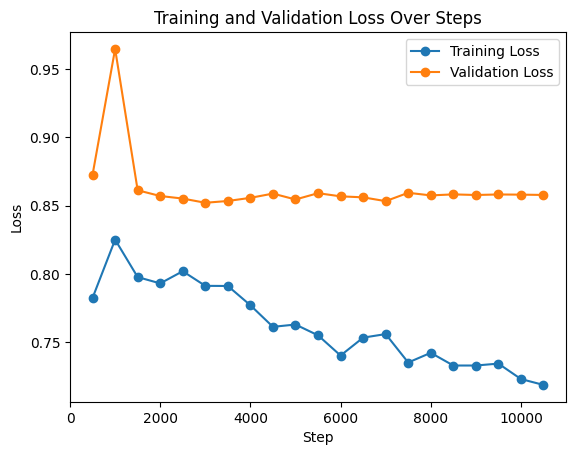

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Plotting
df.plot(x='Step', y=['Training Loss', 'Validation Loss'], marker='o')

# Adding labels and title
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Steps')

# Display the plot
plt.show()


In [ ]:
model.save_pretrained("./t5_fine_tuned_model")

In [ ]:
fine_tuned_model = T5ForConditionalGeneration.from_pretrained("./t5_fine_tuned_model",model_type='t5')

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelWithLMHead

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fine_tuned_model.to(device)

# Create an empty DataFrame to store the summaries
df_test_pred_2 = pd.DataFrame(columns=['summary'])
i=0
# Iterate through each row in the DataFrame
for index, row in df_test_compressed.iterrows():
    # Get the article from the specified column
    article = row['article']

    # Tokenize and generate summary
    inputs = tokenizer.encode("summarize: " + article, return_tensors='pt', max_length=512, truncation=True)
    inputs = inputs.to(device)
    output = fine_tuned_model.generate(inputs, min_length=80, max_length=150)
    summary = tokenizer.decode(output[0])

    # Append the original article and summary to the new DataFrame
    df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)
    i+=1
    print(i,summary)

# Display or save the resulting DataFrame
print(df_test_pred_2)

<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1 <pad> Comedian Jenny Eclair travelled with Flavours on a Painting In Venus break. She was inspired by an excursion to Venice one day. The trip was a great way to meet up with fellow artists. She says she's 'loved' the idea of a'simple' holiday. Then she travelled back to the UK to paint a painting.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


2 <pad> Shoshana Hebshi, of Sylvania, Ohio, was strip-searched at Detroit Metropolitan Airport on the 10th anniversary of the 9/11 terrorist attacks. Frontier Airlines, the Transportation Security Administration and Wayne County Airport Authority were named in the federal lawsuit. Hebshi, who has a Jewish mother and Saudi Arabian father, has said she was ethnically profiled based on her dark complexion.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


3 <pad> Novak Djokovic lost the second set of the Miami Open final. The world No 1 snatched a towel from the startled ball boy. Djokovic has since issued an apology via Facebook to the boy's parents. The world No 1 said he sincerely hopes he forgives him. The youngster was a 'ball boy' and 'didn't look good' during the rant.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


4 <pad> ISIS releases more than 200 Yazidis, a minority group whose members were killed, captured and displaced. Most of those released were women and children; the rest were ill or elderly, a commander says. It wasn't immediately clear what motivated Wednesday's release. The Yazidis are of Kurdish descent and their religion is considered a pre-Islamic sect.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


5 <pad> Hillary Clinton's security detail arrived at Capitol Fruit Company in Des Moines, Iowa on Tuesday with a visually identical GMC van. Both armored vehicles have raised roofs, deep-tinted windows and New York license plates. The original van – nicknamed 'Scooby' after the Scooby-Doo cartoon show – sports a mustard-yellow New York tag. The second has blue and white plates of a different design.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


6 <pad> Tim Swiel will return to Harlequins on a full-time contract. Fly-half spent four months on loan with the Sharks earlier this term. Swiel made 10 appearances during his loan spell, featuring in the European Champions Cup, Aviva Premiership and LV= Cup. Swiel made 10 appearances during his loan spell.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


7 <pad> The Project were promoting upcoming guest on the show, Michael Che. They accidentally used footage of another comic, Jay Pharoah. The clip was of Che's castmate and Pharoah was of Pharoah. The Project apologised for the embarrassing blunder. The clip was retweeted by more than 144,000 followers on Twitter.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


8 <pad> Steven Gerrard was deployed in a number of different roles by Brendan Rodgers. Liverpool lost 2-1 to Aston Villa in the FA Cup semi-final at Wembley. Gerrard scored a late winner but was unable to influence the outcome. The midfielder is expected to return to the Liverpool team in the summer. Gerrard is expected to return to the club in the summer.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


9 <pad> Morrissey has written a letter to The Just Group imploring them to stop using angora wool. The retailer has so far refused to back down on their stance. PETA Australia has successfully petitioned a number of Australian and international retailers to stop selling angora wool. The singer will be performing four sold-out shows at the Sydney Opera House in May.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


10 <pad> Manny Pacquiao released his own walk-out tune ahead of his $300m mega-fight. The song translates as 'I will fight for the Fillipino' and will be played. The 36-year-old also sang and directed the music video on his Facebook page. Pacquiao will face Floyd Mayweather Jnr at the MGM Grand on May 2.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


11 <pad> Millie Marotta, 36, is giving colouring books an adult twist with her sellout volume Animal Kingdom. The beautiful black and white book is made up of detailed line illustrations of animals, plants and birds. The book has sold 500,000 copies worldwide and been translated into 19 different languages. The former art teacher says her illustrations are a labour of love and people find them quite interesting.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


12 <pad> French photographer and illustrator Thomas Lamadieu takes snaps of the sky in courtyards and built-up areas. Space in between acts as a canvas for his playful illustrations which he has dubbed'sky art' He has visited Belgium, Germany, Canada, the United States and South Korea in the past year alone. The artist has made a name for himself among critics, art lovers and journalists all around the world.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


13 <pad> Real Madrid are desperate to sign Manchester United goalkeeper David De Gea. The European champions are prepared to wait until next summer to sign him. They are also looking at the possibility of signing Chelsea's Petr Cech. Lionel Messi's injury is still causing him problems ahead of Celta Vigo. There are reports that Palermo striker Paulo Dybala is set to return from injury.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


14 <pad> Sterling has struggled to repeat the impressive form he showed for Liverpool last season. The England international has managed just six goals this season. The 20-year-old has been offered a £100,000-a-week deal to stay at Liverpool. Sterling has admitted he is not ready to sign a new contract at the club. The wideman has admitted he would have signed for a lot less a year ago.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


15 <pad> Bon Apetit have revealed that the best way to revive a stale loaf is to run it under water before baking it in the oven. Nutritionist Luvisa Nillson says that the water trick does actually work, but you must make sure to eat it that same day. The trick works because the water turns to steam, which rehydrates the bread’s crumb, or interior, while the heat of the oven firm up the crust.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


16 <pad> Samantha says she thinks she's 'fabulous' and 'perfectly aware' of flaws. She says society doesn't let us admit that we're beautiful. She says it's the very same members of society who don't. Dove's latest campaign found 96% of women chose the 'average' option.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


17 <pad> Ted Loveday helped Cambridge students defeat Magdalen College, Oxford. The law student has become an online sensation after his team's triumph. The final of the BBC quiz show was broadcast on Monday night. The students thrashed their opponents by 225 points. Mr Loveday has admitted he had help from some unlikely sources. He has now admitted he revised the programme for the show.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


18 <pad> Cheryl Prudham, 33, and her partner Robert, 30, are planning a two-week 'no expense spared' break. They are planning to renew their wedding vows at the Chapel of Love in Las Vegas. The couple, who have only just got back together, claim £39,192 in benefits. They hit headlines last year after demanding bigger council house for their huge brood.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


19 <pad> Harry Kane scored his 30th goal of the season as Tottenham beat Newcastle 3-1. The striker scored in time added on to his first goal of the season. Mauricio Pochettino believes Kane can improve further. The Tottenham boss said: 'He has big potential. He is young' Kane scored a late winner to put Spurs ahead at St James' Park.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


20 <pad> Britt McHenry was filmed berating an employee of a tow company. Alicia Navarrette: It's troubling how quickly the rest of us issued blame on McHenry. She says she should have known better than to have used such words. Navarrette: We should be thankful that we're not blaming McHenry for her actions.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


21 <pad> The unidentified male concert goer was photographed at Coachella wearing a T-shirt emblazoned with the words 'Eat Sleep Rape Repeat' The photo was shared on Twitter on Sunday by Jemayel Khawaja, the managing editor of Vice's music and culture channel Thump. The shirt was a play on Fatboy Slim's Eat Sleep Rave Repeat, which was released in 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


22 <pad> The clip was filmed on Saturday in Shortandy village, 40 miles north of the capital Astana. It captures the cloud hovering in the sky for 15 minutes before suddenly vanishing. Video has been viewed more than 50,000 times since being uploaded to YouTube. Many locals believe it is definitive proof of extra-terrestrial life. Others believe it was likely to be a naturally occurring weather event known as a thermal microburst.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


23 <pad> LeSean McCoy was shipped to the Bills in exchange for linebacker Kiko Alonso. McCoy says Kelly's team has a college feel and he doesn't like star talent. The Buffalo Bills running back says Kelly's team has a 'college feel' McCoy ran for 1,000 yards in four of six seasons with the Eagles.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


24 <pad> Daxing Internet Addiction Treatment Centre has welcomed 6,000 patients. It claims to have 'cured' 75 per cent of the 6,000 mostly young, mostly male patients. The centre is regarded as China's leading expert in wangyin, or internet addiction. It is said to affect 24 million of its 632 million internet users. Many have back and eyesight problems due to 14 hours a day staring at screens.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


25 <pad> Shelley Dufresne, 32, was arrested in September after a 16-year-old student started bragging to friends that he had slept with two teachers. An investigation later revealed that the unidentified teen had sex with both his current English teacher at the time, Dufresne, and his English teacher from the prior year, Rachel Respess. Dufresne changed her plea deal and confessed to the sordid act in court Thursday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


26 <pad> Professor John Warren discovered avocado trees switch from male to female. The trees flower with their 'female parts' ready to be pollinated by bees. The flowers close for the night and then the next morning they reopen. Now they use their'male anthers' to spread their pollen, he said. Professor Warren, from Aberystwyth, Wales, said the plants limited the amount of self-pollination.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


27 <pad> Inverness beat Celtic 2-0 in their Scottish Cup semi-final. Josh Meekings appeared to get away with a handball on the line. Craig Gordon was sent off for a spot kick. John Hughes says it was a turning point in the game. Caley boss says Celtic will go on to win the Scottish Cup. Hughes says he will be happy to see Celtic back in the game.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


28 <pad> Stuart McCall has had to get used to his players being booed by supporters. Rangers skipper Lee McCulloch was booed for an error against Raith Rovers. McCall hopes McCulloch will be the last player to be booed by supporters. McCall is an unknown at the club. The manager has been adamant that he will not be booed by supporters.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


29 <pad> Two Australian drug smugglers are waiting to learn whether they will be put to death by firing squad. April marks a decade on death row for Andrew Chan and Myuran Sukumaran. The seven others who took part in the operation are serving lengthy prison sentences. The so-called "Bali Nine" were arrested after Indonesian police received a tip from Australian Federal Police.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


30 <pad> Researchers at Northwestern University in the US found that, in tests, kindergarten children who shared iPads significantly outscored their peers. Shared iPad students scored around 30 points higher than students who used the device on their own and non-iPad users. Findings come after the general secretary of the National Association of Head Teachers said he was dubious about using technology as a teaching aid in non-IT classes.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


31 <pad> Judith Grass: Equal Pay Day is a holiday marked by progressive women's groups. She says the 77-cent wage gap statistic is grossly overstated. Grass: Republicans should pay attention to Equal Pay Day. Grass: Women should be able to work to make up for lost wages. Grass: Women should be able to work to make up for lost wages.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


32 <pad> Kevin Franklin married his new wife in the Italian Alps while his 80-year-old victim was forced to borrow money from his children. The 58-year-old siphoned off the £400,001 fortune over an eight-year period. When he was finally arrested he told police: 'I played him' He was jailed for four-and-a-half years at Warwick Crown Court.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


33 <pad> Audi claims to have created the fuel of the future - diesel made from water and carbon dioxide. Experts used renewable energy to convert the carbon dioxide and water into a form of crude oil known as 'blue crude' This was then refined into diesel. Tests have shown it can be mixed with diesel from fossil fuels. The new e-diesel has already been used to power the official car of German minister of education and research Dr Johanna Wanka.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


34 <pad> Amy Wilkinson, 28, claimed housing benefit and council tax benefit. She was living in a home owned by her mother and her partner. She was ordered to pay back a total of £17,604 that she claimed over two years. Wilkinson was a British Airways cabin crew attendant. Her grandfather, Tommy Docherty, was manager of Manchester United.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


35 <pad> Floyd Mayweather believes there has never been a better boxer in history. Mayweather takes on Manny Pacquiao in their $300 million mega-fight on May 2. Mayweather also criticised Ali's famous 'rope-a-dope' tactics against George Foreman. The former heavyweight champion says he will respect the two fighters.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


36 <pad> Terminal 3 has been designed to celebrate the 2020 Olympics. Running tracks are also installed in the hallways to help passengers navigate. Blue path leads passengers to departures, while arrivals to arrivals. Terminal will be used for low-cost carrier departures and arrivals. The track was installed to save money. The new terminal was opened on April 8. The new track will be used for many of Tokyo's low-cost carriers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


37 <pad> Stuart McCall is compiling a dossier of potential new arrivals for next season. Rangers are second in the Scottish Championship table. McCall may not be in charge of the club beyond the current campaign. The interim manager is still not sure if he will be in charge. McCall is already piecing together a dossier of targets for next season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


38 <pad> Seven bingo halls tested had traces of cocaine, while another had traces of crack. The majority of attendees are elderly, and the findings mirror a spike in OAPs. Public Health England figures show 634 pensioners over 65 treated for drug abuse last year. Hospital figures show a 20 per cent rise in drug abuse among the elderly. The figures were revealed in a newspaper investigation by The Sun.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


39 <pad> Former premier made unannounced visit to Ulaanbataar last month. He met new Mongolian prime minister Chimed Saikhanbileg. But secrecy surrounding his trip stoked fears from ecologists and opposition. Concern over plans for development of sacred pine-covered Noyon Uul region. It has £1.2 billion gold reserves but is dotted with burial mounds of Attila the Hun.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


40 <pad> Tibor Racsits, 42, and his daughter Kiara, 13, were attacked on Sunday night. The incident took place at Charlestown Square in Newcastle, north of Sydney. Two 15-year-olds and one 14-year-old were charged with assault and affray. The seriousness of the incident led police to charge them as normal. The charges come after shocking footage emerged of the moment a father and his 13-year-old daughter were bashed and robbed by a gang of 25 teenagers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


41 <pad> Ann Summers has unveiled its first bridal wear collection. The range includes a curve-skimming dress and an intricate nightgown. Emma was first revealed as the face of the brand in February. She is the girlfriend of Made in Chelsea's Ollie Proudlock. The collection is priced between £14 and £85. It is thought that Emma started dating Ollie back in October last year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


42 <pad> The Whole Damn Farm is the creation of Sam Longhurst, head chef of Splendid Kitchen, Manchester. It contains two beef burgers, homemade bacon jam, 100g of ham chunks, a whole chicken thigh, barbequed pulled pork and bacon rashers. The burger costs £13.50 and contains six different forms of three different meats.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


43 <pad> Cody the Havana cob was hosed down after going for a lengthy dip. It took 18 firefighters to free the horse from the muddy ditch in Belvedere. Owner Tracey Hannant said her horse looked like Black Beauty. She praised London Fire Brigade crews who saved her boy's life. Cody was taken to his stables to see a vet who gave him painkillers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


44 <pad> Sofia Davila, 21, would flirt with men she had contacted on social network. She would spike their drinks and wait for them to fall unconscious. She then ransacked their homes after they fell unconscious. The thief has been nicknamed the 'Black Widow of Facebook' after tricking police. She is now awaiting trial after admitting tricking 15 men and robbing them.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


45 <pad> Adriana Alvarez, 22, says she can't afford to sleep in a moldy basement. She has worked for McDonald's for five years and is a leader with Fight For $15. She said her pay used to be even lower before she and fellow employees of the fast food chain began to protest. Alvarez said she would find a 'decent place to live' with good schools for her three-year-old son Manny.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


46 <pad> Orioles and White Sox game will be closed to the public. The game will be televised on the MASN regional cable network. The postponement follows the postponement of Monday's and Tuesday's games. The Orioles will still be the home team.. Ticket sales are down.. on Twitter.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


47 <pad> EasyJet and BA among airlines set to scrap hundreds of flights. The walk-out will start at 5am tomorrow and run for 48 hours. Experts fear up to half of all flights between the UK and France could be axed. The new regultion forces travel operators to check passports of passengers. The new rules force travel operators to check the passports of passengers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


48 <pad> Dutch and Canadian scientists found people feel happier and more relaxed when eating at home or at work. They also believed that the person they were with was warmer and more likeable. One possible explanation is that chewing raises levels of the ‘feel-good’ brain chemical serotonin. Researchers say it is possible that shared meals enhance our inbuilt desire to be accepted and to please others.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


49 <pad> Tehsin Nayani spent six years as spokesman for the Glazer family. The former finance PR executive has written a book on the family. The book challenges perception about the US bosses who succeeded in a debt-burdening £800m takeover in 2005. It also reveals a previously unseen human side to the Glazers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


50 <pad> John Barnes and Jamie Redknapp rapped The Sugarhill Gang classic Rapper's Delight. The pair played together at Liverpool between 1991 and 1997. Barnes appeared in a spoof sketch of Britain's Got Talent. The pair share the spotlight for the remainder of the 1979 classic. Barnes reached No 1 in the UK with England's 1990 World Cup song World in Motion by New Order.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


51 <pad> Survey reveals the secret to winning the Grand National is superstitions. Four out of ten Britons bet on the horse they have always loved to win. 70 per cent of women rely on pot luck to win the race at Aintree. Jockey Sam Twiston Davies always salutes a magpie on his way to Aintree.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


52 <pad> Ron Vlaar is out of contract at Aston Villa this summer. The Dutchman has only made 12 Premier League starts this season. Villa boss Tim Sherwood wants Vlaar to prove his worth. Sherwood has put any contract talks on hold with Vlaar. Villa travel to Old Trafford on Saturday. click here for all the latest Aston Villa news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


53 <pad> The hometown of Stephanie Scott has paid tribute to the much-loved teacher. More than a dozen hot-air balloons took to the skies in Canowindra. The balloons were released as hundreds gathered to mark the tragic death of the bride-to-be. The latest tribute comes just one week after Ms Scott was murdered and dumped in bushland six days before she was due to walk down the aisle to marry her partner of five years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


54 <pad> Sergio Perez fears for Force India's pace this season. The Mexican is relying on the team's B-spec model to come good. Perez finished 13th in Malaysia and 10th in Australia last month. The McLaren duo of Fernando Alonso and Jenson Button are also struggling. Perez is hoping to make a 'big step forward' in the new year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


55 <pad> Christian Fuchs is out of contract at Schalke this summer. Swansea are interested in signing the Schalke full back. The club are also interested in signing Neil Taylor for £4million. Fuchs has also had interest from Sunderland, Hull and Fulham. Click here for all the latest Schalke news..</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


56 <pad> Jordan Speith is in prime position to win The Masters at Augusta. The 21-year-old is playing alongside British contender Justin Rose. Spieth is the man to beat for the top prize of $1.8 million. Tiger Woods is the second-youngest winner in Masters history. Spieth could break Woods' 1997 tournament record of 18-under 270.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


57 <pad> Luis Andres Cuyun, 30, was the director of a jail for juvenile gang members in Guatemala City. He was riding to work when two suspected Mara Salvatrucha members opened fire on him and his driver. A Salvadoran man arrested for alleged involvement in the shooting later told authorities that he had come to the country specifically to kill Cuyun. Juan Carlos Medina Luna, 29, and Guatemalan Mario Alfonso Aguilar, 18, were arrested after a police chase.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


58 <pad> Premier League clubs turn down a £45m-a-year title sponsorship. Guinness offered the top flight a huge deal of £135m over three years. The league's mega-rich clubs have demanded a deal in the region of £60m a year from 2016. The FA have failed to find an 'in association' FA Cup partner prepared to pay £9m a year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


59 <pad> Roma family 'lured Czech immigrants to Britain on promise of a better life' Workers were 'treated like dogs' - being made to urinate in buckets and live outside. They were also made to give over all their wages and do housework. They were also forced to eat outside during winter and pay off 'loans' 'They would even make them shoplift', a court heard.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


60 <pad> Laura Robson has been out of action for 16 months with a wrist injury. The 21-year-old has been pictured at a country music festival in Florida. She posted a picture of her at Tortuga with two friends last weekend. Robson is now said to be nearing a return and targeting the French Open. The 21-year-old also missed out on Wimbledon last year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


61 <pad> Over-55s had same literacy and numeracy skills as those aged 16 to 24. Study found they were worse at these skills than colleagues in their 30s and 40s. Association of Accounting Technicians said death of 'job for life' meant workers could no longer rely on loyalty to company. Instead, older workers must constantly'reskill' and retrain to boost job security.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


62 <pad> Luke Shaw says Ashley Young is the biggest joker in the dressing room. Young received a surprise delivery from a bird mid-match. Shaw says the players still laugh about the time Young got bird poo in his mouth. The left back has struggled with injuries since joining Manchester United. Shaw says David de Gea is the 'nicest guy in football' and is approachable.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


63 <pad> The Sydney Observatory captured every moment of the 'blood moon' on Saturday night. The event was predicted to be one of the shortest total lunar eclipses of the century. Brisbane, Darwin, Canberra and Hobart residents were also predicted to miss out due to poor weather conditions. The event was also predicted to be one of the shortest of the century. The moon was pictured revealing itself through rain clouds towards the end of the eclipse.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


64 <pad> Kayli Henley took a photo of Smith and fitted it around his girlfriend and son, as if he were standing over them. The photo has been shared more than 200,000 times and shared more than 25,000 times. Smith died in a freak accident in July 2014. His girlfriend Sierra Sharry was eight months pregnant and left her boyfriend behind.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


65 <pad> Wanquan Castle was known as the Ming Dynasty's 'Martial City' It measures two kilometres in circumference and was protected by a 12-metre wall. Restoration work will see building work completed in original Ming Dynasty style. Work will also include ongoing protection of surviving structures. The castle is known in China as a 'living fossil of the Ming military system'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


66 <pad> Brooklyn Nets beat Portland Trail Blazers in only game on NBA schedule. Brook Lopez led the way with 32 points and nine rebounds. Deron Williams added 24 points and 10 assists for the Nets. Nets are in seventh place in the Eastern Conference standings. Damian Lillard scored 36 points for the Trail Blazers. Meyers Leonard had 17 points and 15 rebounds, while Robin Lopez had just eight points and seven boards.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


67 <pad> Cui Hongfang, 73, died after she was knocked over by the 38-year-old Canadian. Police interviewed the tourist and ruled the death an accident. Mrs Hongfang's family demanded she be prevented from leaving China. The Canadian woman offered a'sincere' apology to the family at court. She was rushed down a steep set of steps on the Mutianyu section of the Great Wall.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


68 <pad> Robert Charles Bates, 73, shot and killed Eric Courtney Harris, 44. Harris was trying to buy drugs and a gun from undercover officers. Bates accidentally pulled out his service weapon instead of the stun gun. He has been a reserve officer since 2008 and worked with the Tulsa Police Auxiliary. Harris was being restrained by one of the undercover officers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


69 <pad> An unidentified man was caught on the NBC sports channel wandering across the green at the Ko Olina resort in Oahu and plunging into a pond. Announcers couldn't help but chuckle at the course-crasher's escapades as he went into the water to retrieve a hat that had blown off in the wind and proceeded to lose his beer at the same time.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


70 <pad> Police at Miami-Dade Airport have been catching baggage handlers stealing from passenger luggage after installing a hidden camera. This as it is revealed that airline customers have reported $2.5million in lost property from 2010 to 2014. In 2013, El Al Airlines set up a hidden camera at that airport, and found workers stealing cash, jewelry, iPhones and iPads.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


71 <pad> Waitress Amanda Bailey publicly shamed the New Zealand Prime Minister for repeatedly pulling her hair while she was at work. She wrote on an online blog that she 'expected more from him' Mr Key defended his pranks as 'a bit of banter' and said he had already apologised. Owners of Rosie cafe in Auckland have spoken of their disappointment with Ms Bailey as she had never notified them of her concerns.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


72 <pad> Pastor George Hamilton, presiding over funeral, said Scott's death was'motivated by racial discrimination' Hundreds of mourners were crammed into small church in Summerville, South Carolina, today. Hamilton continued to rail against officer Michael Slager, who killed Scott last week by shooting him five times in the back. Scott's casket, draped in an American flag, was led in, accompanied by his distraught mother. Slager, who has been jailed and charged with Scott's murder, was a 'disgrace'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


73 <pad> Migrant workers producing vegetables exported to Britain denied basic hygiene facilities. Some live in filthy shacks made of wood and plastic sheeting near fields. They also say they are made to work around dangerous pesticides. They are also routinely left unpaid for hours they have worked. The revelations will horrify millions of customers of British supermarkets.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


74 <pad> Aaron Hernandez, 25, has pleaded not guilty to shooting Odin Lloyd five times. The former New England Patriots tight end was found dead in an industrial park less than a mile from Hernandez's home on June 17, 2013. Prosecutors have presented hundreds of pieces of evidence since testimony began on January 29. A joint found near Lloyd's body had DNA from both men on it. The shell of a bullet matching the one that killed Lloyd was found on the floor of Hernandez's car - stuck to a piece of gum that matched the former Patriots' DNA.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


75 <pad> Aaron Stringer, of the Bakersfield, California, Police Department, allegedly pulled on the toes and yanked on the head and toes of Ramiro James Villegas. Villegas, 22, was shot dead by police on November 13 after a car chase. Stringer has been on paid administrative leave from the department since it started investigating the accusations.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


76 <pad> Psychologists from Goldsmiths University in London and Ohio State University studied more than 13,000 twins aged nine to 16 from six countries. They found that 40 to 50 per cent of the differences in children’s motivation to learn could be explained by their genetic inheritance from their parents. The twins’ shared environment - elements such as the teachers and the family that they had in common - would be a larger factor than genetics. Genetics and non-shared-environment factors were found to have the largest effect on the children’s motivation to learn, whereas the shared environment had negligible impact.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


77 <pad> Maria Malone-Guerbaa, 41, from London, used only her brushes and kryolan paint. Mother-of-two said she didn't use any prosthetics or special effects. The final result took three hours to achieve after she simply googled pictures. She said: 'I've got #hare in my face!'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


78 <pad>The former NFL kicker is seeking $20million in lost future earnings and $15,000 in damages. He contracted the deadly infection in 2013 following a surgery on an ingrown toenail. The lawsuit alleges that the Buccaneers 'failed to disclose and actively concealed ongoing incidents of the infection among other individuals' who used team's facilities. Tynes and another player, offensive guard Carl Nicks, both contracted Methicillin-resistant Staphylococcus aureus infections during a July 2013 outbreak of the infection during the Buccaneers' summer training camp prior to the season. Nicks reached a settlement with the team last year over his infection for $3million


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


79 <pad> Uruma Takezawa spent 1,021 days on the road to capture amazing images on an odyssey that took him to 103 countries on four continents. The Japanese adventurer found inspiration in those who live off the land in harmony with the natural world. The images are part of an exhibition at New York's Foto-Care Gallery.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


80 <pad> Pekingese Marley and Mitzy disappeared from the front garden of their home. Owners Adele and Steven Worgan were not looking and snatched the animals. Now neighbours believe they have caught the suspected thief on CCTV. The pair owners are offering a £1,000 reward for information leading to their safe return. The pair have been missing for a week and have been reported to police.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


81 <pad> ISIS released video titled 'Until It Came To Them - Clear Evidence' shows militants holding two groups captive in south and west of country. At least 16 men are lined up and shot in desert area before being beheaded. Another 12 are filmed being forced to walk down beach before being beheaded. This raises fears ISIS is consolidating presence on 'doorstep of Europe'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


82 <pad> Geoffrey Kondogbia is a target for Liverpool and Arsenal in recent years. The 22-year-old has made over 100 league appearances for Monaco, Sevilla and Lens. Kondogbia scored the first goal in Monaco's Champions League win against Arsenal in the first leg of the last-16 first leg. The Frenchman has also impressed at the FIFA Under-20 World Cup in 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


83 <pad> Asmir Begovic has been linked with a move to Real Madrid this summer. Stoke boss Mark Hughes has dismissed the latest reports linking the Bosnia international with a move away from the Britannia Stadium. Hughes also hopes to sign teenage winger Moha El Ouriachi from Barcelona. The Potters host Southampton at the Britannia Stadium on Saturday. click here for all the latest transfer news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


84 <pad> Campaign chiefs attempted to rebuff letter criticising party by publishing message. They called for Labour government signed by people 'from all walks of life' But within hours plan was in chaos as it was found signatories included a benefit fraudster, trade unionists and cigar-smoking children of millionaires. Woman moved to Britain after having a'marriage of convenience' in Nigeria in 2007. She claimed £27,888 tax credits in two and a half years as a single person.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


85 <pad> Employment minister was branded'murderer McVey' in graffiti. She also had an election song written about her by rivals claiming she was going to hell. Miss McVey won her seat in 2010 with a majority of just 2,436. She said attacks showed what Labour really thinks of women. She said: 'If they think by coming in the dead of the night and scribbling on a wall they will intimidate and bully me they are picking on the wrong person'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


86 <pad> Orlando City have gone three games without a win in their last five games. The former AC Milan midfielder has been posting pictures of himself working out. Kaka posted the picture on Instagram. The Brazilian has not scored since scoring in the first game of the season. Orlando travel to Portland Timbers on Sunday. Click here for all the latest Orlando City news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


87 <pad> Elizabeth Stewart, Cristina Elrich and Jeanann Williams all feature in the list. They have been voted the top stylists for 2015 by Hollywood Reporter. They have also been voted the best stylists for red carpets. The list includes the stylists behind Cate Blanchett and Isabel Lucas. The list also includes the stylists behind Sandra Bullock and Julia Roberts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


88 <pad> Joanne Bolton was repeatedly knifed in the head by her violent boyfriend. The 35-year-old was held captive in her own home during the seven hour ordeal. She thought she was going to die and begged him to put her to bed. Young was jailed for 18 years at Newcastle Crown Court. He admitted attempted murder and was jailed for 18 years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


89 <pad> Marcelo Bosch kicked 55-metre penalty as Saracens beat Racing Metro 12-11. Saracens will face Clermont in the Champions Cup semi-finals in two weeks. Bosch's side have won three of their last four matches. The 31-year-old has been a regular at the Stade Yves-Du-Manoir.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


90 <pad> The brolly-clad thieves targeted supermarkets, convenience stores and electrical shops. They also stole £2,000 worth of cigarettes and cars valued at £30,000 in the process. The gang have now been jailed for more than 27 years after pleading guilty to conspiracy to rob. They were caught following a raid on an Asda supermarket in Coseley, West Midlands.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


91 <pad> Apple released a new lineup of emojis on Thursday. The emojis are now available in a range of skin tones. The new emojis are a recognition that their own ethnicity, sexual orientation, race or hair color is part of mainstream America. The new emojis will also include a new gay and lesbian couple.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


92 <pad> Manchester City fans haven't fully bought into the idea that City could be one of the giants of Europe. Ricky Hatton wants 'the old City back', while Noel Gallagher says there is 'apathy' towards the Champions League among the fans. City need to fill up the half-empty dressing room. Pellegrini is punching above his weight at Manchester City.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


93 <pad> Chelsy Davy wore ripped jeans and a chic blazer on Wednesday night. The 29-year-old looked in high spirits as she laughed with friends in Mayfair. She was seen laughing and joking with friend Irene Forte at the launch party. Davy is currently single after splitting up with society jeweller Charles Goode.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


94 <pad> Pedro Hernandez confessed in 2012 in a case that has confounded law enforcement for decades. His name appears only once in law enforcement paperwork at the time Etan disappeared. The defense says the admissions are made up, the ravings of a mentally ill man who sees visions and has a low IQ. Hernandez confessed in 2012 in a case that has confounded law enforcement for decades.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


95 <pad> Her Majesty was joined by the Duke of Edinburgh at a reception in Trafalgar Square. During the commemorations, the monarch posed for a photograph with The Calgary Highlanders. Prince Philip sat for a portrait with The Royal Hamilton Light Infantry. Several descendants of those of who fought in battle and current service personnel also attended the reception.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


96 <pad> Novak Djokovic beats Thomas Berdych 7-5, 4-6, 6-3 in the Monte Carlo Masters final. Djokovic is the first man to win the opening three Masters tournaments of 2015. The Serbian has won the Australian Open and Miami. He has now won 17 matches in 2015.....and he is looking forward to a return to the top of the world rankings.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


97 <pad> Arthur Baldwin, 29, is assigned to the Foreign Missions Branch. He is charged with first-degree attempted burglary, a felony, and one misdemeanor. His security clearance has been suspended, the Secret Service says. The incident comes as the Secret Service is trying to mend its reputation. Several issues concerning the discipline and professionalism of its officers have come to light recently.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


98 <pad> ISIS entered Yarmouk camp as Jordan closed its only functioning border. They reportedly entered the camp from Hajar Aswad in southern Damascus. It is a coordinated attack with their rivals in the Al Qaeda-affiliated Nusra Front. If ISIS manage to gain full control of Yarmouk, they could use it as a base.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


99 <pad> Alan Smith suffered a broken leg and dislocated ankle in 2006 FA Cup defeat. The Liverpool striker was travelling to hospital in an ambulance. Reports circulated that Liverpool fans threw bottles, beer glasses and stones at the ambulance as well as rocking the vehicle. Smith insists that it didn't happen – fans were still in the ground.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


100 <pad> 500ft-long Oryol caught fire at shipyard in Severodvinsk, 620 miles north of Moscow. Defence sources said weapons and critical elements of nuclear reactor removed. Move taken after reports that emergency was already over. No workers or members of crew were harmed during the fire, sources said. Fire started during welding, causing insulating material to catch fire.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


101 <pad> Mayor Rahm Emanuel, 55, was forced to campaign furiously across the city to beat challenger Jesus 'Chuy' Garcia. The mayoral runoff was the first since the city changed the way it conducts elections about 20 years ago. Emanuel had about 56 per cent of the vote compared to around 44 per cent for his opponent.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


102 <pad> China, South Korea and Japan have all banned new charter flights of Thai carriers. UN's International Civil Aviation Organization (ICAO) reported that it found'significant safety concerns' with the country's aviation safety. CASA claims to have made contact with Thai Airways and the Thai aviation safety regulator for 'further detailed information'. The country's airlines that have been affected by bans are Thai Airways and budget airlines Thai AirAsia X, NokScoot and Asia Atlantic Airline.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


103 <pad> Gaioz Nigalidze was expelled from the Dubai Open Chess tournament. The Georgian was found using his phone in the middle of a match. His opponent complained when he grew suspicious about his trips. Tournament organisers found Nigalidze had stored a mobile phone in a cubicle. He could now face a maximum 15-year ban from the game.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


104 <pad> The Oscar nominated actress, 60, said she was first approached to play Carmela Soprano. David Chase wanted her to play Dr. Jennifer Melfi, the psychiatrist who helped Tony Soprano justify many of his monstrous acts. Bracco starred alongside James Gandolfini in Goodfellas in 1990. Bracco defended her decision, saying she was 'in love' with Chase.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


105 <pad> Lance Corporal Joshua Leakey, 27, braved heavy Taliban fire to rescue a comrade. He was awarded the Victoria Cross by the Queen at Windsor Castle. The Paratrooper is the second member of his family to receive the honour. A cousin was given the honour 70 years ago and a third was made posthumously. It is just the sixth time the Queen has given a VC to a living British recipient.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


106 <pad> Loretta Reinholdt, 54, and Andy Wasinger, 46, were learning to sail on a hired boat. Four men waved them down, boarded the boat with guns and knives and demanded money. They then pushed the boat to the shoreline of a remote beach, cutting the sail. The couple and their captain made SOS messages with branches along a park trail, which was discovered by hikers four days later.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


107 <pad> Arsenal have opted against extending their pre-season tour. Tottenham and Chelsea are among the teams to travel overseas. Louis van Gaal has successfully lobbied for a shorter tour of the US. Arsenal boss Arsene Wenger has slammed the trend as a 'nightmare'. The Gunners face Burnley at the Emirates Stadium on Saturday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


108 <pad> Emily Thornberry has come out against David Cameron's right to buy policy. But she bought a housing association property worth almost £1million. Tories said she opposed right to buy but not 'right to buy to let' She lost her frontbench job after tweeting a sneering picture of a house. Housing association chiefs have also been accused of hypocrisy.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


109 <pad> Alvaro Negredo joined Valencia on loan last summer. The deal included a compulsory purchase clause that triggered a permanent move. Valencia had been linked with a move for Radamel Falcao. City are adamant that the deal will go through as planned. The 29-year-old scored 23 goals in his first season at the Etihad.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


110 <pad> Loganair plane plunged into the north sea after being struck by lightning. Autopilot ignored the pilot's commands to climb and tried to crash. Pilot put out a Mayday emergency signal before regaining control. Moments later the plane was about to crash into the icy water. No technical problems were found with the aircraft. The aircraft landed safely in Aberdeen with only minor damage.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


111 <pad> Timothy Crook is accused of killing his elderly parents Bob, 90, and Elsie, 83. He then drove their bodies 150 miles before dumping them at their home in Swindon. But the car he is accused of using to transport the bodies has been lost. Prosecutors said the blunder could have forensic consequences for his case. Wiltshire Police said the car was not lost, but did not know where it was.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


112 <pad> Yoga is increasingly appealing to golfers, says PGA coach. Yoga-based moves help golfers avoid back and knee injuries. Yoga is a great way to improve your posture and improve your posture. Yoga is also a great way to improve your posture and improve your concentration. Yoga is a great way to improve your posture and improve your overall health. PGA players can improve their posture and improve their overall health.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


113 <pad> Andre Schurrle and Mario Gotze got together for a double date on Sunday. The World Cup winning duo were joined by Montana Yorke and Ann-Kathrin Broemmel. The foursome posed for a picture that was later posted on Instagram. Schurrle came on as a second-half substitute during Wolfsburg's 2-0 win away to Hamburg.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


114 <pad> Pat Senior, 66, has shared her five-bedroom home in Bolton, Greater Manchester. She spends £240 a week on food and treats for the dogs, with veterinary bills adding another £17,000 to the yearly cost of caring for the pets. She takes in neglected greyhounds as well as adopting dogs from pounds. At one stage had 26 dogs living under her roof.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


115 <pad> Andrew O'Clee, 36, wed Michelle Agbulos and married another woman. But Michelle, 39, uncovered the deception when she came across footage. She allowed herself to be taken in by his elaborate lies and agreed not to tell family. He was jailed for eight months after a court heard about the web of 'lies and forgery'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


116 <pad> Daphne, 86, models customised Vans and & Other Stories shoes. Models alongside Flo Dron, 22, who is also a model. Daphne's career originally began in 1949. She was 10st 7lb in 1950 but never told her to lose weight. She says she is'sad' some models are now so skeletal.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


117 <pad> The federal government will be investing $4.1 million on a TV drama. The show will be shown in countries such as Syria, Iraq and Afghanistan. It will urge asylum seekers not to trust people smugglers. This comes as Prime Minister Tony Abbott stated only the Coalition would be able to stop asylum seeker boats. The drama will be commissioned by the Customs and Border Security Agency.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


118 <pad> Bournemouth are considering doubling the South Stand from its current 2,500 seats to 5,000. The club will have to install undersoil heating during the summer. The expansion would cost the club £1.8million and they would only accrue £900,000 in ticket sales. Eddie Howe is reluctant to change the position of the away fans to behind the goal.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


119 <pad> Misty Machinshok, 33, 'coached' husband Gary on best positions to conceive. She held her daughter's hand 'the first few times' in her hands. The pair were raped 'every few days' in 2013. He also admitted sexually assaulting her 11-year-old sister. The rape came to light when one of the girl's friends alerted a teacher.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


120 <pad>Andrew Steele, 40, has pleaded not guilty by reason of mental disease in the shooting deaths of his wife, 39-year-old Ashlee Steele, and her 38-year-old sister, Kacee Tollefsbol. On Day 2 of the insanity phase of his trial, Dr. Doug Tucker testified that a rambling note Steele wrote about suicide and sexual relations with his wife and sister-in-law is delusional and shows Steele's brain was deteriorating because of ALS. Tucker said that Steele's brain was 'unable to conform his conduct to the law' Steele's memory issues were


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


121 <pad> The bodies of four people, including two young boys under the age of ten, were discovered in a home in Tulsa, Oklahoma on Wednesday afternoon. Police believe the father killed his wife and children before using the gun on himself. Officers found a handgun near the dead body and are not seeking a suspect. The bodies were found after the mother's employer requested a welfare check because she had not shown up to work for two days.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


122 <pad> Andres Iniesta scored twice as Barcelona beat PSG 2-0 on Tuesday. The Spaniard failed to score in 19 La Liga appearances this season. Iniesta has been forced to play a deeper role to accommodate the threat of Neymar, Luis Suarez and Lionel Messi. The 30-year-old has been capped three times in his career.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


123 <pad> Paul Gascoigne scored a free-kick against Arsenal in 1991. The goal was one of the greatest ever goals at Wembley. England's goal against Scotland was also a great goal. But the Spurs midfielder was a legend at the time. He is still remembered as one of the greatest players of all time. Gascoigne's goal was the winner of the Euro 96 final.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


124 <pad> Ernst Haas was one of the 20th century's great photojournalists and image-makers. He was a regular on movie sets in the early days of the Magnum Photos cooperative. Haas' work is a striking example of the artificiality of film work, he says. "The Big Country" is a striking example of a film-making slant.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


125 <pad> Sarah Reign, 26, from New York, works as a security guard at a factory. She says fans love to watch her gorge on junk food and sugary treats. She has now turned her job into a job where she sits on men naked. She says she won't do nude squashing though, always wearing her underwear on.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


126 <pad> Max Verschuuren, 21, was shot in the back on Saturday evening. His friend thought he was a deer and shot him in the back. Mr Verschuuren has been hunting for the last 20 years. He is now recovering in hospital. The mate who shot him is 'truly f***ing sorry' for his loss.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


127 <pad> Conservationists chased the alleged poaching vessel Thunder for several months. The Bob Barker encountered the ship in the Southern Ocean several months ago. The captain of the Thunder says he believes the ship was deliberately sunk to destroy evidence of illegal fishing. The crew rescued from the ship have been handed over to the Sao Tome coastguard. "We obviously want to see the captain of the Thunder prosecuted for his offenses," Captain Peter Hammarstedt says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


128 <pad> Karen Buckley, 24, disappeared from Glasgow nightclub on Sunday morning. She was last seen leaving the flat of a man she had met at around 4am. Police have now tracked down the man and are not treating him as a suspect. Her parents have flown to Scotland to help in the search for the student. They are 'extremely concerned' for her safety and want her home safely.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


129 <pad> Neymar shows off his footballing brain never stops on Instagram. The Brazilian ace is dressed in just his shorts to show off his tricks. Barcelona travel to Sevilla on Saturday to extend their lead at the top of La Liga. Neymar will be hoping to show off some trickery on the pitch. Barcelona are currently four points clear at the top of the table.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


130 <pad> Mesut Ozil has been sublime in recent weeks but he didn't do enough. The German wasn't terrible but he didn't impact the game enough. Cesc Fabregas should have been better for Arsenal than Ozil. Ozil should be a star player, not a defender. He needs to be a star to live up to his £42m tag.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


131 <pad> The white German Shepard puppy named Lt. Dan from South Carolina was born without his paw. On Monday the nine-week-old puppy was given to three-year-old Sapphyre Johnson who is missing both of her feet. Lt. Dan was named after a character in the film Forest Gump who lost both of his legs. The dog's original owner Karen Riddle said that Lt. Dan, who was born with eight other puppies in a litter - and could have been euthanized.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


132 <pad> Prime Minister travelled to Glasgow to unveil Tory Party's Scottish manifesto. He said the two parties were pretending to'slug it out' ahead of next month's poll. But he insisted they were both working to ramp up spending regardless of deficit. He said: 'We meet here in Scotland in middle of massive political fight' Comes ahead of tonight's live TV election debates between main 'challenger' parties.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


133 <pad> Flight EI 660 from Dublin to Vienna had to return to Dublin at 9.20am. The incident happened less than an hour into its journey. The plane was redirected to Vienna and the landing was not an emergency. It was confirmed that the landing was not an emergency. The incident was the second of the day for Dublin Airport. Two Ryanair planes collided on the runway ripping off one of the winglets.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


134 <pad> Gabriel Agbonlahor posted a video on Instagram showing off his fitness. The Aston Villa attacker missed the semi-final win against Liverpool. The 28-year-old is hoping to return to action against Manchester City. Villa are currently four points clear of the relegation zone with five games to go. Click here for all the latest Aston Villa news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


135 <pad> Video was captured at the Orana Wildlife Park in Canterbury, New Zealand. It shows the lions interacting with visitors who stand inside a metal cage. The lions are seen scaling the cage and eating meat through its bars. The zoo is the country's only open-range zoo and is home to a zoo.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


136 <pad> Dr. Anthony Moschetto pleads not guilty to criminal solicitation, conspiracy, burglary, arson, weapons charges. Two other men, identified as James Chmela and James Kalamaras, plead not guilty. Police officers allegedly discovered approximately 100 weapons at Moschetto's home. Moschetto's attorney says his client "will be defending himself vigorously"</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


137 <pad> Robert Penny, 83, has been charged with the murder of his wife Margaret Penny and Claire Acocks in Portland, Victoria on May 3, 1991. The elderly man has described the accusations as 'bizarre' He has spoken out since he briefly appeared at Melbourne Magistrates Court on Monday. Mr Penny was not required to speak during the hearing that lasted less than five minutes.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


138 <pad> Labour leader accused of stooping to a'shameful' new low in campaign speech. He suggested deaths could have been avoided if Prime Minister had done more. Labour claims crisis was 'in part a direct result' of Mr Cameron's foreign policy. Tories demand Miliband apologise for 'outrageous and disgraceful' remarks.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


139 <pad> Bill Gates says demand for meat can be met with'moderation and innovation' He says it is unrealistic to expect large numbers of people to become vegetarian. But he says it will be possible to provide enough meat for the world's growing population. Scientists have already cooked up the first test tube beef burger. Now they are working on the world's first lab-grown chicken.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


140 <pad> The septum ring is a new trend in the UK, America and Australia. It is pierced the wall between the two nostrils and is worn by males. It is also known as the 'bull-ring piercing' and is used to control bulls. The piercing is also used as a way of handling bulls.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


141 <pad> William Beggs, 54, is serving a life sentence for raping, murdering and dismembering Barry Wallace, 18 in Kilmarnock, Ayrshire, in 1999. The teenager's limbs and torso were found in Loch Lomond and his head was dumped in the sea off the Ayrshire coast. Beggs screamed in pain as boiling water was thrown over his face and hands in the cell attack.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


142 <pad> Darlene Feliciano, 27, was hiking the Makapuu 'Tom-Tom' trail overlooking Sea Life Park in Oahu, Hawaii, Friday afternoon. She slipped and fell about 500 feet below a hole in the trail known locally as The Puka. The unconscious woman was airlifted from the area but was pronounced dead just after 2pm. Her 29-year-old companion had to be rescued from the trail but did not suffer any injuries.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


143 <pad>Nasa scientists in California have released new images of Ceres. They were taken by the Dawn spacecraft from a distance of 21,000 miles. The spacecraft is beginning to move closer and closer to Ceres. And it will soon study the whole planet - including its mystery bright spots. The images were taken on 10 April from a distance of 21,000 miles. They are the highest-resolution views of Ceres so far. The spacecraft is currently on the side of the planet that is mostly shrouded in darkness. But over the coming months it will see more of the world in light. And it will also see Ceres in better and


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


144 <pad> Hot Dudes With Dogs features men looking hot while posing with dogs. The account relies on submissions via direct messages. It has 148,000 followers and features a variety of dogs. Highlights include a puppy looking into the camera while wearing its owner's sunglasses. Another post of an Alsatian enjoying a float around a pool in a doughnut-print rubber ring attracted 8,435 likes.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


145 <pad> Hannah Moore, 20, of Broxburn, West Lothian, suffered stretch marks after having twins. She posted the images in a bid to boost her confidence. But two minutes later, her account was immediately shut down. She claims the images were removed due to inappropriate 'nudity and violence' 'I want not just myself but other women thin or bigger to love themselves and love their size because everyone is beautiful,' she said.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


146 <pad> Leaflet told Stratford-upon-Avon residents what items could go in bins. But a footnote said: 'This is not recyclable' Earlier this year, residents in Stratford were named as among the best recyclers in England. Stratford District Council was in the top ten councils for recycling and composting for the second year running.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


147 <pad> Chantelle Doherty, 21, was involved in a raid on the home of a 92-year-old man. She and another man bluffed their way in and stole several bottles of whisky. Her friend Martin Lawrence, 27, also targeted a man aged 99 claiming he owed him money for non existing paving work. Doherty was freed from jail after leading a gypsy girl gang which carried out a string of vicious robberies.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


148 <pad> Japanese women swear by the 'beauty from within' philosophy. They prefer to sip on tincture tonics to cleanse the system internally. Mahonia is a number one bestseller in the East Asian nation. Neal's Yard Remedies has seen sales of its Mahonia Clear Skin Formula go through the roof from customers there. It contains high levels of alkaloids, berberine and hydrastine, which give it antibacterial and anti-inflammatory benefits.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


149 <pad> Smita Srivastava currently holds the record for having the longest hair in India. Her hair now stands at 7ft (2.1m) - more than three inches longer than the height of the average basketball player. Ms Srivastava has had a passion for growing her hair since she was a child. She is a brand ambassador for several local oil products.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


150 <pad> The 32-year-old was inspecting a weapons factory in Pyongyang. He was smiling and waving to crowds, with his right wrist in bandages. Doctors say it is unlikely he has fractured his wrist. Latest in string of presumed health problems for the dictator. He resurfaced after six weeks of no appearances in October.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


151 <pad> Mo Farah will step down in distance for the Diamond League event on June 7. The 32-year-old will compete in the first time he's competed in 1,500m since 2013. Farah will join Jessica Ennis-Hill and Greg Rutherford at the anniversary Games. The Olympic Games will take place at the Olympic Stadium.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


152 <pad> David Cameron will vow to encourage more job creation by extending national insurance breaks. Says he is'really angry' at Labour's claim that the Conservatives are 'the party for the few, not the many' He will hail the 'jobs miracle' that has seen 1,000 new jobs created every day. Last night, the head of the International Monetary Fund picked out the UK recovery as exemplary.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


153 <pad> Karen Buckley, 24, died of head and neck injuries, according to death certificate. Her remains were uncovered at High Craigton Farm, East Dunbartonshire. Alexander Pacteau, 21, appeared at Glasgow Sheriff Court at second private hearing. He was charged with murder and attempting to defeat the ends of justice. Miss Buckley, from County Cork, vanished after night out earlier this month.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


154 <pad> Abdul Hadi Arwani was shot several times by a hitman in London last night. The Syrian-born 48-year-old was lured to upmarket street to quote for work. But when imam arrived, the killer got into the rear seat of his Volkswagen Passat. The murder bears all the hallmarks of a professional assassination. Police are investigating whether Mr Arwani was murdered on orders of regime.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


155 <pad> Tourist Diovani de Jesus posted the hilarious photo on his blog. The sea turtle was pictured on Apo Island, Negros Oriental, Philippines. The shallow water is a feeding ground for sea turtles. It is rare that one of the endangered animals would come so close. The photo is a reminder that humans and creatures like this gentle pawikan can co-exist.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


156 <pad> Lynch was nominated by President Obama to be the nation's first African-American woman attorney general. The wait for a confirmation vote by the full Senate has lasted longer than any other nominee. "I know that nothing is certain, and I know that nothing is easy," Lynch's father says. "I know that nothing is certain, and I know that nothing is easy," Lynch's father says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


157 <pad> The late actor was pictured laughing and joking with fellow cast members. He suffered from a long-term illness that would eventually prove fatal. Director Michael Redwood said wind-ups surfaced 'when the devil inside' O'Toole. attempted to pay homage to Saint Katherine by portraying her as a real woman who experiences fear and torment while remaining steadfast in her beliefs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


158 <pad> Jordan Spieth won the Masters by four shots on Sunday. The Augusta record-equalling champion visited the Empire State Building. Spieth was still proudly sporting his green jacket as he snapped a selfie. The 25th-tallest completed skyscraper in the world was lit up in green and yellow later in the evening.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


159 <pad> Harry Dowd played 181 games in nine years at Maine Road. The Salford-born keeper once famously scored for City against Bury. Dowd joined Manchester City as an amateur at the age of 20 in 1958. He continued working as a plumber after turning professional two years later. Former City player Fred Eyre paid tribute to the popular stopper.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


160 <pad> Floyd Mayweather hits back at his 'haters' in 15-second video on Instagram. Video flaunts his diamond-encrusted watches, fleet of super-cars and carpets of cash. Mayweather is expected to earn around £120million for his upcoming bout. Rapper Yo Gotti's song blares over footage of Mayweather's opulent life.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


161 <pad> Annabel Beam, now 12, fell 30ft headfirst down hollowed-out cottonwood tree. Her mother Christy believes she 'went to heaven and sat in Jesus's lap' She survived the accident unscathed and was cured of devastating illness. For the first time in her life, she can eat solid food - and her mother thinks her brush with Jesus is the reason why.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


162 <pad> A Catholic Reads the Bible is a weekly devotional series. This week's topic is the story of Lot and the destruction of Sodom and Gomorrah. The series will air on Sunday at 9 p.m. ET. Read week one and week two of A Catholic Reads the Bible. cnn's Christian Faith Podcast airs on Sunday at 9 p.m ET.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


163 <pad> Rory McIlroy and Phil Mickelson tee off at 3.41pm BST on Thursday. Tiger Woods returns to action for the first time since February. The Northern Irishman will be joined by two stars of last year's Ryder Cup, Jamie Donaldson and Jimmy Walker. Mickelson and Moore will tee off at Augusta National.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


164 <pad> Andy Flower is technical director of elite coaching at the ECB. He has been given the confusing title of technical director of elite coaching. Kevin Pietersen is back playing cricket for Surrey in the hope of winning back a Test spot in the England side. Manuel Pellegrini is sacked as Manchester City manager. Kevin Pietersen is using social media app Periscope to film himself getting a sun tan.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


165 <pad> Chilesaurus diegosuarezi is a new lineage of dinosaur that grazed on plants. It is closely related to the notorious carnivore Tyrannosaurus rex. The dinosaur is named after the country where it was discovered. It has been likened to a platypus, which is one of the rarest mammals.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


166 <pad> The stamp was unveiled Tuesday at an event featuring First Lady Michelle Obama and Postmaster General Megan J. Brennan. The quote is actually that of another author. The quote was attributed to Maya Angelou, who was honored at the 2013 National Medal of Arts and National Humanities Medal. The stamp was issued in honor of her many achievements and contributions to the arts and this country.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


167 <pad> Alpha kangaroo Roger was gifted a soft toy bunny by a fan. Sanctuary manager Chris Barnes attempted to take it off Roger but was met with hostility. The kangaroo is protective of the female members of his group. The kangaroo is known for hugging and wrestling his soft toy. The kangaroo is an expert kick boxer and is an alpha male.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


168 <pad> Ryuichi Kiyonari bettered the Donington Park lap record to take put his Buildbase BMW on to pole start. The Japanese rider powered in a scorching time of one minute 29.455 seconds. Defending champion Shane Byrne completed the front row of the grid. The British rider finished less than a quarter of a second down.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


169 <pad> Businesswoman and Apprentice judge helped David Cameron with his jacket. She was appearing at a National Grid training centre in Nottinghamshire. Mr Cameron has pledged to create 3million more apprenticeships over next five years. Costa Coffee and Morrisons have signed agreements to train thousands. Ministers will visit firms to welcome fresh commitments from companies. 2.2million apprenticeships have started since 2010 and another 3million more to start over the next five years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


170 <pad> Oscar-winning actor posted on social media that a slave ancestor was dropped from the show about his family history. The admission came the day after he apologized for lobbying for the removal of the truth about his family history from Finding Your Roots. Affleck's mother, Chris Anne, had featured in the show, not because her ancestor benefited from indenture, but because she had been a Freedom Rider.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


171 <pad> Paddy Power tweets that "Newcastle have suffered more Kop beatings over the last 20 years" The tweet alluded to recent controversial incidents in the United States. Paddy Power attracted headlines after backing David Ginola's failed presidential bid. Liverpool beat Newcastle 2-0 at Anfield on Monday to move four points clear of Manchester City. Despite the defeat, the Reds remain in the top four in the English Premier League.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


172 <pad> A body found in the Mississippi River on Saturday has been identified as Barway Edward Collins, 10, who has been missing for nearly four weeks. Police said on Sunday that the boy's father, Pierre Collins, 33, was in that area at the time the boy disappeared. The cause and manner of Barway's death are still being investigated. The boy's father, who has said he is innocent, has not been arrested or charged in relation to the incident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


173 <pad> Chad Hurst, a former corrections officer, assaulted a man who was carrying a skateboard on a plane when they landed in Salt Lake City on Sunday. Hurst spoke to the young man about his foul language and then punched Hurst in the stomach. The young man was charged with assault and public intoxication.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


174 <pad> Maura Pally said the foundation made mistakes in how it disclosed donors. Fund had been under scrutiny after reports surfaced about undisclosed donations. Acting CEO said it expected to refile some tax forms after a voluntary review. Watchdog said the charity seemed like a'slush fund' for powerful political family. Pally said the total revenue was reported accurately and grants were properly broken out on audited statements on its website.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


175 <pad> Chelsea beat Stoke City 1-0 at Stamford Bridge on Saturday. Eden Hazard scored from the spot before Charlie Adam equalised. Loic Remy scored the winner for Chelsea. Chelsea have won three of their last five games. Click here for all the latest Chelsea news. Read: Chelsea vs Stoke City: Match zone, odds and stats. Click here for all the latest Chelsea news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


176 <pad> Six players have withdrawn from the squad to face Charlton on Saturday. Mirco Antenucci, Giuseppe Bellusci, Dario del Fabro and Marco Silvestri, Souleymane Doukara and Edgar Cani all told beleaguered head coach Neil Redfearn they were injured. It is understood that Redfearn was not aware of any problems with the players and that United's physio was not aware of any injuries.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


177 <pad> Mr Scott, 50, was gunned down by Officer Michael Slager on Saturday morning in Charleston, South Carolina. Pop star and member of Destiny's Child, Michelle Williams, wrote: 'Once again... #WalterScott' Singer Janelle Monáe said: 'This brought tears to my eyes. #WalterScott reminds me of my uncle, family. Can only imagine the pain his fam feels' Rapper Big Boi simply tweeted an image of a black square with the words: '#WalterScott'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


178 <pad> Dr Sanjay Gupta, CNN's chief medical correspondent, was asked to perform craniotomy on 15-year-old girl. Sandhya Chalise was injured when a wall of her family's home fell on her as she collected water outside. She only reached Kathmandu's Bir Hospital two days after the 7.8-magnitude quake and blood had collected in her brain. After the operation, an eight-year-old girl arrived at the hospital needing a similar operation.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


179 <pad> Charlie Adam scored from inside his own half against Chelsea. David Beckham scored in 3-0 win for Manchester United in 1996. JONE SAMUELSEN scored longest headed goal in his own half. Xabi Alonso scored twice in 2006 while with Liverpool. Thibaut Courtois was left helpless as Chelsea went on to win 2-1. Xabi Alonso scored twice in 2006 and again in 2006.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


180 <pad> Nepal received packets of 'beef masala' as part of relief aid from Pakistan. Doctors at Kathmandu's Bir Hospital said they were sent by Pakistan. The majority-Hindu country treats cows as sacred and there is a blanket ban on slaughtering the animal. The development has the potential to trigger diplomatic acrimony between the South Asian Association for Regional Cooperation (Saarc) member countries.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


181 <pad> Olivia Grant headed to Phuket in Thailand before the start of series two. The star stayed at the luxurious Sri Panwa resort, which is much greener. She did yoga at Sri Panwa’s Cool Spa, on a breathtaking platform. The resort is a series of minimalist villas complete with surround-sound systems pumping out Enya.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


182 <pad> Shelly Nicholas in Truth or Consequences, New Mexico was told to sit in her hot car after her dog was found locked inside with no ventilation. The Strongsville, Ohio woman was cited for leaving her dog in a hot car but instead of writing a ticket, the cop forced her to sit inside. The officer then had the woman sit inside with the windows up and ignition off.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


183 <pad> Little Jiaojiao only survived because rain canopies, laundry racks and wet grass broke her fall in Zheng Du City, Central China. Her mother, Zheng Jiayu, 31, closed the windows and doors and left the flat for 10 minutes while she bought takeaway food. When Zheng returned, her daughter was nowhere to be seen.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


184 <pad> Newcastle lost 2-0 at Liverpool on Monday night. Ayoze Perez was brought down by Dejan Lovren in the 38th minute. Sky Sports pundit Gary Neville said Mason did not award a penalty. Moussa Sissoko was sent off for Newcastle for a second bookable offence. Neville said Mason's perfect positioning should have led him to the correct decision.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


185 <pad> Island was found in the centre of a lake in deepest Siberia 1,300 years ago. Historians and scientists are divided over what it was used for. Some say it was built to attract people rather than imprison them. The name Por-Bajin translates as 'clay house' in the Tuvan language. It is located about 3,800km from Moscow near the Mongolian border.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


186 <pad> Apple Watch is available to pre-order in nine countries. The cheapest model is the 38mm Sport model and costs £299 in the UK. In the US, the same model costs $349, but this doesn't include sales tax. The most expensive edition model costs £2,500 more in the UK. The Sport model costs £2,500 more in the UK compared to the US. The Sport model costs £2,500 more in the UK and £63 more in the US.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


187 <pad> Video shows the £126million jets approaching RAF Lossiemouth in Moray. First of the aircraft blasted them with thrust from its engines, while second disappeared. Video taken on same day Russian Bear bombers hugged British airspace. Mr Bird, 41, said: 'It's the first time I've seen a Typhoon in flight'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


188 <pad> Storms hit the mid-United States Tuesday with heavy rain and thunder. One town recorded more than two inches of rain in half an hour. Thunder and lightning also hit further north, knocking down trees and power lines. More storms were possible elsewhere in the central U.S. Spring warming and changes in where the jet stream carves a path in the upper atmosphere are combining.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


189 <pad> Pippa Middleton was seen enjoying an early evening run in a London park. She wore a blue sports vest and shorts with pink and grey trainers and a baseball cap. New Balance will contribute 5% of the retail price of sales from these 'Lace Up for the Cure' collection sneakers supporting breast cancer awareness. The Duchess of Cambridge’s younger sister has recently completed a 3,000-mile bicycle ride across the USA, a cross-country ski marathon and a four-mile swimming race in a Turkish tidal shipping strait.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


190 <pad> Micky Adams became the 42nd manager to be sacked this season. Gus Poyet is one of five Premier League manager to be sacked this season. There have been 10 sackings in both League One and League Two. Arsene Wenger remains longest serving boss with 18 years at Arsenal. Paul Tisdale has been at Exeter for nearly nine years. Karl Robinson has been close to five years at MK Dons.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


191 <pad> Kevin Cooper and Trewen Kevern 'beat David Alderson and left him to drown' They then used his stolen keys to steal £40,000 from a safe. Police originally thought he died as a result of falling from his bike. But Kevern, 22, and Cooper, 34, lured him to a disused mine in Devon. They 'killed him and dumped his body in a pond in the pond he drowned'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


192 <pad> Measurements made by the European space probe Philae show the comet's core isn't magnetised. Some astrophysicists have suggested that magnetism might have been responsible for aligning and then binding together rocks. But in a paper published online by the journal Science, the team led by Hans-Ulrich Auster said their data don't support this theory.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


193 <pad> Dorian Poe, 11, from Burlington, Ontario, has autism and sent his beloved Ganz Webkinz bear, Tikko, on a round-the-world mission. The bear has been a huge success, raising awareness for autism all over the world. Dorian's mother Christine, who was then nine, has supported him on his journey.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


194 <pad> Interpreter, 26, was shot in the leg near his home in Khost, eastern Afghanistan. His son Muhammad, 2, also sustained injuries in the attack. He said it is one of several attempts to kill or kidnap him. He worked for the British Government for more than three years. He said he has taken evidence of threats to UK authorities on ten occasions.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


195 <pad> Jonathan Keats, a San Francisco writer and self-described experimental philosopher and conceptual artist, has designed a'millennium camera' The camera, which allows light to enter through a tiny hole and change paint inside, will create one image that Keats hopes will chronicle climate change. Keats hopes the resulting photograph will chronicle climate change by taking a 1,000-year exposure of a western Massachusetts mountain range.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


196 <pad> The Transportation Security Administration will 'enhance' officer training for hair pat-downs after complaints that African-American women were being racially targeted for unnecessary screenings. The re-training will stress 'race neutrality', and that a special emphasis will be placed on the 'hair patdowns of African-American female travelers' The complaint was filed on behalf of Malaika Singleton, who said she was subjected to a hair pat-down with weeks of each other while traveling from LAX.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


197 <pad> Primatologists at Iowa State University recorded 300 hunts by chimps in Sénégal. They found that female chimps were using tools to capture prey in 60% of the observations. It suggests early female humans were perhaps the first to begin fashioning simple tools to help them catch prey. Chimpanzees use twigs, leaves and rocks in nine different ways to feed, drink, clean themselves, reach other objects and to fashion weapons.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


198 <pad> Geraldine Alcorn, 29, faces multiple charges including luring a child into a vehicle and corruption of minors. The girl's mother, a single parent, complained to school officials after finding out Alcorn had visited the girl at their home while the mother was working. The girl told police she and Alcorn kept their relationship secret and, among other things, discussed adopting the girl or taking her from her home.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


199 <pad> Gunmen storm the headquarters of Somalia's education ministry in Mogadishu. The attack began when two suicide bombers detonated their car at the entrance of the building. Four Somali soldiers and eight civilians were killed in the attack. Al-Shabaab has battled the country's government for years. Earlier this month, Al-Shabaab gunmen stormed a college in neighboring Kenya.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


200 <pad> Lucas Matthysse won a majority decision against Ruslan Provodnikov in a 12-round super lightweight bout on Saturday night. Matthysse landed the majority of the punches in the first round and opening a cut near Provodnikov's left eye early in the second. Provodnikov (24-3) put Matthysse on the ropes late in the third round and landed two hard right hook-left hook combos in the fourth before Matthysse (37-3) regained control in the fifth.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


201 <pad> The robot was supposed to function for about 10 hours at levels of radiation which would be fatal to humans. But it stalled before it could complete its operation and had to be abandoned. A second robot mission scheduled for Monday was postponed as engineers investigated the cause of the malfunction. It leaves the door open to a new generation of remote-controlled robot missions which may finally reveal the residue of the melted fuel for the first time since the 2011 disaster.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


202 <pad> Wolfsburg drew 2-2 with Schalke in the Bundesliga on Sunday. Nicklas Bendtner was due to start the match but turned up late. Dieter Hecking said that Bendtner would have started if he hadn't turned up. The 27-year-old has only scored once in 16 league appearances this season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


203 <pad> Blue Bell Ice Cream announced Friday that it has suspended operations at an Oklahoma production facility that officials had previously connected to a foodborne illness. Last month, the company and health officials said a 3-ounce cup of ice cream contaminated with listeriosis was traced to a plant in Broken Arrow, Oklahoma. The recall, the first in the company's 108-year history, began when five patients at Via Christi St. Francis hospital in Wichita, Kansas, became ill with listeriosis while hospitalized at some point from December 2013 to January 2015.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


204 <pad> Gary Deegan caught Dens defender Gary Irvine high on his right shin. Referee Craig Charleston saw an incident but not the gory details. SFA changed rules to allow retrospective use of video evidence. Josh Meekings clearly used his hand to stop the ball in the semi-final. Inverness defender Meekings was suspended for one game.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


205 <pad> Napoli and Fiorentina were kept apart in the Europa League semi-final draw. Rafa Benitez's Napoli will play Dnipro, while Fiorentina face holders Sevilla. The Europa League semi-final ties will be played on May 7 and 14. The other tie sees Rafa Benitez's Napoli take on Dnipro Dnipropetrovsk of Ukraine for a place in the Warsaw final.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


206 <pad> Andy Jordan is a London-based hip hop broker living in SW3 postcode. He has enjoyed the best hotels around the world but also enjoys a stay at Travelodge. The singer says he once took a girl on holiday to Morocco. He says he is open to finding love on trains and wants to surf in the Arctic. He says he has never been caught on camera and is'sober'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


207 <pad> Zara Phillips, 33, welcomed daughter Mia Grace last year. She was surprised at how difficult it was to regain fitness after birth. She has committed to a strict exercise and diet regime to get back in shape. The Queen's granddaughter is vying for a place on Team GB at Rio Olympics. She helped take home silver at the 2012 London Olympics.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


208 <pad> 10in tall desk lamp was given as a gift to sisters who worked as servants. It will go under the hammer at Hansons in Etwall, Derbyshire, on June 26. Florence Nightingale wrote nursing notes at her Derbyshire home after returning from the Crimean War. She became known as The Lady with the Lamp during the war.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


209 <pad> Martin Allen believes it is important for troops to follow order. Barnet winger Jimmy Carter left him a packet of milk chocolate biscuits. Allen says it's a 'zyn' if players are not putting themselves in One Direction. Allen says it's a good idea to have a biscuit at every level. He says it's a good idea to have a biscuit at every level.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


210 <pad> University student says she turned to sex work after her student loan failed. She says she struggled academically and financially. She says she was able to afford a place of her own in London. She says she was able to afford a house of her own and work as a prostitute. She says she has been able to find work in the sex industry for a year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


211 <pad> Robert Bates, 73, pleaded not guilty to second-degree manslaughter in the death of Eric Harris earlier this month. The reserve deputy fired his gun instead of his Taser and shot Harris dead as he fled the scene of an undercover operation on April 2. In 2009, an investigation found that Bates had received special training and was treated poorly in the field. He was also investigated for using his personal car and making unauthorized vehicle stops.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


212 <pad> Marilyn Zuniga, a teacher at Forest Street School in Orange, New Jersey, has been suspended without pay. She had her third graders write letters to Mumia Abu-Jamal and then sent them to the cop killer as he was recovering in hospital from collapsing. The former Black Panther is serving life behind bars for the 1981 murder of white Philadelphia police Officer Daniel Faulkner.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


213 <pad> Distressed onlookers tried to intervene in violent clash in east London. Driver of white BMW briefly reversed before ramming into other man. He then appeared to trap the other man between three cars in broad daylight. The 25-year-old driver of the white BMW was arrested on suspicion of actual bodily harm after the incident on April 9.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


214 <pad> San Antonio Spurs have won their last 11 matches in the Western Conference. The champions face New Orleans Pelicans in their final match before beginning their play-off run. Kawhi Leonard, Matt Bonner, Patty Mills, Aron Baynes and official mascot The Coyote all teamed up to form the band. The band's name is in reference to English rockers Duran Duran.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


215 <pad> America leads the world in incarceration, not education, says John Sutter. He says America is losing the race to educate its citizens. Sutter: America has a responsibility to educate its citizens. He says America's leaders must be able to educate their citizens.., Sutter says, if we want to be a global leader, we must be a global leader.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


216 <pad> Kim Sears wore a somber expression as she watched Andy Murray lose. The 27-year-old opted for a £110 V-neck, short-sleeved dress from Whistles. The bride-to-be will tie the knot at Dunblane Cathedral on April 11. Andy and Kim will be married in the tiny chapel at his Cromlix House Hotel.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


217 <pad> Danielle and Alexander Meitiv have been cited multiple times for allowing their son Rafi, 10, and daughter Dvora, 6, roam free in their suburban neighborhood. But the Meitivs say authorities crossed a line when they picked up Rafi and Dvora and held them nearly six hours without food. The Meitivs say they were left to panic for hours by CPS workers after their children were picked up Sunday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


218 <pad> Andy Murray attended Barcelona's Champions League quarter-final second leg clash against PSG on Saturday. The British No 1 watched Lionel Messi and Co defeat their European counterparts 2-0 with best man Ross Hutchins. It was the second time in less than a week that Murray had visited the Nou Camp. Murray is currently training on clay courts with Jonas Bjorkman.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


219 <pad> Stephen John Docherty, 66, pleaded guilty to wounding with intent. He hired the victim to complete concrete works at his property. Mr Docherty was agitated when he returned to find the work wasn’t carried out to his specifications. He said he lost control of his temper in the heat of the moment. He was remanded on bail and will await a hearing on June 12.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


220 <pad> Gianni Van, 45, is accused of the 1995 murder of Gonzalo Ramirez, whose blindfolded, bloodied body was found on the side of a road. The case has drawn international attention since Norma Patricia Esparza — who went on to become a psychology professor and moved to France — was arrested in 2012. Esparza was arrested in 2012, provoking an outcry from sexual assault victim advocates who say the case sends a chilling message to rape survivors.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


221 <pad> Puno is higher than any Alpine ski resort and is higher than Lake Titicaca. It is one of the world's largest lakes, and its highest navigable one. It is a UNESCO World Heritage Site and is home to a number of indigenous cultures. The city is home to a thriving arts scene and a vibrant nightlife scene.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


222 <pad> Khayree Gay, 31, was captured on Friday at the Security Inn and Suites hotel in Lake City, South Carolina. He is facing federal charges for allegedly kidnapping a Jewelers Row employee on April 4 in Philadelphia. The 53-year-old female employee was leaving work earlier this month shortly before 4pm when she was pulled into a Ford van in a parking garage. She was driven to the roof, beaten and shot with a Taser seven times. She was told she was going to die by the three men in ski masks. Gay was arrested and he was arrested on Friday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


223 <pad> Jack Rivera, a New York trucker, captured the collision on his dashcam as he drove along the Interstate 35E in Texas last Wednesday. Footage shows the driver of a black SUV, identified as 49-year-old Laura Michelle Mayeaux, coming off at the 397 exit and veering over to the wrong side of the lane. She then steers head-on into a truck which rolls over on its side with debris flying everywhere.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


224 <pad> Massage therapist Suzi Cinalli says 'third eye' can help boost concentration. Pumpkin seeds provide recommended daily amount of zinc, vital for memory. Walnuts are another great brain snack you can keep on your desk. Swap cereals for kippers and wholemeal toast and boost brain-boosting essential fatty acids. Try a yoga class or a meditation class to boost concentration.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


225 <pad> Bastian Schweinsteiger picked up an ankle injury in Bayern Munich's win over Borussia Dortmund. Bayern said that the midfielder's injury wasn't serious. Bayern face Bayer Leverkusen in the German Cup quarter-final. Tom Starke was ruled out for four weeks after suffering an ankle ligament tear in training on Monday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


226 <pad> Lauren Hill, 19, is spending her final days helping to raise money for cancer research and has already accumulated over $1.5million. Hill, who uses a wheelchair and sleeps for many hours at Children's Hospital in Cincinnati, has expressed her desire to help others there. During her senior year of high school, Lauren was diagnosed with DIPG (Diffuse Intrinsic Pontine Glioma), a rare form of brain cancer with a survival rate of less than 10 percent.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


227 <pad> Xavi played for 148th time in Champions League on Tuesday night. Former Spain international also set record for most appearances in knockout phase. Real Madrid goalkeeper Iker Casillas in line to equal Xavi's total. Xavi could play further three times in the competition this season. Xavi is linked with a summer move to Qatari club Al Sadd.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


228 <pad> The Beautification machine was created by Austrian designers Maya Pindeus and Johanna Pichlbauer. The device applies eyeliner with a long black brush, while an attachment smears lipstick on lips, before lighting up when the process is complete. The device made its debut at the Biennale Internationale Design Saint-Etienne 2015, in France.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


229 <pad> Charlotte Li, 26, from London, took selfies after an over-indulgent Christmas. She and husband Joe charted their own success through a series of selfies. The couple decided to design Healthy Selfie after seeing results. They said it helped them stay motivated to get fit and stay in shape. The app is now available on Google Play and Amazon.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


230 <pad> The tiny home is sandwiched between two double fronted properties. It is located on a leafy street in Islington, north London. It has two-bedrooms, a tiny study, reception room, shower room, cloakroom, kitchen and a garden. At its widest, it stretches across 8ft 8in and is almost double the price it sold for in 2001.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


231 <pad> Police and bomb squad called after four-propeller, 50-centimeter wide drone landed. It was spotted on the roof of Prime Minister's office in Chiyoda-ku, Tokyo. The radioactive material is likely caesium, a soft metal and harmless to the human body. People in Japan have become increasingly wary about the number of nuclear power plants in the country.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


232 <pad> Bob Arum, PacMan's promoter, ordered an end to the discussion. Arum has always doubted the worth of mass telephone talk-ins. Floyd Mayweather is due for his final conference call this Wednesday. Tickets are not on sale for the fight. Click here for more PacMan news.. Click here for more PacMan news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


233 <pad> The body of the missing chef, 35, has still not been found. Police have launched a fresh search for evidence which could lead to her whereabouts. A man, in his 50s and from the York area, was arrested last month on suspicion of her murder. A 60-year-old man was arrested last year in connection with her disappearance and suspected murder but was later released without charge.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


234 <pad> Cassandra Fortin, 17, was ordered by the Connecticut Supreme Court to undergo chemotherapy for Hodgkin's lymphoma. The state agency took temporary custody of the teen after she and her mother argued she did not want chemo. The court ruled on Wednesday that she must remain in DCF custody until completing treatment. The teen's mother, Jackie Fortin, said the hospital tried to prevent her from visiting her room.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


235 <pad> The 1973 E-Type Jaguar was completely written off in the head-on collision. The car was driven by a Toyota Kluger in northern Sydney. All three adults were taken to hospital as a precaution. Police are still investigating the circumstances surrounding the crash. The crash comes after police warned motorists to obey road rules. Extra police are on duty during the annual Operation Tortoise.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


236 <pad> Sherlock star was challenged to a game by Chinese ping pong legend Deng Yaping. But despite using a wooden spoon, Deng still won the match in Shanghai. Cumberbatch is a huge celebrity in China because of the popularity of the series. His skit with Deng went down a storm with the audience. He jokes: 'And you're going to beat me with it? That's what my mother used to say to me!'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


237 <pad> Manny Pacquiao is expected to fight Floyd Mayweather in less than three weeks. The Pacman is the underdog for the mega-fight at the MGM Grand. The fight is billed as The Biggest Fight In History. The Pacman will be able to defend his title against Mayweather. The Pacman has been training with trainer Freddie Roach since Monday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


238 <pad> Adults are attracted to the creativity that colouring in affords them. Johanna Basford's Secret Garden has sold more than 1.4million copies. The book has now been translated into 22 different languages. Adult colouring-in titles are now outselling cook books in the UK. It's said to be a kickback against the stresses of modern life.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


239 <pad> "The Americans" is ending its third season. "Fresh Off the Boat" wraps up on Thursday. "Scorpion" wraps up on Monday. "Broadchurch" returns to host the 50th annual awards. "The Avengers" returns to air on Sunday. NBC's "The Avengers" returns on Sunday. NBC's "The Avengers" returns on Sunday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


240 <pad> Aimee Craven, 32, had claimed the £20 Tesco product and taken it home. But British Transport Police trawled CCTV footage to find her in Brough. Miss Craven was taken off train and driven home in a police van. She has been told it is likely she will receive a caution for theft. Police insisted she was not arrested and said she was not arrested.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


241 <pad> Indonesian attorney-general H.M. Prasetyo applauded Chan and Sukumaran's executioners for their work. He said that 'all shots were done perfectly' at Wednesday's execution. Mr Prasetyo dismissed Australia's withdrawal of its ambassador as a'momentary reaction' He visited Nusakambangan on Wednesday, hours after the Bali Nine pair were executed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


242 <pad> Wade Robson, once Michael Jackson's staunchest defender, now claims Jackson was a predator who repeatedly sexually abused him as a child. If Judge Mitchell Beckloff gives Robson, 32, and Safechuck, 36, a green light to proceed with their civil claim, new child molestation allegations will likely be revealed in court against Jackson. Lawyers say the King Of Pop shelled out nearly $200 million to as many as 20 victims.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


243 <pad> Model, 27, showcases her super toned body in new imagery. Models her new summer sleepwear collection for Autograph at M&S. Full of mix and match pieces featuring sophisticated hues of slate blue and silver with colour pops of peach and floral prints. Says she was inspired by all things oriental and incorporated the'silk and silver' into her designs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


244 <pad> Pippa Middleton, 31, ate a plate of whale meat at Juvet Landscape Hotel in Norway. She boasted of eating the delicacy, which is largely banned worldwide. But environmental campaigners say she is helping promote an 'unimaginably cruel' trade. She has been slammed for 'promoting the cruel and unnecessary whaling industry'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


245 <pad> Andrew Caldwell, 21, claims he was attacked by a FroYo employee at Delmar, Missouri, on Wednesday. The cashier recognized him from a video of him saying he 'don't like mens no more' He claims she called him a gay slur and said God cured his homosexuality. The pastor at an evangelical megachurch is a staunch supporter of gay rights.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


246 <pad> Eden Hazard tricks his marker with step-overs, a swift turn and by tucking the ball behind his standing leg. The Belgian star is a key man for Chelsea as they travel to the Emirates Stadium on Sunday. Hazard will be hoping to beat the likes of Harry Kane and David de Gea to the PFA Players' Player of the Year crown.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


247 <pad> Kadeem Brown, 25, was hit by a taxi in the Bronx, New York. The cab driver suffered a seizure moments before the crash. He continued driving 100 feet before crashing into a bus stop. The cab driver has not been charged with any crime. A memorial service was held for Brown Wednesday evening. He will be buried Thursday morning.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


248 <pad> Abase Hussen took daughter Amira to extremist rally when she was 13. He admitted he took her to another rally with his daughter and wife Fetia. The teenager was'maybe' influenced by the rally organised by Al-Muhajiroun. Mr Hussen blamed police for failing to stop his daughter fleeing to Syria.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


249 <pad> Albert Webb, 51, and sons Jimmy Chuter, 26, and Jesse Webb, 19, jailed. They followed pensioners with dementia in the street demanding money. If victims had no money on them, they would be driven to cash point to withdraw it. The trio would then con their way into their homes and steal from them. They would drive alongside victims in Mercedes C200 until they got close to their house.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


250 <pad> I'm Up Alarm is set to go off at a certain time the night before. It will then only turn off if you physically get out of bed and scan a QR code. The code can be printed on mugs or magnets so they can be left in the kitchen. The app is available to download on the App Store and Google Play.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


251 <pad> Mohammad Qamaruzzaman was hanged around 10.30pm on Saturday. He was convicted of crimes against humanity and was jailed. His supporters have called for a nationwide general strike. The move has been slammed by the man’s supporters. He refused to seek presidential clemency and was executed in 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


252 <pad> Martin Tyler has been in the commentary game for 40 years. He reminisces about the seven goal thriller at Anfield in 1996. The game still holds a place in his personal archive. The Magpies beat Newcastle 2-1 at Anfield on Sunday. The result leaves the Magpies one point clear of Manchester United. The Magpies are currently fourth in the Premier League table.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


253 <pad> Kenneth Lombardi, a former entertainment reporter for CBS, filed a lawsuit against two of his bosses this week. He claims one groped and kissed him at a Christmas party and the other aggressively came onto him during an after-hours meeting. Lombardi, who goes by Ken, was a red carpet regular for CBS New York, interviewing stars from Oprah to Ashton Kutcher and Arnold Schwarzenegger. He claims he was forced to quit his job in November and relocate to Los Angeles after two alleged sexual harassment involving two male bosses.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


254 <pad> Julie Creffield, 37, from Stratford, completed a marathon in 2012. She has now launched her website The Fat Girl's Guide to Running. She said: 'Two million more men than women play sport in the UK' Julie appeared on Today's This Morning to launch Run For Your Life campaign. She said: 'You don't have to be able to run far or even fast to benefit from joys of running'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


255 <pad> The camel was the first intact camel skeleton found in central Europe. It was likely used as a riding and transport animal by the Ottoman army. The creature was found in an Austrian cellar and described as a'sunken ship' It was a Bactrian-dromedary hybrid – a breed popular in the Ottoman army at the time.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


256 <pad> Janet Muller was found dead in the boot of a burning car on March 13. The 21-year-old student was reported missing from a hospital in Hove. Police have released video footage of her on the night before her death. The family said her death had left a 'deep hole' in their hearts. The university student died of smoke inhalation, according to police.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


257 <pad> Jose Mourinho has been called out by players for being too defensive. Cristiano Ronaldo has been criticised for his behaviour at Real Madrid. Diego Torres's book 'The Special One - The Secret World of Jose Mourinho'. The Chelsea boss has been questioned about the manner in which he plays. The Chelsea boss has also been criticised for his lack of'stupid' approach.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


258 <pad> More than a dozen Australians are reported missing after the devastating earthquake in Nepal. The natural disaster has already claimed more than 1800 lives and more than 200 Australians are confirmed safe. Around 549 Aussies are registered as travelling in the Himalayan region. The family of 20-year-old Ballantyne Forder led a tireless campaign to find her. Hugh Sheridan has made a heartbreaking plea on social media to ask for prayers for his younger brother Zachary who is missing at Mount Everest.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


259 <pad> Prime Minister was giving campaign speech in south London on Saturday. He joked everyone should back his team but named West Ham instead of Villa. He later admitted he couldn't explain what happened on ITV's Lorraine. But he said it must have been because he had been past Upton Park ground. It later emerged that PM flew over the ground in a private helicopter charted to get him back to London quickly after a day's campaigning.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


260 <pad> Fire Brigades Union say practice is irresponsible and dangerous. But they say it is becoming increasingly common because ambulance service is so overstretched. Senior union officials say fire engines are routinely being turned into makeshift ambulances to ferry patients to A&E. In one case earlier this year an elderly lady is feared to have died because she was left in the hands of fire crews for nearly 40 minutes while paramedics were delayed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


261 <pad> Coral Jones, 43, has received hate mail demanding her other children are taken into care. She blamed herself for letting her daughter play in the street after getting a good school report that day in October 2012. She said: 'Unless they live in my shoes they have no right to tell me I am a bad mother' April was abducted from outside her home in Machynlleth, Powys, in 2012. Mark Bridger, 49, who took her to his cottage and killed her, was jailed for life in 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


262 <pad> The carpet was meant to replace carpet worn away by pilgrims at the Dome of the Rock. But when the old carpet was lifted, it revealed previously undocumented designs. They could point to where the Ark of the Covenant was buried 2,500 years ago. But it has sparked a war of words between the Muslim authority and Israeli archaeological authorities.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


263 <pad> Todd Larson, 55, parked his Dodge Challenger worth $30,000 in his driveway at Taylorsville, Utah home on March 25. Moments later an ice chunk fell from a plan smashing into his car at 1.53am. He said the hole in his windshield is about 12.5 inches in length and that the size of the piece of ice that went through was the size of a cinder block. Mr Larson said the FAA found an A1 aircraft that matched within two minutes of the time the incident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


264 <pad> Avril Lavigne says she was bedridden for five months after contracting Lyme disease. The singer says she was bitten by a tick last spring. She is releasing a new single this month to support the 2015 Special Olympics. She says she is "80 percent better" and wants to enjoy life "from here on out". "It felt like having all your life sucked out of you," she tells People magazine.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


265 <pad> Sterling was pictured with a shisha pipe at Liverpool's Melwood base on Wednesday. The 20-year-old was pictured alongside Jordon Ibe, 19, at the training ground. Sterling is expected to meet Brendan Rodgers on Thursday. The pair have been pictured together for the second time in the past few days. Sterling has escaped a club punishment after being caught on video inhaling the legal high nitrous oxide.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


266 <pad> NEW: Police chief says he was "sickened" by what he saw. NEW: "We can't get into the brain of another individual," Scott family attorney says. The FBI is investigating the shooting death of Walter Scott. The mayor says the city has ordered 150 body cameras. "No justice! No peace!" chants protesters.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


267 <pad> Lib Dem leader says he will block any cuts to education spending. First of his 'Premier League policies' is a £5billion commitment to protect budget. But he is still determined to form a coalition with either the Tories or Labour. Clegg said he would insist on raising spending on education every year. 'We believe above all else in spreading opportunity,' he said.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


268 <pad> Vincent Kompany says his mum halted a move to Manchester United when he was just 17-years-old. The Belgian international broke into Anderlecht's first team at a young age. Sir Alex Ferguson attempted to bring Kompany to Old Trafford but the move didn't materialise. Kompany says he has put his'smoke and blood' into Manchester City.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


269 <pad> Paul Scholes has told Raheem Sterling to stay at Liverpool. The former Manchester United midfielder says he is not ready to sign a new £100,000-a-week deal at the club. Scholes says Sterling should focus on playing every week for Liverpool. Sterling says he wants to win trophies in his career. Liverpool are infuriated by Sterling's decision to give an interview to the BBC without even telling them.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


270 <pad> Cancer that has spread and is incurable, known as secondary breast cancer, kills 1,000 women in Britain every month. Researchers are testing the drug Sulforadex in the most common type of breast cancer, affecting 70 per cent of patients. They hope it will target cancer stem cells that evade conventional drugs and cause the tumour to re-grow.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


271 <pad> Manchester City lost 4-2 to Manchester United in the derby on Sunday. Manuel Pellegrini's side are now fourth in the Premier League table. Pablo Zabaleta admits they are facing a battle to finish in the top four. The defender admits they are losing confidence after a poor run. City are now 12 points behind the leaders after just one game more.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


272 <pad> Cynthia Lennon was a stabilizing force for John Lennon. She was a struggling musician and a role model for the Beatles. She lost her mother when he was a teenager. Her son, Julian, was at her bedside throughout. "He was a rebel. He was outrageous," she says. "I was just instantly attracted to him," she says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


273 <pad> Blunder believed to have been caused by marshal taking toilet break. 300 runners should have been directed at a turning point during event. Instead they continued past unmanned marshall point and had to run for three kilometres. Organisers - Bournemouth Borough Council - appealed for those affected to contact them for a 'gesture of goodwill'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


274 <pad> A swastika and the word'scum' were sprayed on the window of the offices. A 'Q' was also added to the blue front door, which some people said stands for quisling - a person who collaborates with an enemy. It comes six months after buildings and polling stations were defaced in the run up to the Scottish Referendum.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


275 <pad> MCC reveals plans to replace 'tired' Tavern and Allen stands at Lord's. The aim is to build a single new structure with more than 5,500 seats. Work will increase the overall capacity of the home of English cricket to 30,000. The 'Masterplan' has a projected budget of £80million. Work will begin in autumn 2017 - subject to planning permission.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


276 <pad> First Minister says Miliband simply 'won't have the votes to say that he is going to do what he likes come what may' But Nicola Sturgeon says he will 'change his tune' once the votes are cast. Labour leader insists he will not enter into any deal with the SNP. But he has repeatedly insisted he would not enter into a deal after the election.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


277 <pad> Donny Ray Williams, who was once a staffer for the Senate Homeland Security subcommittee, slipped an intern Ambien in 2010 before having sex with her while she lay unconscious. That same year, he had sex with a woman too inebriated to give her consent. Despite admitting his guilt in December, D.C. prosecutors on Friday asked that Williams be spared jail time because he is himself the victim of a crime. The decision to give Williams a suspended jail sentence and 5 years probation came despite one of his victim's request he be given'some jail time'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


278 <pad> Floyd Mayweather and Manny Pacquiao are due to fight at the MGM Grand. The mega-fight is due to take place at the MGM Grand in Las Vegas. The average payout for the top 10 pay-per-view fighters stands at $22.4m (£14m) Mayweather has featured in three of the top 10 highest grossing fights.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


279 <pad> Tiger Woods returns to action for the first time since February. The northern Irishman is bidding for a fifth green jacket and 15th major. Bubba Watson is the defending champion in a field that also includes young American stars Jordan Spieth and Rickie Fowler. European stalwarts Justin Rose, Ian Poulter, Lee Westwood and Henrik Stenson will fancy their chances.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


280 <pad> London Borough of Barking and Dagenham wants to match dog mess to owners. The council will issue owners an £80 fine if they don't clean up after their pets. The scheme is being discussed but there are no plans to make it mandatory. The council hopes the testing will fit with new national laws. All owners in Britain must microchip their dogs by April next year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


281 <pad> The inn is being built in the prince's model village in Dorset. It will have 20 bedrooms and will be built on Queen Mother Square. The pub is expected to open early next year. The estate is on his Duchy of Cornwall land near Dorchester. It already has a Prince George House and schools, shops and places of work. The pub is expected to open in the spring.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


282 <pad> Ann Rule, 84, has been in declining health since 2013 after breaking hip. She has published 33 books and eight of them have been turned into movies. Her sons, Andrew and Michael, are accused of defrauding her of more than $100,000. Michael, 51, is accused of forging his mother's signature on her checks. Prosecutors have filed a restraining order against both men to stay away from her.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


283 <pad> Joe Root beats Sachin Tendulkar to 2,000 Test runs. England batsman was dismissed after days of needling between the pair. Stuart Broad's review of the Test series was a waste of time. England coach Peter Moores and Paul Farbrace plan to fly straight from Barbados to Dublin after the third Test. England are one short of the record of four run-outs in one innings.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


284 <pad> Portraits of ordinary cricketers also make the short-list for the Wisden–MCC Cricket Photograph of the Year 2014. Getty Images photographer Matthew Lewis won the competition and captured an outrageous pouch by West Indies player Dwayne Bravo. Portraits of children on a Bangladesh rubbish tip to a club player attempting a catch in Kent also make the list.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


285 <pad> The Rubber Bowl in Akron, Ohio, was built in 1939 and served as the home for the University of Akron's football team for 65 years. The University purchased the title to the stadium for just $1 in 1971. The stadium hosted 310 UA football contests, 19 preseason Cleveland Browns' games and a regular-season NFL game in 1952.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


286 <pad> Waheed Ahmed, 21, was arrested on April 1 with eight of his relatives. He was deported by Turkish authorities and flown back to Britain on plane. On Monday, a 30-year-old man from Rochdale was arrested at Birmingham Airport. Waheed is the son of Labour councillor Shakil Ahmed from Rochdale. Police said six people arrested on suspicion of terrorism offences have been released.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


287 <pad> Doncaster Rovers' media team faced a tough challenge compiling match highlights. The Yorkshire side were held to a goalless draw by Fleetwood Town. The highlights were posted on the club's YouTube channel. The match was just 27 seconds long and 14 seconds long. The highlights were posted on the club's YouTube channel. The highlight video is a must-see for all football fans.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


288 <pad> Ellen Gallant was on Everest when the 7.8 magnitude earthquake struck. The avalanche sparked a huge avalanche killing 18 people. Four US citizens who were on Mount Everest are confirmed to have died. 15 other climbers and Sherpas were also killed in the avalanche. There are believed to be up to 100 Americans still missing following the disaster.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


289 <pad> Girls actress Jemima Kirke, 29, spoke out about her abortion in a new PSA for the Center of Reproductive Rights. She says she was forced to use up every penny of her savings to pay for the procedure. She says she was able to access the local clinic in Providence, Rhode Island, where she went to school. The center says that it is working to educate women about abortion.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


290 <pad> Jury of media peers dissected Rolling Stone's disastrous story about rape on campus. John Sutter: Rolling Stone's lapses and sloppy blunders amount to journalistic malpractice. He says the magazine's decision not to fire anybody or reorganize its newsroom operation is not. Sutter: The story is a rebuke of the magazine's decision not to fire anybody.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


291 <pad> The coach erupted into flames on the A2 slip road to the M25 near Dartford. The blaze sent plumes of black smoke across the carriageway. Fire crews were sent to tackle the fire and spent an hour trying to douse it. The fire destroyed the vehicle and is believed to have started in the engine compartment. No-one was injured and only the driver was on board at the time of the incident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


292 <pad> Alex Pritchard put Derby ahead in the 21st minute with a stunning strike. But Brentford hit back in the 14th minute with a header from Moses Odubajo. Darren Bent scored his 10th goal for the Rams in stoppage time. Tom Ince twice went close in the opening seven minutes. Derby went into the game knowing they needed to win to keep their slim hopes of automatic promotion alive.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


293 <pad> Lewis Hamilton and Nico Rosberg were involved in a row over the race. The two drivers were forced to tackle head on after the race in China. Mercedes boss Toto Wolff says the matter has been laid to rest. Rosberg bemoaned Hamilton's'selfish' tactics after their one-two finish. The 29-year-old has been trounced this season by Hamilton.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


294 <pad> Hampshire police launched hunt after Ashya King was taken from Southampton General Hospital. Five-year-old was treated abroad but was released without charge. Staff and officers claimed £12,712.97 in overtime over six days. A further £1406 was spent on accommodation, flights, travel and parking. Medics claimed the Kings had put Ashya's life at risk by fleeing the country.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


295 <pad> West Brom beat Crystal Palace 2-0 at the Selhurst Park on Saturday. Craig Gardner scored a spectacular strike to ease relegation fears. The Welshman has since taken over at the Hawthorns. Tony Pulis' side are eight points clear of the bottom three. Click here for all the latest West Brom news. Read: West Brom vs Crystal Palace team news, stats and stats.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


296 <pad> Michael Hanline, 69, was convicted of murder for the fatal shooting of truck driver JT McGarry in 1980. On Wednesday, a judge dismissed the charges against him. In a video posted on April 20, Hanline is seen on the day he was released asking for a hamburger 'they show on TV with the bacon on it' After taking his first bite, he said: 'My oh my, that's what meat tastes like huh?' Hanline was released last November after DNA analysis and investigative reports were withheld from his original trial.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


297 <pad> Floyd Mayweather is down to within three-and-a-half pounds of the welterweight limit ahead of his mega-fight with Manny Pacquiao. 'Chef Q' fills two shopping trolleys and spends $321.43 (around £220) She says she usually makes the champ healthy food, but not on snack day. 'We build champions around here. What would life be like without Kool-aid?'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


298 <pad> Aaron Ramsey scored the opening goal of the game in the 12th minute. The Welsh midfielder scored the second in the first half. Arsene Wenger's side have now won eight games in a row. The Gunners have won at Sunderland, Newcastle, Manchester City and now Burnley. The Gunners have also won at Liverpool and Everton.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


299 <pad> Sarah Stage, a 30-year-old underwear model and animal rights activist from Los Angeles, gave birth to a healthy baby boy on Tuesday. The underwear model famously documented her changing figure via her Instagram page throughout her pregnancy. She has been criticized for her unusually toned figure, claiming it could be harmful to her unborn child. But she has since given birth to a healthy boy, James Hunter.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


300 <pad> The brain operates in a similar way, the researchers found. The inner shell of the rat's cerebral cortex is 'like a mini-Internet' The brain's network is 'hardwired' into the brain. The brain's network is a'symbol' for information that is 'hardwired' into the brain.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


301 <pad> Pep Guardiola is set to enter into contract negotiations with Bayern Munich. The Spaniard's contract expires in the summer of 2016. Board member Jan-Christian Dreesen believes money will not play a major part in Guardiola's decision. Bayern are currently 10 points clear at the top of the Bundesliga. They face Bayer Leverkusen in the quarter-finals of the German Cup.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


302 <pad> Trooper Abraham Martinez was suspended for three days without pay for the unconventional maneuver in 2012. The Austin American Statesman has released footage of the incident. The Texas Department of Public Safety has been investigating outdated tactics used in high-speed pursuits. The footage emerged as the Austin American Statesman investigated outdated tactics used in high-speed pursuits. Gaydos was arrested for evading law enforcement, driving with an invalid license and possessing a prescription painkiller.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


303 <pad> Mark Selby will face tournament debutant Kurt Maflin in the first round. World No 1 lost 6-3 to Selby in the semi-final of the China Open earlier this month. Jimmy White has tipped Selby as one of his 'three to watch'. The Crucible Curse starts at the start of the day on Saturday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


304 <pad> Lawyers for the family said Wednesday night that the wrongful death lawsuit would be filed Thursday. Brown was unarmed when he was fatally shot by a white police officer, Darren Wilson, in a St. Louis suburb in August 2014. Attorneys said at the time that the lawsuit would also name former Officer Darren Wilson, who shot Brown. The statement did not mention Brown, and a spokesman for the law firm said he could not provide any additional information about the lawsuit.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


305 <pad> Memories Pizza in Walkerton faced criticism this week after co-owner Crystal O'Connor expressed support for a new Indiana religious objections law. The O'Connors have gone into hiding and plan to re-open soon after raising $500,000. The pizzeria has never catered a wedding before. The owners have been criticized for their comments and the backlash they've received.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


306 <pad> Conchita van der Waal worked at the Dutch central bank for eight years. She offered a range of 'kinky' sexual services to clients for more than £300 an hour. The 46-year-old said 'the kinkier the better' on her website. The bank confirmed it had fired her over 'integrity issues'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


307 <pad> Martina Navratilova has been coaching Agnieszka Radwanska since December. Radwanska is 13-11 this season and is ranked No 9 in the world. Navratilova won 18 Grand Slam titles as a player and has been coach of Radwanska since 2012. Radwanska is currently ranked No 9 in the world.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


308 <pad> Joel Ward has signed a new three-and-a-half year deal at Crystal Palace. The right back has made 35 appearances for the Eagles this season. Ward joined the club from boyhood club Portsmouth in 2012. The 25-year-old has played every minute of Palace's Premier League campaign. Ward cites the influence of manager Alan Pardew as a major factor.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


309 <pad> Floyd Mayweather and Manny Pacquiao will weigh in at the MGM Grand. Fans will be charged for admission to a weigh-in for the first time. The formality for checking that combatants weigh no more than the stipulated poundage for each division started to become an event in its own right in 2007. The decision to sell tickets for this one has been made in the interests of safety, not profit.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


310 <pad> Amir Khan has admitted he does not know who he will fight on May 30. The Sheffield welterweight has rejected a potential £5million pay day. Khan said he will not be fighting Adrien Broner despite the American calling him out on Twitter. The British star also insisted he can't fight Kell Brook in June because of Ramadan.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


311 <pad> Japanese photographer Yûki Aoyama's latest series of images capture po-faced teenagers pictured leaping into the air. The 37-year-old's images are said to be part of a book which roughly translates into Daughter and Salary Man. The images allow the father who usually has to act serious to express his fun side by being 'a hero jumping the sky'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


312 <pad> Annika McKenzie, 34, walked into Alverta B. Gray Schultz Middle School in Hempstead, New York, on Wednesday afternoon. She believed math teacher Catherine Engelhardt had 'put her hands' on her daughter earlier in the day. McKenzie waited in the hallway for Engelhardt, who refused to speak with McKenzie. A fight ensued and Engelhardt was shoved against the wall, placed in a headlock and thrown to the floor. Several students also became involved in the attack, including McKenzie's 14-year-old niece.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


313 <pad> Ian Gibson joined H and G Contracting Services Ltd as plane refueller in 2007. He had a knee replacement in 2010 and had surgery on his other knee. In 2010 he underwent a knee replacement and had further surgery. He is suing the company for 'horrible harassment' and 'bullying' He claims he was offered an office-based job but was instead offered to a man he said bullied him about being disabled.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


314 <pad> Richie Benaud was one of cricket's great personalities. He was the first cricketer to score 2,000 runs and take 200 wickets in Tests. Benaud was a daring captain and was a great ambassador for cricket. He was a great ambassador for cricket and a great ambassador for cricket. Benaud was a great ambassador for cricket and a great ambassador for cricket.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


315 <pad> Pep Guardiola is bidding to reach his sixth Champions League semi-final in six years. Bayern Munich take on Porto in the first leg on Wednesday night. Guardiola got Messi on side in 2008 after standing up for him in Beijing. The Barcelona manager has a history of sneering at Messi. The Spanishman has a history of sneering at Messi.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


316 <pad> Manchester United goalkeeping duo enjoy a trip to a theme park. David de Gea and Victor Valdes enjoyed the rare English sun. The pair were enjoying a relaxing time just days after United's impressive derby day victory against fierce rivals Manchester City. It remains to be seen whether De Gea and Valdes will be enjoying the rare English sun next season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


317 <pad> Eden Hazard leads the way for Chelsea against Manchester United. Craig Gardner returns to Crystal Palace for a win against West Bromwich Albion. Tom Heaton produced a string of saves to keep Everton to one goal. Seamus Coleman was key to Everton's win over Burnley. Leicester City beat Swansea City 2-1 at home.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


318 <pad> "Believe me," Robert Bates tells NBC's "Today" show. He's charged in the death of Eric Harris, who was shot in the head. Bates says he had the documentation to show he had completed training. The Tulsa County sheriff's office denies any records were forged.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


319 <pad> Shayna Hubers, 24, is on trial in the 2012 shooting death of her lawyer boyfriend, 29-year-old Ryan Poston. Hubers claimed she was acting in self-defense because the young attorney was shoving and hitting her. But during an interview with police she was quoted as telling a detective she gave Poston 'the nose job he wanted'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


320 <pad> The Aviva Premiership quartet are all firm underdogs this weekend. Toulon are destined to finish on top of the pile for the third successive year. Leinster have superb recent European pedigree. Bath will find themselves in hostile territory at the Aviva Stadium. The Aviva Premiership quartet are all away from home this weekend. The bookies aren't convinced the grim cycle can be broken this year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


321 <pad> Pep Guardiola's contract expires at the end of the 2016-17 season. But former Bayern Munich boss Ottmar Hitzfeld believes Lucien Favre should replace Guardiola at the Allianz Arena. Hitzfeld says Favre is a coach who has worked really well with Gladbach. The Spaniard has been in the dugout at the Allianz Arena since last season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


322 <pad> Bayern Munich beat Porto 6-1 in Champions League last night. Pep Guardiola split his pants and wore navy boxers during the game. The Spanish manager joked after the match: 'I'll have to buy new ones' The current trend for wearing a whistle and flute that is at least a size too small has seen plenty of stars sail a little close to the wardrobe malfunction wind.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


323 <pad> Phil Primmer died after collapsing on Thursday. The Darwin man, aged just 42, had just been to see a doctor for neck pain. He was given CPR but it was too late by the time emergency services arrived. He leaves behind his wife and two children, including son Shannan and his young daughter Miami. His Facebook page has been inundated with hundreds of tributes.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


324 <pad> Labour leader announced plans to overhaul Britain's non-domicile regime. Non-doms allow 116,000 foreigners and people with foreign links to pay tax. But it later emerged that Labour is effectively proposing a time limit on it. A five-year grace period would exempt up to six in every ten non-doms. But tax advisers immediately disputed this, saying driving non-doms away would in fact cost the Treasury significant sums.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


325 <pad> Ronnie O'Sullivan has openedly questioned his commitment to the sport. The world No 2 admits waiting makes his mind wander to whether he will make it to dinner. The world No 2 has won five World Championship titles in his career. O'Sullivan is Forever Sports' May cover star. The scot is currently competing in the 2015 Dafabet Masters.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


326 <pad> The women were detained in three Chinese cities on March 6 and 7. They were detained shortly before events they had planned for International Women's Day. Prosecutors had to decide whether to pursue the charges within seven days of the submission. The charges relate to activities the women planned for International Women's Day. "We hope that the prosecutors will not approve a formal arrest warrant," one lawyer says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


327 <pad> Curl-crested Jay is native to South America and is known to be a good mimic of other birds and man-made sounds. Videoed behind a fence, the bird initially makes a sinister noise like a distorted voice before creating an almost digital sound. Parrot behavioural expert Greg Glendell spoke with MailOnline about the various theories regarding the function of these sounds.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


328 <pad> The Tour Down Under is a big part of the international cycling season. It contributes more to the South Australian economy than the F1 Grand Prix. The best wine is made within an hour's drive of the city. The Adelaide CBD is a great base for cycling and is a great base for exploring the city. The Tour Down Under is a big part of the international cycling season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


329 <pad> Yash Rajan: ISIS, Boko Haram have a different approach to women. She says they are part of a larger plan to build a Sharia-ruled state with controls and norms. Rajan: Women are a key part of the radical strategy of a jihadi state. She says ISIS is a powerful force in the fight against terrorism.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


330 <pad> Five-year-old Darius is 4ft long and weighs just under 3st. He is the size of an average eight-year-old child. Aged only one, Jeff is already 3ft 8in long and weighs 2st. Annette, a former Playboy model, holds the record for the world's biggest rabbit, with different animals, since 2008.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


331 <pad> Vladimir Putin speaks at a Q&A session on the impact of Western sanctions on Russia. The event is a highly produced, highly choreographed chance for Russians to question their leader. Putin: "Sanctions are sanctions" and "they're about the need to constrain our development" Putin: "We need to encourage our Iranian partners" on the Middle East.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


332 <pad> Washington University rowing team gets near dock when Asian carp attack. No rowers were injured, but strong smell of fish lingers. Watch iReporter Benjamin Rosenbaum's video of the ordeal. iReporter Benjamin Rosenbaum: "It was a very scary time" for Washington University of rowing team...</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


333 <pad> The 44-year-old fell from Hassans Fall lookout at Lithgow on Tuesday. She was bushwalking with a male friend and her two children, aged 12 and 13, when she dropped her phone at the lookout. It took two hours for police, paramedics and the Lithgow Volunteer Rescue Squad to rescue the woman.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


334 <pad> Jeremy Sullivan: U.S.-Iran relationship is playing checkers on Middle East game board. He says Iran has no problem reconciling its bad behavior while U.S. is making Tehran taller. Sullivan: Iran isn't 10 feet tall in this region, but it's a good thing it's not symmetrical.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


335 <pad> Letter from White Star Lines to Christopher Moody, brother of James Moody. It asks for £20 - the equivalent of £2,000 in today's money - to return his body. Company bosses say it will be the family's job to pay for his transport to morgue. Mr Moody died after the Titanic hit an iceberg on its maiden voyage.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


336 <pad> Jordan Spieth, 21, won the Masters on Sunday at Augusta National. The PGA golfer was on a scholarship at Jesuit High School in Dallas. He wrote a thank you note to the Murphy family who funded the scholarship. Spieth was already dreaming about winning the Masters in 2009. The 21-year-old impressed many following Sunday's big victory with his manners and affable manor as well as his golfing skills.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


337 <pad> Two-inch-long Asian hornets have killed at least six people in France. Threats they pose are to be discussed at a summit meeting by beekeepers. They pick off bees as they leave their hive until colony is exhausted. Several hornets are capable of destroying 30,000 bees in a couple of hours.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


338 <pad> Indianara Carvalho, 23, had hymen surgery last year to'restore' her virginity. She had a special prayer for the image, which she posted on Instagram. The nude body-painted shots were created by Brazilian artist Binho. The model shot to fame after winning the Miss BumBum contest in 2014. The image, one of a series of nude body-painted shots, attracted 750 'likes'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


339 <pad> London-based designer claims to have made the world's safest bike. Called the Babel Bike it has a host of features including a roll cage. Crispin Sinclair is seeking £50,000 of funding on site Indiegogo. The bike also has foot protectors and an electric motor. It has a small wheel at the front and a larger one on the back. The non-electric version retails for £2,499 ($3,693), and the full electric version £3,499 ($5,170) both are £500 ($740) less if bought through Indiegogo.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


340 <pad> Alaska Airlines Flight 448 was just barely on its way to Los Angeles. The pilot reported hearing unusual banging from the cargo hold. The man told authorities he had fallen asleep. The banging continued as the plane was only in the air for 14 minutes. "I think it's scary and really unsafe, too," another passenger says. Several people have been arrested.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


341 <pad> Candice Swanepoel, 26, has appeared in Max Factor's latest beauty campaign. The South African bombshell oozes old Hollywood glamour in the series of shots. She is seen don a platinum blonde wig, a crimson pout and a dramatic cat-eye flick. Max Factor is widely accredited for transforming Monroe from a mousy brunette to a knockout blonde back in 1935.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


342 <pad> Dustin Johnson is the favourite to win the 79th Masters at Augusta. Henrik Stenson has only recently recovered from flu. Jason Day has a great chance to become another Australian winner. Phil Mickelson is the favourite to win the Masters. Darren McIlroy is the favourite to win the Masters. Darren McIlroy is the favourite to win the Masters.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


343 <pad> Chloe Knapton, 21, was driving home from a night out when she was attacked. A stranger hurled abuse at her and smashed a bottle against her car window. The impact caused glass to shatter all over her and embedded in her neck. She was rushed to Leeds General Infirmary where she underwent surgery. She was also given several stitches on both sides of her lips and made to stay in hospital for three days.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


344 <pad> William Tyrell, 3, was abducted on the mid-north coast of NSW on Friday. Police have revealed that they believe he may be alive. The focus of the investigation has shifted dramatically. The three-year-old's mother spoke out about the moment she realised her son was missing. She frantically searched the house, opening cupboards and yelling out 'You need to talk to mummy and tell me where you are'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


345 <pad> Research led by the University of Montana has found that eating fast food after a workout may be just as beneficial as dietary supplements. Researchers found that during recovery periods between periods of exercise, it didn’t matter what food was eaten. Performance remained the same after resting for several hours. Levels of glycogen - used by muscles as ‘fuel’ - were actually slightly higher after fast food was eaten as a recovery food.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


346 <pad> Mandy Dunford, 54, was followed around her farm by Kenneth Ward, 67. Military historian even performed sex acts in front of her. Ward was jailed for five years in 2011 after admitting 11 counts of exposure. He has now been released from prison and allowed to return to his home. Miss Dunford said she feels forced to leave her home and her life.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


347 <pad> Proton Partners International Ltd is to open three centres in Cardiff, London and Northumberland by 2017. The first in the Welsh capital will be operational by next year. Ashya King was given the all-clear after receiving proton beam therapy. The five-year-old suffered from brain cancer and has been given the all-clear. Parents Brett and Naghmeh King fled to Spain to get him to the centre. They fled to Spain and then went to Czech Republic to get treatment.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


348 <pad> Director of Public Prosecutions Alison Saunders forced into humiliating climbdown. She abandoned trials of nine reporters accused of illegally paying officials. She finally admitted there was little appetite among the public for journalists. The architects of the £20million 'politically-motivated witch hunt' turned against each other. Prosecutors and police pointed the finger at the Leveson inquiry and MPs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


349 <pad> GCHQ unlawfully intercepted calls and emails from Sami al-Saadi. But legally-privileged material was protected by strict rules, watchdog says. Spies ordered to destroy two copies of the eavesdropped communications. Mr al-Saadi has fought a legal battle against the British Government. He has fought a legal battle against the British Government claiming it was complicit in kidnapping him and sending him back to his homeland to be tortured by the Gaddafi regime.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


350 <pad> Jordan Meikle was filmed approaching spectator’s barriers at the 26-mile course near Canary Wharf. The 23-year-old is captured standing before his girlfriend stretching his muscles. He then lunges into another stretch and reveals the ring box from behind his back. His girlfriend, Kayleigh Harris, appears speechless by the sudden gesture.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


351 <pad> Ian Gibson, 55, was a lauded figure among U.S. safari enthusiasts. He was trying to measure the young bull elephant's ivory for a U.S. client. The animal charged and knelt on Gibson until he died. Twitter users have been widely unsympathetic to Gibson's death. The Dallas Safari Club is paying for Gibson's funeral.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


352 <pad> Manchester City have been limited to a net transfer spend of £49million. UEFA have imposed financial restrictions on the club. Manuel Pellegrini is confident the restrictions will be lifted this summer. City are currently bottom of the Premier League table. The club's overall wage bill is currently £205million-a-year. City are hoping to sign 'crack' players like Raheem Sterling and Ross Barkley.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


353 <pad> Before and after images show how the wave of snow, ice and rock flattened the usually serene 18,000-foot-altitude base camp on Saturday. The avalanche started on Mount Kumori, a 23,000-foot-high mountain just a few miles from Everest. Eighteen people died in the avalanche, including four Americans, and 61 were injured.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


354 <pad> Video footage captured by Rumble user Sean C shows Bourbon the Doberman enthusiastically licking a baby boy on the face and nose. Warning signs: 'Bourbon easy! Off!' a man filming the scene is heard yelling. While some have deemed the clip 'cute' others have been less impressed by the scene.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


355 <pad> An experienced climbing group from the Indian army plans to trek up Mount Everest. The 34-member team plans to depart for Kathmandu on Saturday and start the ascent in mid-May. The upcoming trip marks the 50th anniversary of the first Indian team to scale Mount Everest. More than 200 climbers have died attempting to climb the 29,035-foot-high peak.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


356 <pad> John Terry has made an appearance in all 33 Premier League games so far. The Blues captain has made just 14 appearances for Chelsea in 2012-13. Rafa Benitez said Terry couldn't play two games in a week in April 2013. Terry has played 2,970 minutes for Chelsea this season. Jose Mourinho says Terry's performances are 'best' he's seen.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


357 <pad> Savannah Guthrie, 43, tried the technique on her co-hosts on the Today show. She showed a clip of her eight-month-old daughter Vale ready for bed. But as soon as she started caressing her daughter's face with tissue paper, the infant broke out into a wide smile. Savannah said the trick didn't have a calming effect on her daughter.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


358 <pad> Jarret Stoll, 32, was arrested Friday at a Las Vegas resort. He was charged with possession of controlled substances, including cocaine and ecstasy. The Canadian player is a center and has been with the L.A. Kings since 2008. The Kings won the Stanley Cup two of the past three seasons.. Earlier this week, he was arrested in Las Vegas on a drug-possession charge.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


359 <pad> Mother-to-be, whose name is Injaz, was cloned from the ovarian cells of a slaughtered camel in 2009 and born from a surrogate mother. Injaz was six years old this week and is said to have conceived naturally. Scientists expect to have a calf from her late this year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


360 <pad> The footage was captured at a birthday party in Sichuan Province. Placed across her outstretched legs is a plank of wood. She holds two people on it and starts lifting them up and down. The woman holds the people for quite some time before the plank is removed. She is finally able to have a rest after the plank is removed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


361 <pad> Brendan Rodgers insists he is the man to guide Liverpool to success. The Liverpool manager has been under pressure after a disappointing season. Rodgers has been boosted by the news that Jordan Henderson has committed his future to the club. The Liverpool boss is unsure when Daniel Sturridge will return to the club. Rodgers is aiming to win the FA Cup with Liverpool next season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


362 <pad> The info was published on the site Pastebin.com, which allows anonymous posts. The Department of Homeland Security confirmed the leak but would not elaborate on who was affected or how many addresses had been leaked. The post also claimed to contain highly sensitive information, such as P.O. boxes used by the CIA as cover addresses. The CIA's National Counterterrorism Center is also listed as a target.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


363 <pad> Kim Roberts admitted stealing valuable paintings, vases and silverware from her employer, the Countess of Bathurst. The 58-year-old worked for the countess, 87, and helped herself to the riches. She was warned she was facing a lengthy jail term after admitting three charges. Roberts' haul was said to be worth a total of £500,000 at an earlier hearing.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


364 <pad> Jan Hansen, 58, made the seven-foot-tall, five-foot-wide Easter Egg. The chocolate creation took him three days to put together. The chocolate covered an iron frame which he commissioned. The chocolate was tempered overnight and then covered in layers. The chocolate will be sold off to raise money for St Barnabas Hospice.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


365 <pad> Freddie Gray was arrested and handcuffed in New Jersey. He was taken to a hospital, but died one week later. The cause of Gray's death is not clear. Two other suspects have died in similar circumstances. Several other suspects have died in similar circumstances. Several other suspects have died in similar circumstances. a federal judge has ordered a federal investigation into the death.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


366 <pad> Matej Vydra scores stunning volley to put Watford ahead. Millwall keeper David Forde denied Troy Deeney early on. Adlene Guedioura seals victory for the hosts. Millwall sank further into relegation trouble after a late penalty. The Hornets are now three points clear of the Championship leaders.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


367 <pad> George North knocked out against Wasps in Champions Cup quarter-final. Wales winger has been out for three months with a head injury. Northampton have sent him to see a neurosurgeon for treatment. Rory Lamont has called for North to be rested for six months. Northampton face Clermont Auvergne at Franklin's Gardens on Saturday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


368 <pad> SNCF company made official complaint to French prosecutors. They said the action had risked a deadly tragedy. The last of the riders went through the barrier about eight seconds before the TGV train arrived at the Waller crossing. One rider from the Belgian Lotto team was clipped by a barrier as it came down. SNCF said it had not been possible for the leaders to stop in time.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


369 <pad> Floyd Mayweather took to his Shots account to show fans his private jet. The 38-year-old posted a picture of himself inside the aircraft on Wednesday. Muhammad Ali wants Manny Pacquiao to beat Mayweather in Las Vegas. The unification bout against Pacquiao is expected to total $300million. The boxing legend will not be in attendance for the fight on May 2.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


370 <pad> Study of 95,000 young people found no link between autism and MMR vaccine. All those in the study had older siblings - some had autism and some did not. Researchers found no association between MMR vaccination and autism risk. Autism is on the rise, and affects as many as one in 68 children in the United States. Fears about vaccines and autism began to spread after the publication of an article by Andrew Wakefield in 1998.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


371 <pad> Elijah Overcomer, 26, left Gloriavale, a secretive Christian commune on New Zealand's west coast in March 2013. The family watched the 2004 psychological thriller The Village, by M. Night Shyamalan. The family were 'blown away' by the kindness and support shown to them by New Zealand churches in Christchurch and the South Island. The commune is a pretend 19th century town where everyone wears blue uniforms and birth control is non-existent.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


372 <pad> Typhoon Maysak is moving west-northwest, according to the U.S. Joint Typhoon Warning Center. It is projected to make landfall in the central or northern part of the Philippine island of Luzon on Sunday. Its maximum sustained winds on Wednesday were 150 mph. It is expected to lose more strength before it reaches the Philippines.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


373 <pad> Carwyn Scott-Howell was on holiday with mother, sister and brother in Flaine. The seven-year-old fell to his death in dense woodland before sliding. Family say he was 'daring, outgoing, determined little boy' and left 'utter devastation' Family said he was 'a very competent skier' who had started aged three.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


374 <pad> Ian Walters is accused of murdering his wife of two years after marriage collapsed. The 51-year-old's Mitsubishi L200 Animal ploughed through undergrowth. He was also badly hurt in the incident and was charged with her murder. The trial at Leicester Crown Court heard that the couple had sex together 'long, dramatic and adventurous'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


375 <pad> Study claims 'taxibots' could cut number of cars needed to perform same number of journeys per day by 90 per cent. Finding comes amid reports that companies such as Google and Uber are working on technology to develop driverless taxis. Google is believed to be working on technology to develop driverless taxis. But hasn't revealed details of the trials.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


376 <pad> Katie Cope, 17, feared being assaulted by the agitated woman. She had to close the shop and put down the electronic shutter. Police said stolen knickers were not worth enough to prosecute. Katie and her mother Eve Cope, 60, have accused officers of giving a 'green light' to shoplifters by simply cautioning the 66-year-old culprit.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


377 <pad> Jordan Spieth leads Charley Hoffman by five strokes. Spieth shot a 66 to finish 36 holes at a 14-under 130. The northern Irishman is the largest halfway lead in Masters history. Spieth leads the tournament by five strokes. Charley Hoffman is the only player to have shot a 66 at Augusta.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


378 <pad> Madeline Luciano 'looked on as eighth grade pupils wrote nasty words on board' She 'only stopped when the girl started crying' But she claims the exercise was meant to teach them to be kinder. She has launched court action against the city's education department. She claims she was just trying to stop the bullying - and she doesn't deserve it.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


379 <pad> Neil MacGregor, 68, has been at the helm of the British Museum since 2002. He said it was 'a difficult thing' to decide to leave after 13 years in the job. The museum is'ready to embark on a new phase', says its chairman. Mr MacGregor's A History Of The World In 100 Objects was inspired by the collection.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


380 <pad> Male competitors on Bear Grylls' survival show hunted and killed endangered crocodile. Show's bosses thought it was a common caiman - a small, relatively common reptile. But suspicions were raised when the animal slain on camera appeared larger than usual. It has now turned out to be an endangered American crocodile.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


381 <pad> Thenga Adams, flying from Guyana in South America, was arrested after customs at JFK in New York searched the sneakers in his luggage. When customs opened the soles of the athletic shoes they found $30,000 worth of cocaine. This is the second time a person flying from Guyana was nabbed at JFK for allegedly trying to smuggle drugs. Olive Fowler, 70, was caught by police at JFK airport on April 12 after taking a Caribbean Airlines flight from her hometown in Guyana, South America, to New York.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


382 <pad> Between 2009 and 2014 a total of 617 youngsters were investigated. They included 41 nine-year-old boys investigated for crimes last year. A nine-year-old girl was linked to a case of criminal damage. A five-year-old girl was alleged to have committed sexual activity with a child. Police also investigated four-year-olds on suspicion of possessing cannabis.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


383 <pad> Manchester City are four points clear of the Premier League leaders. City have a superior goal difference but are vulnerable. The powers that be at City are waiting for Pep Guardiola to leave Bayern Munich for Manchester. The Premier League is a'strange place' for a manager who has been a shadow of Yaya Toure. The Premier League is a'strange place' for a manager who has been a shadow of the player who fired City to the title last season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


384 <pad> Chelsea are set to take part in a post-season friendly in Down Under in June. The Blues are holding ongoing talks with Sydney bosses. Chelsea are expected to fly out on the Wednesday after the Premier League season ends. The 83,000-seater arena would almost certainly sell out. Harry Kane's whereabouts are still undecided.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


385 <pad> UK stylist and blogger Lily Melrose has come up with 15 style hacks. All you need is a pair of pliers, a glue gun and some scissors. Dip-dye is big news this season and a bowl is all that is needed. Lily's top pick is blush pink and styled with jeans and leather jacket.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


386 <pad> Adam Barker is an equal shareholder in Handles for Forks Ltd, which manages and distributes his father's work. Company made £501,319 profit in year to last June, which will be split with his sister Charlotte, 53, and brother Laurence, 46. The 47-year-old was first arrested in 2003 during dawn raid on his house. 1,675 images and videos depicting child pornography were discovered by officers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


387 <pad> Donna Hussey, 32, was dropped off to school by her son Freddie, three. But runaway trailer crushed him against wall in Bedminster, Bristol. Freddie died shortly afterwards at Bristol Children's Hospital. Mrs Hussey has been targeted on Facebook by hateful trolls. She has also been branded a 'bad mum' by trolls who blame her for the incident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


388 <pad> Inter Milan are prepared to submit an offer of £43million for Yaya Toure. The Italian giants hope to sign the 31-year-old midfielder this summer. Inter are also working on new deals for Mauro Icardi and Mateo Kovacic. Icardi is on the verge of signing a new contract with the club, according to Marco Fassone.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


389 <pad> Grace Joy Roseman died after she managed to move over the edge of her crib. A'safety ridge' cut off oxygen supply to her brain, West Sussex coroner's court heard. A report has called for the 'dangerous' bedside cot to be pulled from shelves. The cot was endorsed by the charity National Children's Trust.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


390 <pad> Posters were stuck on lampposts and bus stops across Grangetown. They read: 'Islam is the only real workable solution for the UK' Cardiff Council have begun removing the posters, dubbed 'chilling' and 'threatening' by locals. Full message on the poster reads: 'Democracy is a system whereby man violates the right of Allah'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


391 <pad> Apple Watch is officially going on sale today but no stores will have them. Instead, consumers will have to pre-order the watches online. They will wait until June for their arrival - which is usually long lines. Analysts believe the company feared the lines might be embarrassingly short. So it opted to launch the watch with more of a whisper than a bang.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


392 <pad> Stan Freberg died of natural causes at a Santa Monica hospital, his son and daughter said. He lampooned cultural institutions and described himself as a "guerilla satirist" Freberg also was known for his musical parodies. He won a Grammy Award in 1959 for best performance, documentary or spoken word. "He was and will always be my hero," his son said on Facebook.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


393 <pad> Pep Guardiola ripped a hole in his trousers during Bayern Munich's 6-1 win over Porto. The Spanish manager's underwear were on show after the incident. Bayern booked a place in the Champions League semi-finals thanks to goals by Thiago Alcantara, Jerome Boateng, Thomas Muller, Xabi Alonso and a brace from Robert Lewandowski.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


394 <pad> Doctors at University College London Hospitals NHS Foundation Trust are able to start vital treatment much sooner using a single procedure. The flexible tube called an endobronchial ultrasound (EBUS) allows doctors to see inside the lungs and take a tissue sample in one go. Patients wait an average of 14 days for a decision, compared with 29 days for those diagnosed via more conventional techniques.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


395 <pad> Kutner visited Sir Richard Branson's private game reserve in South Africa's Sabi Sands. He came face to face with three rhinos, along with documenting the roar of a bush lion, the yawn of a hippo and the prowl of a glorious leopard. The luxury Ulusaba Game Reserve is in the heart of the African bush.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


396 <pad> Budi the orangutan was found in Borneo, Indonesia, last December. He was dying from malnutrition and too weak to move. Rescued from chicken coup and now lives in a hammock together. Video shows the pair throwing adoring glances at each other as they share fruit. At one point Jemmi nuzzles Budi's side and purses her lips. He then performs the same gesture back at her.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


397 <pad> The converted four-bedroom home on Lawrenny Court was built as a garage to service the generous 57-room mansion Homeden. Around 25 years ago, the distinctive Toorak home was thoughtfully converted into the polished residence it is today. The conversion took place at the same time Homeden was being tuned into a block of flats. The property is reminiscent of the Audrey Hepburn classic Sabrina.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


398 <pad> AC Milan and Inter meet again in Champions League quarter-final on Sunday. The two sides met in the 2005 Champions League quarter-final second leg. The match was stopped because of flares thrown on the San Siro pitch. Inter have won their last four matches in the competition. The two sides have now met twice in the last two seasons. The last time the two sides met in the knockout stages was in 2005.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


399 <pad> Frank Lampard should have started more games against West Ham. Phil Jagielka is five games away from going a complete season without getting a single booking on club duty. Tom Cleverley has found a steely edge since Tim Sherwood took charge at Aston Villa. Marc Albrighton is emerging as a key weapon for Leicester in their fight for survival.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


400 <pad> Taylor Davis, 20, was seen in the Kissimmee, Florida store, touching himself and possibly following a female shopper on Tuesday. He was questioned by police and was cooperating with the investigation. He told deputies he went to Walmart to do some shopping. While in the store he was listening to audio pornography on his phone and inappropriately touching himself inside his sweatshirt but did not expose himself. He then began following a woman he found attractive around the store. He also reportedly wiped bodily fluids on three boxes of Hefty trash bags inside the store which were thrown away.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


401 <pad> Graffiti artists painted 30 phone booths in five hours overnight. They are hoping to raise a smile with burnt-out Beijing residents. The team of eight painted the phone booths in the style of Baymax. The robot appears in the Disney movie Big Hero 6. The craze has attracted a cult following in China. The team are now planning to remove the graffiti.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


402 <pad> Mai Zizhuo, 5, has been shooting hoops since he was two and a half. His incredible skills have won him legions of fans across China. The country's biggest basketball star so far has been Yao Ming. He played for NBA's Houston Rockets from 2002 to 2011. The video has been viewed more than 1.2million times on YouTube.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


403 <pad> Anika Stanford is assisting detectives investigating the death of Stephanie Scott. Vincent Stanford, 24, has been charged with the Easter Sunday murder of the beloved teacher. Ms Scott was buried in an emotional funeral on Wednesday. She was last seen at Leeton High School on Easter Sunday. Ms Stanford was taken back to the home she shares with her son and brother.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


404 <pad> New Orleans Pelicans beat the San Antonio Spurs 108-103 on Wednesday. Anthony Davis had 31 points and 13 rebounds for the Pelicans. Tyreke Evans had 19 points and 11 assists, and Eric Gordon added 14 points. Oklahoma City's Russell Westbrook scored 37 points in their 138-113 win vs Minnesota Timberwolves.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


405 <pad> Ten-year-old Martha was swept out to sea by strong current in Merseyside. New Brighton's RNLI crew managed to find her cold and shivering in the water. They then pulled her onto the lifeboat after managing to grab her collar. But RNLI warn about the importance of owners not attempting to rescue pets.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


406 <pad> Liverpool vs Arsenal has produced the most hat-tricks in a single fixture in Premier League history. Robbie Fowler scored the quickest hat-trick in Premier League history against Arsenal in 1994. Martin Skrtel scored an injury-time equaliser in Liverpool's 2-2 draw with Arsenal at Anfield in December. Thierry Henry scored a treble for Arsenal at Highbury in 2004.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


407 <pad> Sam Burgess will start at No 6 for the second time in a Premiership game. Bath head coach Mike Ford believes Burgess will make a bigger impact. Burgess began his union career in the centre but is still adapting to the 15-man code. The former Chelsea midfielder is still adapting to the ball-carrying technique.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


408 <pad> Gianfranco Zola is one of a number of candidates to replace Mark Warburton. The Italian was at Griffin Park on Saturday for the draw against Bolton. Mark Warburton is leaving Brentford next month after feeling his vision did not match that of the club. Brentford are still in the hunt for promotion to the Premier League. They are three points behind the play-off places with two games left.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


409 <pad> The coin was found in silt after the River Avon burst its banks between Bristol and Bath. It is thought to date back between 300 BC and 264 BC. On one side there is an image of the goddess Tanit, the chief deity of Carthage. On the other side is a horse’s head, while on the reverse is a horse’s head. It is thought to be the oldest dateable evidence of human activity found in Saltford and the West of England.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


410 <pad> Gao Yu, 71, immediately said she would appeal, her lawyer says. The conviction is based on a forced confession that she had since retracted, her lawyer says. The government had accused Gao of disclosing a highly confidential document. The document revealed the Party's ideological battle plan to counter advocates of constitutional democracy. "This is a totally wrong judgment that doesn't respect the facts or the evidence," her lawyer says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


411 <pad> Australian families will consume 124.3million Easter treats this year. Xocolate have created chocolate masterpieces inspired by renowned artists. The Art Series collection features eggs boasting designs by Jackson Pollock and Banksy. The five kilogram sculpture is made from 75 per cent Tanzania Origin chocolate. The chocolate bunny is located in the United Kingdom. The chocolate is available at Xocolate's Kew East and Canterbury stores, and online.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


412 <pad> Cpl. Burt Hazeltine, 36, was directing school buses in the town of Paradis, just west of New Orleans, when he was shot three times. A male suspect, 56-year-old Paul Devillier, was arrested a short time later after a brief 'tussle' with officers. Hazeltine is believed to have returned fire, but it was unclear whether Paul Devillier was wounded.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


413 <pad> The Maticevski show at Mercedes-Benz Fashion Week Australia was a spectacular success. Front row guests were given a customised tablet. But a few of the coveted gifts went missing when someone with sticky fingers decided to snap them up for themselves. Jessica Mauboy, Maddison Brow and GQ editor Nick Smith were among those who had their gifted tablets stolen.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


414 <pad> Robert Kennedy Jr. used the term autism to describe the Holocaust. Judith L. Sullivan: Kennedy Jr. has apologized for the wrong things. She says autism is not a death sentence; it's everywhere trying to live their lives. L. Sullivan: Kennedy Jr. should be commended for his apology.. Sullivan: Kennedy Jr. should be commended for his apology.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


415 <pad> Andros Townsend scored in England's 1-1 friendly draw with Italy. The Tottenham midfielder hit back at Paul Merson's tweet. Merson had made his comments on Sky Sports when Roy Hodgson named the players for games against Lithuania and Italy. Townsend's father Troy joined in, tweeting: 'Oh ye of little faith #Merson get in'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


416 <pad> Lisa Courtney, of Hertfordshire, has spent most of her life collecting memorabilia. She holds the Guinness World Record for the largest collection of Pokemon items. The 26-year-old even travelled to Japan when the 11th Pokemon movie was released to get hold of exclusive merchandise that wasn't available in Europe. She has 25,000 items spread around the home she shares with her mother.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


417 <pad> Seattle's SoDo neighborhood is a rolling neighborhood of RVs, each unassuming vehicle is a capsule home. Around 30 drivers float in and out of the parking lot in the SoDo area of the city in Washington State. On the weekends, the rabble flock back to their beds, but this unique group remains. The unusual format has been captured in a series of photographs by visual journalist Anna Erickson.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


418 <pad> Rare formation appeared over a commuter rail station on Long Island early Tuesday. Commuter Amanda Curtis, founder of fashion company Nineteenth Amendment, took the picture while waiting for the train. The image was shared hundreds of times on Twitter. It follows a storm night in the tri-state area, which saw New York City buffeted with rain and occasional strokes of lightning.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


419 <pad> Lewis Hamilton has become mired in paperwork over his Mercedes contract. The reigning world champion has opted to negotiate for himself without an agent. The 30-year-old admits it is unlikely the contract will be signed. Hamilton leads the world championship after two races. The British driver is favourite to return to the top step of the podium. The former Ferrari driver is a three-time winner at the Shanghai International Circuit.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


420 <pad> Manchester United are close to signing Borussia Dortmund's Ilkay Gundogan. The central midfielder is the replacement for Michael Carrick. Louis van Gaal believes the 24-year-old can take over at Old Trafford. Gundogan has been watched extensively by United. United are also interested in signing a new striker for £20.5million.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


421 <pad> Blackburn drew 1-0 with 20 minutes to play in the FA Cup quarter-final. Simon Eastwood almost scored an equaliser in the dying stages. Gary Bowyer was in'shock' as he watched Eastwood's last-gasp strike. Jordan Henderson believes victory will help Liverpool get back on track. Liverpool face Aston Villa in the last eight of the competition on April 19.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


422 <pad> Three cars were broken into and damaged during the match against Hull KR. Bulls are appealing for witnesses to the incident at Odsal Stadium. The Ladbrokes Challenge Cup fifth-round defeat was a shock. Bulls manager Mark Leadbeater said: 'We are working closely with Bradford Council, Richard Dunn Sports Centre and West Yorkshire Police in order to get to the bottom of this'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


423 <pad> The shocking images were taken in ISIS-held territory in the province of Homs. They show the two accused men being savagely executed by up to four jihadis. They hugged the blindfolded couple and told them they were forgiven. Then they were stoned to death with hundreds of fist-sized rocks.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


424 <pad> The actor, 44, was allegedly involved in a hazing scandal at the University of Texas at Austin in 1990. He was charged with assault but the charges were dismissed. The actor was also allegedly involved in a hazing scandal at the Sigma Nu fraternity. The alleged victim claims Hamm'slammed the pledge's face into the ground and then sat on his spine with his full weight'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


425 <pad> The Dark Tower is set to be released on September 1. The movie and TV version will mainly stem from The Gunslinger. Javier Bardem and Russell Crowe are said to be interested in the lead role. King slammed Warner Brothers for dropping plans to make a movie trilogy and TV mini-series. The eight-book series was written between 1970 and 2012.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


426 <pad> Labour has the majority in 18 of the 20 Premier League grounds. Only Chelsea and Burnley are in constituencies held by Labour. The Conservatives trail the Liberal Democrats in the polls. The polls were conducted by the University of Nottingham. The research suggests football remains the working man's game. The Labour Party has the majority in all of the top flight grounds.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


427 <pad> Kevin Sinfield will join Yorkshire Carnegie at the end of the season. Sinfield has been warned he will be a 'target' when he joins rugby union. The 34-year-old has led Leeds to six Super League titles. Sinfield has also won three World Club Challenges and the Challenge Cup. Castleford head coach Daryl Powell has a word of warning for Sinfield.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


428 <pad> Western Esplanade cul-de-sac is a real-life version of Stella Street. It is a real-life version of the TV comedy Stella Street. The homes were built between 1909 and 1910 by developer Michael Paget Baxter. Celebrities occupy six of the properties - DJ Norman Cook has three.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


429 <pad> Javier Pastore is the best player in the world, according to Eric Cantona. The former Manchester United striker was speaking at the Laureus World Sports Awards in Shanghai. Cantona said Pastore is the most creative player in the world. The Argentine has scored three goals and five assists this season. Lionel Messi has scored 45 goals for Barcelona and Cristiano Ronaldo has scored 51 goals for Spanish rivals Real Madrid.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


430 <pad> Dani Alves' Barcelona contract expires in the summer. The Brazilian full-back has been linked with a move away from the Nou Camp all season. But the Spanish giants are offering to extend the 31-year-old's contract. Alves played 64 minutes in Almeria's win over Almeria on Monday. The Brazilian has been offered a new deal by the player's agent.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


431 <pad> Tate Britain chiefs believe chance discovery of 1946 export permit will bolster claim that the 1824 oil painting was legitimately brought to Britain. Document bears signature of dealer called Karola Fabri and seeks permission for transfer of artworks from Budapest to Zurich. The discovery of the permit in the archives of Budapest’s Museum of Fine Arts is latest twist in increasingly fraught dispute between the Tate and the descendants of the painting’s original owner.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


432 <pad> Governor Andrew Cuomo is heading a delegation of 18 academics and business leaders visiting the island. Cuomo met with Cuba's top officials for U.S. relations along with executives from Jetblue, MasterCard, Pfizer and other New York-based companies. The visit is meant to foster greater ties between New York and Cuba. The US and Cuba will restore diplomatic relations after more than a half century of hostility and confrontation.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


433 <pad> The Amsterdam Falafel Shop in Washington DC, US, has launched its pot-pairing menu. It pairs five falafels to five different strains of weed. The menu is strictly a take-away operation. Owners Arianne and Scott Bennett have been experimenting with the toppings. They say the 'pot/sandwich pairing has been known to induce intense relaxation'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


434 <pad> The 76sq ft hideaway is based near the tiny Hampshire hamlet of Newgrounds. It is made entirely from timber imported from Norway. It is worth more than twice what a similar bolthole would be worth elsewhere. Buyers could own a three-bedroom Grade II-listed former school house. A four-bedroom detached bungalow with a huge garden is also for sale.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


435 <pad> Richard Lapointe, 69, was convicted of raping, strangling and stabbing Bernice Martin, 88, at her Manchester apartment in 1989. Last month a court ruled Lapointe, a former dishwasher, was deprived of a fair trial for the 1987 killing. On Friday, a judge ordered him to be freed on $25,000 cash bail.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


436 <pad> Jacob Polyakov cracked his head after plunging off the edge of the roof. His friend Jamal Maslow, who fell off the roof first, broke his coccyx. Witnesses rushed over to the teenagers, both 17, after the accident. Mr Polyakov was unconscious and Mr Maslow was taken to hospital. Both boys are in intensive care after the accident in Kiev, Ukraine.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


437 <pad> Ze Maria was fired on Wednesday after a poor run of form. The former Brazil defender was reinstated the next day. Ceahlaul Piatra Neamt were beaten 2-0 by FC Botosani on Saturday. Ze Maria replaced Florin Marin in January to become Ceahlaul's third coach. The 41-year-old will be replaced by Serbian Vanya Radinovic.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


438 <pad> Steve Simonsen was given a one-game ban for betting on 50 games in a year. The Scottish FA have failed in their attempt to increase the punishment. Simonsen's legal team confirmed he will not face a further suspension. The 35-year-old has not played since dropping down Gers' pecking order. Simonsen's Ibrox team-mate Ian Black was handed a 10-game ban.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


439 <pad> The Football League Awards celebrate the 10th birthday of the Awards. Gareth Bale heads the list of those who have spent time in anywhere between the second and fourth tier of English football. Kasper Schmeichel has been named in three Football League Team(s) of the Season. Angel Rangel has risen from League One to the Premier League with Swansea City. Wes Morgan has made over 400 Football League appearances with Nottingham Forest and Leicester City.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


440 <pad> Manchester United have been considering a bid for Edinson Cavani. But the Uruguayan striker insists he will stay at Paris Saint-Germain. The forward missed several chances during his side's Champions League defeat to Barcelona on Wednesday. The PSG striker has not been as instrumental to the club's fortunes this season as last year. The club are thought to have doubts about the future of star striker Zlatan Ibrahimovic.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


441 <pad> Neymar published a photo of himself with fellow Barcelona attackers. The Brazilian captioned the photo: 'Buena victoria chavaleeeeeeeeeeeeeeeeeeeeeeeeeeeeee' The phrase translated: 'Great victory lads... come on!'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


442 <pad> Craig Roberts, 36, was told he had to leave his guide dog Bruce outside. He was left 'angry and shocked' after staff at his local Post Office refused him entry. Mr Roberts was born with glaucoma, a condition which affects eyesight. He has now lost 30 per cent vision in one eye and struggles with everyday tasks.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


443 <pad> Sean Reardon was pulled over for suspected drink driving in Chico, California. He claims he was wrestled to the floor and 'hog tied' by two policemen. He claims he was then thrown into the back of a van and taken to hospital. Reardon claims he was subjected to violence 'without provocation'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


444 <pad> Gulf state's Constellation Hotels bought 64 per cent stake in Coroin. It is owned by Claridge's, The Berkeley and The Connaught. It is not known how much the deal is worth, but some have reported it could be as much as £1.6billion. Qatar's investment arm has been snapping up a number of landmark buildings in the capital.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


445 <pad> Helen Dunn, 78, was just 17 years old at the time of the 1955 cover shoot. She was on the cover of British magazine, Span, under her model pseudonym. The gran, from Stourbridge, West Midlands, said she was 'absolutely shocked' Dunn married Manchester United's Alan Dunn in 2010.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


446 <pad> Lord Janner is accused of sexually assaulting young boys in the 1970s and 1980s. His alleged victims could bring civil claims against him, lawyer says. The Labour peer has been told he will not face child abuse charges. But he could still face civil action from complainants, lawyer says. Prosecutors say there is 'overwhelming' cause to charge him with 22 sex attacks.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


447 <pad> Woman was shot dead as she tried to attack Istanbul's police headquarters. Picture of her with rifle strapped to her body and handgun by her side has emerged. Attack comes a day after Turkish prosecutor Mehmet Selim Kiraz died in hospital. Members of Revolutionary People's Liberation Party-Front stormed courthouse. It is not known who fired the fatal shots. Separately, police detained a gunman who entered an Istanbul branch of the ruling AK Party and hung from its window a Turkish flag with emblem of a sword added.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


448 <pad> The Melbourne apartment is spread across the entire 100th floor of Australia 108. It is the most expensive single apartment sold in the country. The new owner plans to live in the luxury pad when it is completed. The 750 square metre apartment will have 360 degree views over Melbourne's CBD. Construction has started on the building and is due to be completed by 2019.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


449 <pad> A fresh water crocodile has been caught devouring a one metre long lizard. Fishing guide Carol Gleeson watched as the hungry reptile swallowed the water monitor whole at the Mary River in Northern Territory. The incident comes just a month after a 4.38 metre croc was caught last month after it had been eating dogs and threatening locals.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


450 <pad> The 2015 Sydney Royal Easter Show opened to the public last Thursday 26 March. The official website of the show lists the retail value of show bag contents. At least one of the bags cost more than it would to buy the items outright. The Cowboy Bag includes a toy sheriff's hat, a vest and a red bandana.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


451 <pad> The Rev. Robert H. Schuller, who preached in a flowing purple robe and outsized aviator glasses, died early Thursday at a care facility in Artesia. In 2013, he was diagnosed with a tumor in his esophagus that had spread to his lymph nodes and began treatment. In 2011, Schuller lost a legal battle the following year to collect more than $5 million from his former ministry for claims of copyright infringement and breach of contract.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


452 <pad> Carlos Tevez opened the scoring for Juventus after 17 minutes. Leonardo Bonucci doubled the lead for the Biancocelesti after 17 minutes. The result puts Juventus 15 points clear of Lazio with seven games to play. Sampdoria were held to a goalless draw by Cesena but used the point to share fourth place.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


453 <pad> John Peacock has named his squad for the UEFA European Under-17 Championship. England are the defending champions having beaten Holland on penalties in the final last year. The Young Lions will open their campaign against Italy on May 7. Chelsea youngster Jay Dasilva and Ike Ugbo also included in the squad. Arsenal duo Chris Willock and Stephy Mavididi also called up.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


454 <pad> Google is said to be in talks with Hutchison Whampoa, the owner of the Three network. The deal would help Google create a global network to make calls and texts. The plans would only affect the small base of customers on Google's plan. Last week Three extending its Feel at Home scheme to Spain and New Zealand. Feel at Home lets customers use their phones and their plans in the same way they can at home even when they're in a foreign country.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


455 <pad> Steven Finn was overlooked for the West Indies tour. But he has returned to his previous best form. Finn says he's been watching footage of when he was on the top of his form. The 26-year-old says he feels 'everything at the crease is as I want it to be' Finn has played just one Championship game for Middlesex this season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


456 <pad> Jury selection started in January with 9,000 potential jurors. The jury includes 19 women and five men. Opening statements in the trial are scheduled to begin on April 27. Holmes is accused of killing 12 people and injuring 70 others. He has pleaded not guilty by reason of insanity.. he faces 165 counts, including murder and attempted murder.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


457 <pad> Yellowstone supervolcano releases around 45,000 metric tonnes of carbon dioxide each day. But a magma chamber lying directly beneath its surface is not large enough. Researchers tracked seismic waves from almost 5,000 earthquakes. They found a secondary chamber deeper underground that's so large its partly-molten rock could fill the Grand Canyon 11 times over. The chamber contains around 98 per cent hot rock, while the remaining 2 per cent is molten rock and is too deep to directly cause an eruption.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


458 <pad> Jamie Redknapp and Thierry Henry face off in anticipation of Floyd Mayweather vs Manny Pacquiao. The pair collapse into giggles as they struggle to maintain the mock tension between them. Sky Sports Boxing are asking people to film their own head to head to celebrate Manny and Money finally fighting. Simply nominate someone else to do the same before sharing it with the hashtag #H2H.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


459 <pad> Al-Shabaab militants have threatened "another bloodbath" in Kenya. The group is based in Somalia but hasn't confined its terrorism to there. The governor of Garissa county says the group is a "false mindset" The group says it is targeting Somali Muslims and Somalis. "It's a very sad day for the country," a Kenyan official says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


460 <pad> Justin Rose finished second at the Masters after missing cut in three of his previous five tournaments. Rose is hoping to follow the lead of Rory McIlroy, who won the US Open and Masters in 2014. Rose is hoping to win the US Open and Masters in April and September. The 24-year-old is hoping to become the first European player to win the US Open and Masters.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


461 <pad> Orgasmic meditation involves light stimulation of a woman's clitoris. It involves 15 minutes of stimulation without interruption. The aim is not necessarily to orgasm but simply to 'feel' sensation. There are currently over 10,000 practitioners worldwide and 2,000 in the UK alone. The practice borrows much of its philosophy from yoga and meditation. The craze has spread around the world and is now being taught in the UK.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


462 <pad> Ivana Chubbuck, 62, is a part therapist and part acting coach. She reduced Beyoncé Knowles to tears within five minutes. She also trained her clients in'secret stuff' she tells them. She hosts workshops around the globe and in her £3m home. She says she is 'empowering people' and 'about empowering people'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


463 <pad> Justine Thornton was invited by Stephanie Flanders, then economics editor of BBC2's Newsnight. Miliband had never met Justine before and they went down a conversation cul-de-sac. The Milibands have since had two children, married and are moving house. The story offers a fascinating insight into the somewhat caddish character of the Labour Leader.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


464 <pad> Kyle Major, 14, punched father-of-two Paul Walker in the back of the head. He had just asked his group of friends for directions in Blackpool, Lancashire. Paul Walker, 52, was thought to be unconscious before his chin hit the ground. Major, from Blackpool, pleaded guilty to manslaughter at Preston Crown Court. He was ordered to be detained for three years and ordered to pay £500.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


465 <pad> Ronaldo is a co-owner of second tier United States side Fort Lauderdale Strikers. The former Brazil striker wants to make the club a major global force. Ronaldo says he 'would pay out of his own pocket' to sign Lionel Messi. The former Real Madrid and Barcelona striker is also a target for the US team.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


466 <pad> Chelsea beat Manchester City 3-1 in the FA Youth Cup final first leg. Tammy Abraham scored 36 goals and Dominic Solanke 35. The pair have now scored 35 goals in the Premier League this season. The Blues will face Manchester City in the second leg in seven days. Joe Edwards' side have already won the UEFA Youth League. click here for all the latest Chelsea news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


467 <pad> Alan Pardew's five-game winning run was crucial to Newcastle's season. The club would be on 20 points, but they are now seven points off the bottom. The club are now just seven points off the relegation zone. Pardew's departure was greeted with a resigned and wounded figure. The players have looked uninterested and unhappy playing for the club.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


468 <pad> Oxford women's boat race won by six and a half lengths against Cambridge. It was the 12th boat race victory in 16 years for the sport. The women's race was staged on the famous Tideway course. Oxford women finished in 19 minutes 45 seconds — 19 seconds ahead of Cambridge. The men's race was the first time the women's race was staged on the same course.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


469 <pad> A study of 2.3 million parents has pinpointed 7.35am as the most hectic, frenzied time of the morning in Australian households. Sophie Falkiner, 41, says she has a million and one things to do in the mornings to get her children out the door. Australian parents spend an average of 140 hours making breakfast each year. The study also found that nut spreads are a popular choice for breakfast loving kids, with Aussie kids eating spreads 6.7 times a week.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


470 <pad> Kyle Walker and Hugo Lloris are absent for Tottenham. Jan Vertonghen is a doubt for Tottenham's clash with Aston Villa. Harry Kane is again wearing the captain's armband for the hosts. Alan Hutton, Ashley Westwood and Scott Sinclair are expected to miss out. Libor Kozak will not be considered as he regains fitness.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


471 <pad> The Esmond family had rented a second-floor condominium at Sirenusa, a resort of 22 villas, late last month. Steve Esmond and his wife, Dr Theresa Devine, and their two teenage sons fell seriously ill during their stay on the island of St. John. The family were airlifted to separate hospitals in Philadelphia suffering major respiratory trauma. Sean, 16, and Ryan, 14, were in critical condition. The family attorney said the two parents are recovering but their two sons are in 'rough shape'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


472 <pad> A series of unpublished love letters from Mexican artist Frida Kahlo to her lover Jose Bartoli are expected to fetch upwards of $120,000 when the passionate missives go up for auction later this. The letters, which comprise more than 100 pages, were written in Spanish between August 1946 and November 1949. The letters were saved by Jose until his death in 1995.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


473 <pad> Liverpool boss fined £400 and £375 costs for leaving property to rot. He had been told to fix windows, doors and roof and remove rubbish. But the £69,950 terrace house in Accrington was left to rot for three years. The Anfield boss and his business partner were found guilty of ignoring an improvement notice issued by Hyndburn Council.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


474 <pad> 14 of the UK's top cake artists created the intricate designs. They were created as part of a feature for Cake Masters Magazine. The eggs were created as part of a feature in this month's edition. The intricate treats are edible and made using a range of decorating techniques. The eggs were created as part of a feature for Cake Masters Magazine.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


475 <pad> Anthony Barbour, 33, from Liverpool, takes his camera everywhere. His pictures showcase Sefton Park and One Shopping Centre in Liverpool, Mudeford Beach and Durdle Door in Dorset. He uses a Canon 1100d DSLR with either a 18-55mm kit lens or a Tokina 11-16mm to shoot the photographs. He then uses PhotoShop to stitch and layer the photos together.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


476 <pad> Stephanie Scott went missing on Easter Sunday. Her burned body was found last Friday around five metres from a road. Reverend Jonno Williams is the parish priest of the Anglican-Uniting Church at Canowindra. He is expecting it to be a tough day for everyone. Ms Scott was a popular teacher at Leeton High School.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


477 <pad> Louis van Gaal and Jose Mourinho will face off at Stamford Bridge on Saturday. The former Manchester United boss believes Mourinho's greatest achievement is the making of the Portuguese manager. Mourinho worked under Van Gaal as his assistant manager at Barcelona in 1997. The pair have been friends since they first worked together at Barcelona. The pair have won titles in Portugal, England, Italy and Spain.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


478 <pad> Jose Alberto, 58, was found dead next to a scarecrow he had sex with. The shepherd was found with a scarecrow wearing lipstick and a long-haired wig. Prosecutors believe he died while having sex with the scarecrow. The rotting remains were discovered after neighbours called their local council.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


479 <pad> Aeman Presley, 34, faces charges for the killing of two homeless men in Atlanta, another man sleeping outdoors in DeKalb County and a hairdresser in a parking garage in Decatur. He is set to appear in front of a DeKalb County judge today and district attorneys in both DeKalb County and Fulton County have said they will seek the death penalty. Presley had taken a Greyhound bus from Los Angeles to Atlanta last May 'hoping to rejuvenate his beleaguered acting career'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


480 <pad> Clinton, the daughter of former U.S. president Bill Clinton and presumptive Democratic presidential front-runner Hillary Clinton, spoke during an event on women and girls in New York City. The Clinton Foundation has said it will be 'even more transparent' in the wake of the scandalous claims. The foundation recently committed to stop taking donations from foreign governments but insisted it wouldn't return money it has already collected.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


481 <pad> Cesc Fabregas suffered the break during Chelsea's win over Stoke City. The spaniard took a hit to the face from Charlie Adam's forearm. The 27-year-old will wear a special protective face mask for Chelsea. Fabregas travelled to Milan on Tuesday with Chelsea medical director Paco Biosca to have the mask fitted.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


482 <pad> Rangi Chase could face up to eight matches in suspension. Salford half-back charged with dangerous throw on Brett Ferres. Chase will appear before independent disciplinary tribunal on Wednesday. All eight players available to play for their clubs on Easter Monday. All eight players available to play for their clubs on Easter Monday.. All eight players available to play for their clubs on Easter Monday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


483 <pad> Meteorologists say early indicators show an east coast low could hit again. Heavy rain could be expected from Thursday through to Saturday. The State Emergency Service was deluged with calls for assistance last week. SES spokeswoman Stephanie Wills says the organisation is concerned that more storms will hamper clean-up efforts. Hunter region suffered through flooding and high winds in the last storm.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


484 <pad> Nathan Allan de Souza is set to join Chelsea for £4.5million. The 19-year-old is regarded as the next big thing in South American football. He will join fellow Brazilians Willian, Ramires, Filipe Luis and Oscar. Nathan scored five goals for Brazil at the 2013 FIFA Under 17 World Cup. He scored twice in a 6-1 rout of Slovakia and scored two more.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


485 <pad> Labour's deputy leader shared breakfast sofa with her on BBC One. She said they were only'standing up for people at the top' but Osborne said 'posh boy attack always sounds a bit thin' Ms Harman went to St Paul's School for boys in the 1960s. She has repeatedly accused the Tories of being 'completely out of touch'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


486 <pad> Lazio defeated Napoli 1-0 on aggregate to reach Coppa Italia final. Roman outfit will now face Juventus in the final on June 7. Mauricio captured celebrations of Lazio supporters via selfie stick. Lazio are third in the standings, 15 points behind Juve. Juve go into Saturday's game at bottom-side Parma.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


487 <pad> MI5 warns of threat posed by rogue workers in nuclear, transport and public services. Co-pilot Andreas Lubitz killed 150 people in the Alps plane crash disaster. Guidance issued by Centre for Protection of National Infrastructure. BA pilot claims airline did not carry out mental health checks. Study shows three-quarters of insider acts carried out by employees.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


488 <pad> The third man has been charged with conspiracy to commit terrorist acts. The 18-year-old was arrested during raids in Melbourne at the weekend. Police uncovered swords and knives after searching five teenagers' homes. The man will appear in Melbourne Magistrates' Court on Tuesday. The alleged Anzac Day terror plot mirrors those of Islamic preachers Michael Adebolajo and Michael Adebowale, who murdered a soldier in Woolwich in May 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


489 <pad> The five men were all teenagers and helped liberate France on D-Day. They were awarded France's highest honour, the Legion d'Honneur. The ceremony was held at the Yorkshire Air Museum at Elvington, near York. The men are among the first of 2,800 living veterans to receive the honour. The honour was announced by French President Francois Hollande last summer.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


490 <pad> A study found almost 30 million health records nationwide were involved in criminal theft, malicious hacking or other data breaches over four years. Most involved electronic data and theft, including stolen laptops and computer thumb drives. Cyber-security experts say thieves may try to use patients' personal information to fraudulently obtain medical services. Hackings doubled during the study, from almost 5 percent of incidents in 2010 to almost 9 percent in 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


491 <pad> Bulgarians love their traditional music and have a TV channel devoted to it. Voyager 2 astronauts sent tracks from album Le Mystere des Voix Bulgares. Every village in the mountains has at least one choir and their own variation of dress. Many hold festivals in the way that English villages stage fetes. The end of communism did not appear to have resulted in a dramatic increase in consumer choice.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


492 <pad> Meter Maids were the brainchild of Gold Coast developer Bernie Elsey. The initiative was introduced to stave off the bad publicity associated with newly installed parking meters. Business leaders have labelled the group as outdated and no longer providing a service. They believe Meter Maids are violating the council's anti-touting laws by spruiking branded merchandise.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


493 <pad> Dancer Joy Womack left the Bolshoi Ballet Academy in 2013. She says she is paid around $240 a month -- which works out at around $8 a day. Womack says she is paid around $240 a month. She says she is paid around $1,500 a year. She says she is a "stupid, shrewd, shrewd, shrewd, shrewd, shrewd" woman.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


494 <pad> Cleveland Cavaliers forward Kevin Love dislocated his left shoulder during the first quarter of the first round of the NBA Playoffs on Sunday. Love and Boston Celtics center Kelly Olynyk chased a loose ball into the corner after Jae Crowder missed a 3-pointer. Love grabbed his arm and kept running toward the Cleveland bench before going to the locker room, where he iced his shoulder.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


495 <pad> Tourists are pointed towards the local slaughterhouse on a visit to Dornoch. The bizarre sign caused an online stir after it was posted on Twitter. The photo was retweeted by Scots crime writer Ian Rankin. The abattoir is being demolished as it is being built in the town. The town of Dornoch has a golf course, historic cathedral and a GP.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


496 <pad> Courtney Lawes made a trademark hit on France fly-half Jules Plisson. The England lock has been dubbed a 'thug' by fans across the Channel. Lawes is set to face Clermont Auvergne in the Champions Cup quarter-final. The Saints face a tough battle in the last eight of the Champions Cup.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


497 <pad> Turkish Airlines flight from Milan to Istanbul made an emergency landing at Ataturk Airport today. The plane's right engine caught fire after earlier aborting a first attempt. The plane circled in the sky, and flames could be seen coming from the engine. The plane was quickly evacuated, and there are no reported injuries. The incident is the latest in a series of such incidents that have forced the carrier to divert or recall flights.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


498 <pad> Defence Secretary Michael Fallon led a ferocious assault on Ed Miliband. He claimed Putin would be happy with Ed Miliband as prime minister. Mr Miliband reacted with fury to the attacks, accusing the Tories of 'desperate smears' Mr Fallon said the full replacement of Trident would be a'red line' in any second coalition.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


499 <pad> Richard Graham is fighting to retain marginal seat of Gloucester. He faces contempt of court proceedings if he fails to take down the posts. Old Etonian former diplomat accused of posting tweets to 'intratiate himself' Trial was originally set for Bristol Crown Court, 30 miles from Gloucester. But after Mr Graham called for it to be moved, it was moved to Gloucester.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


500 <pad> Thierry Henry believes Arsenal need a goalkeeper, centre back, defensive midfielder and striker to win the Premier League. The Frenchman also hit out at Olivier Giroud, saying the Gunners will struggle to win the league if Giroud is to remain as the club's first choice striker. Henry was speaking after Arsenal's goalless draw with Chelsea.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


501 <pad> Ronnie O'Sullivan has admitted he would love to be presenter of Top Gear. The five-time world snooker champion has appeared as a guest on the show. O'Sullivan begins his second-round match against Matthew Stevens. The five-time world champion beat Craig Steadman 10-3 in the first round. O'Sullivan is looking for his sixth world title this year at the Crucible.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


502 <pad> Jesse Roepcke, 27, was arrested Sunday for allegedly pointing a laser at passing cars and possession or use of narcotic paraphernalia. While in jail, police discovered a bag of marijuana up his rectum. He was charged with pointing a laser at a driver or pilot and possession or use of narcotic paraphernalia.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


503 <pad> Five people have died since vigilantes started looting and attacking shops. Police fired stun grenades and rubber bullets as immigrant gangs confronted vigilantes. Trouble spread just a day after a rally against xenophobia in Durban. More than 200 immigrants had to take refuge in a police station and dozens of businesses were closed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


504 <pad> Sakhir debuted in 2004 and is designed by Herman Tilke. It was the first country in the middle east to hold a Formula One world championship Grand Prix. Bahrain has been rocked by a number of issues in recent years. Sportsmail looks back at our favourite images from the Sakhir archives. The track was raced in 2010 to mark 50 years of the F1 world championship.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


505 <pad> Dog named Teeny is captured on video sat opposite a dog trainer. The pair complete press-ups together to the count of four. The pair then follow suit and complete one of their own. The dog reaches out to high-five the trainer with both paws. The trainer says: 'Come on Teeny you can do it'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


506 <pad> Robert Durst pleaded not guilty to a new charge of gun possession. He is an estranged member of the wealthy family that operates 1 World Trade Center. He also faces a murder charge in California and two state weapons charges in Louisiana. Durst pleaded guilty to two federal charges in Pennsylvania in 2004: possessing a firearm while a fugitive and while under indictment. However, his lawyers say those convictions don't make it illegal for him to carry a gun under Louisiana law.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


507 <pad> Benito Gonzalez Jr., 46, pleaded guilty to a lewdness charge after allegedly masturbating in a Starbucks says his post-traumatic stress disorder is to blame. The father-of-three was suspended from duty after allegedly exposing his genitals and touching himself inappropriately. A surveillance photo posted to the Cherry Hill police Facebook page led to the father-of-three's arrest -- the photo has since been deleted and is now being used as evidence.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


508 <pad> National Park Week is April 18 through April 26. The park service has 128 sites that charge a fee. Check out astronomy parties, Revolutionary War programs and Earth Day parties. Visit www.nationalparkweek.org for more ideas.. and share your stories using the hashtag #FindYourPark.......</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


509 <pad> Nigeria is one of the fastest growing markets for French Champagne and digital televisions. The future of luxury in Africa is dependent on reforms taking place, says Euromonitor head of luxury. The future of luxury in Africa is dependent on infrastructure and the operating environment, says Fflur Roberts. The future of luxury in Africa is dependent on reforms taking place, says Roberts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


510 <pad> Paige VanZant won by lop-sided scores of 30-26, 30-26 and 30-27. The 21-year-old was awarded an individual contract with Reebok. VanZant has only fought six times as a professional. The UFC may have its next female superstar. Ronda Rousey and Ronda Rousey are also on the cards.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


511 <pad> 'When Hillary Clinton travels there's going to need to be two planes, one for her and her entourage, one for her baggage,' Rand Paul said. He predicted that she'd soon have new questions to answer about her family foundation's donations from foreign actors. Clinton embarked on a cross-country trip in an armored van she nicknamed 'Scooby' last weekend for the first leg of her presidential bid.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


512 <pad> Angel Di Maria has a new tattoo which stands out among others on his left arm. The 27-year-old has endured a mixed start to his United career. Di Maria has been linked with a move away from Old Trafford. The midfielder also wears the No 7 shirt for Argentina too. Click here for all the latest Manchester United news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


513 <pad> Marc Wabafiyebazu, 15, and his brother Jean, 17, were driving around Canada in a consular BMW to raid homes and steal hordes of marijuana. The younger brother was shot dead in the shooting. Marc boasted to investigators that this raid was not their first. The boys attended private schools in Ottawa, Canada, and lived in a gated community in Miami.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


514 <pad> The woman was ordered to pay £3,351,978,728,190,661 in pension contributions. The bill is more than a thousand times Germany's annual gross domestic product. The £3.35 billion is also enough to pay the UK government debt nearly 2,000 times over. The woman's real contributions should only have been around a few hundred pounds.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


515 <pad> When Prince George was born in July 2013 his birth was first announced on Twitter. A formal notice signed by the doctors who delivered him was then taken by police escort to Buckingham Palace and displayed at the gates. Palace spokesman said at the time: 'We wanted to retain some of the theatre of the notice' The announcement will also be posted on the traditional easel behind the gates.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


516 <pad> Charlie Hemphrey has been a first-class cricketer in Australia. He made his Kent debut at 15 and scored his first hundred in 1978. He has now secured a contract with one of the 18 teams that make up the domestic game. Hemphrey is the first Englishman to hit a Sheffield Shield hundred since John Hampshire for Tasmania in 1978.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


517 <pad> Chris Christie appeared on The Tonight Show Wednesday evening, and called out Jimmy Fallon for his weight jokes about the New Jersey governor. Fallon told Christie he 'looked great' and asked him; 'If I look great, what the hell's with all the jokes every night?' Then, to make amends, Fallon gave Christie his favorite food - ice cream. The ice cream, The Tonight Dough, was named after the show by Ben & Jerry's, and includes caramel and chocolate ice creams with chocolate cookie swirls and gobs of chocolate chip cookie dough.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


518 <pad> The 46-year-old singer has filed for guardianship over daughter Bobbi Kristina's estate according to a Saturday report by NBC affiliate 11Alive. The news comes just days after the 22-year-old's loved ones were split over whether she had awoken from her coma as her father had claimed. The daughter of Whitney Houston was recently moved from Emory University Hospital - where she had been treated since being found unresponsive on January 31.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


519 <pad> Bacary Sagna left Arsenal for Manchester City last summer. The defender has only played 16 times for the Premier League champions. Sagna says he would make the same decision again if faced with the same decision. The 32-year-old believes Manuel Pellegrini's side will soon return to winning ways and end the season well. City face Aston Villa in the final at Wembley on Saturday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


520 <pad> Survey found sleepless nights were the top three emergency events for Brits. Not being able to sleep, losing your keys and being stuck in traffic were also common. Almost half of Brits said that this causes anxiety. Other common events linked to work-related situations. Those who are not able to sleep also worry about not being able to sleep.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


521 <pad> Kaka showed off a vest with the message 'I belong to Jesus' in 2007. The Brazilian midfielder was not mocked or ridiculed for the gesture. He was held up as a symbol of a creeping sinister malaise in our society. The idea that anybody might do that is absurd, right?. The Bible Group on golf's PGA Tour boasts major winners such as Bubba Watson and Webb Simpson among its members.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


522 <pad> Jeremy Sullivan: Obama administration's efforts to make world a better place are a failure. He says radical Islam is a threat to the world, but the U.S. must take action. Sullivan: Obama's policies have left Libya, Yemen, Syria a failed state and ISIS a cancer. He says Obama should be a strong advocate for the U.S. and its allies.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


523 <pad> Marie Surprenant, from Atlanta, Georgia, was eight-months-old when she was admitted to Children’s Healthcare of Atlanta with more than 14 fractures, numerous bruises and a spinal cord injury that left her paraplegic. After her biological mother and her boyfriend were arrested, Marie was placed into foster care and later adopted by Michele Surprenant. She wrote a heartbreaking letter to her social workers and detectives thanking them for investigating her case and placing her in a happy home.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


524 <pad> Michael Barnett captures dramatic video of the fire on Interstate 30. He stops filming because he didn't know what to expect. Hillary Scott, co-lead singer for the band, posts a photo of the charred bus on Instagram. The bus stops after a rear tire blows out, and bursts into flames after everyone gets off.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


525 <pad> Graham Leonard, 46, was returning to Scotland after attending Manchester United match. He grabbed the PA microphone and started singing for fellow football fans. He then caused part of Aberdeen Airport to be evacuated after setting off fire alarm. Leonard admitted endangering the aircraft and its passengers at Aberdeen Sheriff Court. He could be handed a jail term or a 12-month suspended sentence.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


526 <pad> Aubrey de Grey says ageing is a 'disease that can and should be cured' He believes there is no reason any of us shouldn't reach 500, 1,000 or 5,000 years of age. His theories have gained him some high-profile supporters in Silicon Valley. He is a Cambridge-educated biomedical theorist and has a Rasputin beard.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


527 <pad> Diwalinen Vankar, 58, went with her 19-year-old daughter Kanta to wash clothes. A crocodile grabbed Kanta's leg and dragged her into the Vishwamitri River. Vankar tried to pull her free but the crocodile clasped its powerful jaws round her. She then attacked the crocodile with a washing paddle and fought off the crocodile.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


528 <pad> Fethiye Cetin discovered her Armenian ancestry in her 20s. Her grandmother told her that her real name was Heranus. Heranus was one of many Armenian-Turkish survivors of the 1915 forced deportation. Heranus was a lawyer who represented Armenian-Turkish journalist Hrant Dink.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


529 <pad> Sir Alex Ferguson spoke to John Parrott over a frame of snooker. The former Manchester United boss said Cristiano Ronaldo is better than Lionel Messi. Ferguson believes Messi is better than the Barcelona talisman. The 73-year-old also believes Ryan Giggs and Paul Scholes are the best players he has managed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


530 <pad> The 15-foot hole opened up on Earl Street, Northampton, at 2pm on Thursday. It appeared hours after part of a London pavement collapsed, swallowing a pedestrian. Police closed off the road and left locals without water following damage to a water main. Eyewitness: 'It was weird. It just collapsed but it gave way really slowly'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


531 <pad> A 4WD burst into flames in the middle of an outdoor car park at Sydney airport's busy international terminal car park. The red 4WD was fully engulfed in flames when authorities arrived and witnesses reported seeing fire spewing from the bonnet of the vehicle. The fire caused traffic delays throughout the international terminal due to heavy smoke. The 4WD was completely destroyed in the fire.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


532 <pad> Stars Ray Liotta, Robert De Niro, Lorraine Bracco and Paul Sorvino were all in attendance although director Scorsese was filming in Taiwan. Joe Pesci, who won an Oscar for Best Supporting Actor in 1991 for his turn as Tommy DeVito, didn't show. Released in 1990, Goodfellas charts the rise and fall of Lucchese crime family associate Henry Hill, played by Liotta, and his friends over a period from 1955 to 1980.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


533 <pad> World endurance championship to ditch 'grid girls' before races. FIA chief executive Gerard Neveu said move is a progressive one. The use of 'race queens' or 'umbrella girls' has long been a feature of Formula One. Toyota's world champion Anthony Davidson said it was about time things changed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


534 <pad> AP McCoy was presented the Champion Jockey trophy by Ian Wright. The 40-year-old is an Arsenal fanatic and has been a bridesmaid for 20 years. McCoy was a runner-up in the bet365 Handicap Hurdle. The last race of his career, the bet365 Handicap Hurdle, was won by Richard Johnson, 15 times a runner-up to McCoy in the jockeys’ championship.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


535 <pad> Combined with two cups of coffee a day, tamoxifen can reduce risk of cancer returning by 50%. Study of 1,090 breast cancer patients found women treated with drug had only half the risk of their cancer returning than those who drank less coffee. Researchers also found breast cancer cells react with caffeine and caffeic acid. Caffeine causes the cells to divide less frequently and die more often.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


536 <pad> Patrick Randall was 16 when he held a knife to Gregory Smart's throat as his friend Billy Flynn, shot him in the head. Flynn was Pamela Smart's then-16-year-old lover and shot her husband dead at her request. Now 41, Randall won parole Thursday at his first hearing - he won't be released until after June 4.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


537 <pad> Alessandra Ambrosio, 34, stars in new campaign for online fashion retailer Dafiti. Model, who is No. 8 on Forbes list of top-earning models, stars in campaign. Dafiti, Latin America’s largest online fashion retailer, has launched its own fashion collection, the Dafiti Collection. The brand has signed Alessandra because they believe she embodies the style of the brand.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


538 <pad> Rafael Benitez has won 12 trophies with Valencia, Liverpool, Inter Milan, Chelsea and Napoli. The 55-year-old is out of contract this summer and is in demand. Manchester City, Paris St Germain and Real Madrid are all considering changes. Benitez has won the UEFA Cup/Europa League twice with Valencia and Chelsea.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


539 <pad> David Curry, 49, was asked to leave The Wallow Wetherspoon pub in Blyth, Northumberland. He had travelled ten miles from home to visit with wife Vee and stepdaughter. When family arrived he was told he could not stay because of his attire. Pub chain has apologised but said no-tracksuit policy had been in place since 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


540 <pad> Eden Hazard and Nathan Ake took part in Audi's football challenge. The players were set to fire balls into the boot of a convertible Audi. The final game involved the players shooting at cars from long range. The Blues won 5-3, with the pair securing the points. The team-mates were also involved in a smashing incident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


541 <pad> Billy Vunipola faces an RFU disciplinary panel on Tuesday afternoon. The 22-year-old faces an immediate suspension following an accusation that he struck Leicester’s Mathew Tait. Saracens travel to France as underdogs this weekend. Toulon are plotting a move for Australia fly-half Quade Cooper.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


542 <pad> Kevin Pietersen was dismissed for 19 on his return to the Championship. The Surrey batsman was hoping to make an England return. Kumar Sangakkara scored a century as Surrey piled on the runs. Pietersen was making his first LV= County Championship appearance since June 2013. The 34-year-old was unable to make an impact on the England side.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


543 <pad> Leicester have won three consecutive games in the Premier League. Only Arsenal (8) and Chelsea (4) can better that as a winning streak. QPR and Burnley have shown fantastic spirit in relegation battles. Leicester face Burnley at the Etihad Stadium on Saturday. Sean Dyche's side are currently bottom of the table. The Red Devils are currently bottom of the Premier League.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


544 <pad> The gang used the drill to cut through the wall of the secured vault. They raided 72 security boxes before escaping with wheelie bins full of gems. The hole used by the gang was just 45cm wide and 25cm high. Police are offering a £20,000 reward for information leading to arrests. The gang were caught on CCTV as they carried out the bold raid.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


545 <pad> Chelsea U19s beat Roma 4-0 in the UEFA Youth League semis on Friday. Dominic Solanke scored a brace before Tammy Abraham scored a tap-in. Chelsea will now face Shakhtar Donetsk's U19s team in the final. Adi Viveash's side beat Atletico Madrid 4-0 in the quarter-finals.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


546 <pad> Brian and Joan Ogden were returning to their hotel in Benidorm when they were robbed. The pair collaborated to take a wallet from the elderly couple. The pickpocket then sneakily handed the wallet to her accomplice. Mr and Mrs Ogden followed the crooks out of the hotel and asked for it back.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


547 <pad> Dr Alex Zhavoronkov is an anti-ageing expert and believes he can live to 150. He is following a strict regime of regular exercise and regular health checks. Dr Zhavoronkov is also shunning marriage, children and material assets. He is also combining drugs and supplements with regular health checks. He is also monitoring his blood biochemistry and cell counts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


548 <pad> NEW: "There is more seismic activity... and we think there will be more activity today," Chilean official says. NEW: Houses, trees and sheep are blanketed gray with ash in Ensenada. The volcano has already erupted twice this week. More evacuations are expected in Lago Chapo and Correntoso.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


549 <pad> Antonio Di Natale has hailed Alexis Sanchez as the best strike partner he's ever had. Di Natale played alongside Sanchez at Serie A side Udinese. The 37-year-old says Sanchez is better than Neymar. Di Natale won 42 caps for Italy between 2002 and 2012. The former striker says Sanchez's work ethic is the secret behind his success.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


550 <pad> The 34-year-old mom, who married rapper Kanye West in May last year, spoke with Elle.com about her daughter's budding independence and style preferences. Kim said her daughter is obsessed with make-up and watching her get ready. She said she likes it when kid's wear'mini-me styles' and she loves'seeing kids in black'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


551 <pad> Massey Shaw was requisitioned from the London Fire Brigade in 1940. It was transported to Dunkirk to help with evacuation of Allied troops. After carrying 600 soldiers back to Britain, the boat returned to London. It helped to save St Paul's Cathedral and other buildings damaged in the Blitz. It went out of service in 1971, and four decades was used as a walkway in a London dock, allowing people to get to other bessels.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


552 <pad> Prince Harry, 30, will begin month-long attachment with Australian Defence Force tomorrow. He will visit War Memorial and lay wreath at Tomb of the Unknown Soldier. The flight was staged to support the Royal Foundation’s Endeavour Fund. It also included two Spitfires performing a loop over the English Cennel. Harry was filmed howling as the Spitfire performed a semi loop in mid-air.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


553 <pad> It has been 42 days since the last known case of B3 strain of measles. Of the 131 cases, the state was able to obtain the vaccination status for 81 patients. The outbreak began with dozens of visitors to two Disney theme parks in the state. The Centers for Disease Control and Prevention says 19 different strains have been discovered since 1990.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


554 <pad> Seven women who were all believed to be in an online relationship with the same man found out they had been catfished by a woman named Kayla in Texas. Kayla apologized to the women, saying it's 'difficult' to be both gay and Mormon. She had taken the identity of a man named Keagan, who goes to school in Montana.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


555 <pad> Manuel Pellegrini says Manchester City must splash out again this summer. Chilean says 'big teams need to sign a big player' like Sergio Aguero. City are currently fourth in the Premier League table. Pellegrini says his side are capable of retaining the title. City face Crystal Palace at Stamford Bridge on Monday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


556 <pad> Ashley Jiron, owner of P.B. Jams in Warr Acres, Oklahoma, noticed someone had been looking for food in the bins behind her restaurant. She taped a sign to her diner window appealing to the person to come forward. The notice read: 'To the person going through our trash for their next meal, you're a human being and worth more than a meal from a dumpster' Within a couple of days it had been shared thousands of times on social media.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


557 <pad> Paulo Dybala is wanted by Manchester United, Chelsea, Arsenal, Inter Milan, Juventus and PSG. Inter manager Roberto Mancini watched the Serie A match between Palermo and Parma on Sunday. Maurizio Zamparini has slapped a €50million (£36m) price tag on Dybala. The Argentine is believed to be worth around £200m (£143m) and £300m (£215m)</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


558 <pad> Divers spotted 1000 spider crabs in a moving mound at Blairgowrie Pier. The creatures are fast on the move to Rye Pier in a few weeks time. The full migration is expected to occur in two to five weeks. The crabs seem unperturbed by the divers getting up close and personal with the moving mound. The mobile mounds gather annually from April to July during what is thought to be their mating practice.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


559 <pad> United Arab Emirates are planning a bid to host the 2021 World Cup. The tournament will be held in Dubai on Expo 2020. The tournament has only ever been hosted by the major countries. South Africa submitted an application for the 2017 event. The hosts are expected to be named in October 2016. The tournament has only ever been hosted by Australia, New Zealand, France and Great Britain.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


560 <pad> Footage shows the skater confidently sailing down a concrete slope in Santa Monica, Los Angeles, before he loses balance and falls headfirst. He scrapes along the ground on his stomach and rolls over several times. As he comes to a stop and as he lies on his side, he clutches his head in pain. The filmer later revealed that the injury required a total of seven stitches.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


561 <pad> George Kirby and Doreen Luckie from Eastbourne, East Sussex, will marry. They first got together 27 years ago in 1988 and have seven children. George, currently 102, proposed on Valentine's Day and will marry for third time. They will have a combined age of 194 years and 281 days. Doreen said: 'I won't be much of a blushing bride, but I'm getting a bit giddy'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


562 <pad> Lesbians4Hillary launched on Monday to support Clinton's bid for the White House. Co-chaired by tennis star Billie Jean King. King was outed as a lesbian in 1981, and was a leader of the group 'Women for Hillary' in 2008. In the video announcing Clinton's candidacy for president, two gay couples were included.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


563 <pad> Gary Neville believes Manchester City would struggle to attract top players. The former Manchester United defender believes the Premier League rivals Chelsea and Arsenal would be preferred. Neville believes City need to be bold and take on UEFA's FFP regulations. The former defender believes City would be front-runners to win the title. City have previously managed to attract the likes of Carlos Tevez, Yaya Toure, Sergio Aguero and Samir Nasri.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


564 <pad> Leaked emails reveal BBC bosses want to turn global hit series into movie. But creative team are reluctant to rush into making a film that could flop. Emails between Andrea Wong, president of international production for Sony, and its chief executive Michael Lynton were among 173,000 hacked by North Korea. The messages were among 173,000 hacked after the firm made The Interview, a comedy about the state.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


565 <pad> A five-year-old Iranian girl is living in fear of being returned to troubled Nauru. Her father has applied for a protection visa for his family. He fears for his life and flees from the military police in Iran. The girl has been prescribed anti-depressants and has self-harmed by swallowing shampoo and nails. Her lawyer says she has been diagnosed with post-traumatic stress disorder.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


566 <pad> Christopher Starrs, 50, was allowed to go free from court with just a suspended jail sentence. He and fellow BT Openreach manager Phillip Tamplin invented clamped cars. They also invented overtime hours and damage to home owners' property. Starrs and Tamplin, who made £124,000 from con, admitted submitting scam. Judge Nicholas Cooke QC spared Starrs jail as an 'act of mercy' but ordered him to repay money he took and pay £1,500 fine.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


567 <pad> Layka, a Belgian Malinois, was shot four times at point blank range by an enemy fighter while clearing an enemy compound in Afghanistan in 2012. Sgt. Julian McDonald, of Columbus, Ohio, decided to adopt Layka after she saved her life. Layka has a new family to keep her safe and a medal of honor in recognition of her bravery.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


568 <pad> Theodosia Aresti, 71, moved into a new-build flat in London five years ago. She was left devastated when her bathroom became overflowing with sewage. The toilet and bath both began overflowing with 'brown lumps' Mrs Aresti called maintenance to tell them she should get a plumber. She says she now hopes to move and hopes to move to a new flat.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


569 <pad> Amanda Lukoff, from Arlington, Virginia, was inspired to create her documentary The R-Word by her older sister Gabrielle, who was born with Down syndrome. The filmmaker and producer has already signed on cast members including Scrubs actor John C. McGinley and Glee actress Lauren Potter, who has Down syndrome. She plans to make the documentary whether or not she meets her fundraising goal of $200,000.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


570 <pad> Carrie Fisher, 58, who is reprising her role as Princess Leia, and Mark Hamill, 63, who is Luke Skywalker, were arm-in-arm on the stage just before the second trailer for the December film was rolled out. Not on hand was Harrison Ford, who is the franchise's Han Solo. Producer Kathleen Kennedy explained the 72-year-old was'resting' after miraculously surviving a March plane crash in Los Angeles.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


571 <pad> Jarret Stoll, 32, was arrested on Friday in Las Vegas, Nevada, on drug possession charges. Stoll, who currently plays with the Los Angeles Kings, was reportedly found with cocaine and Molly in his swim trunks. Andrews, who co-hosts Dancing With The Stars, was seen being visited by a friend at the home she shares with Stoll the day after he was arrested.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


572 <pad> Alison, 43, from Gloucestershire, had a breast augmentation operation. She has now had a 13th operation on her breasts. The retail worker has warned of the dangers of a cut-price boob job abroad. She has now had a new breast implant inserted. The implant was going hard and she has had to have another inserted.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


573 <pad> Sophie Wilson performed CPR on Bradley Parkes after finding him hanging. The 16-year-old was taken to Birmingham Children's Hospital in a coma. His mother Tiffany, 35, revealed he had made a'miracle' recovery. She thanked the girls for their help and said he had made a'miracle recovery'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


574 <pad> 95.9 percent of women 15 to 19 years old were childless in 2014, according to the U.S. Census Bureau. For women ages 20 to 24, 75.2 percent were childless last year. In 2012, 71.4 percent did not have children. 47.6 percent of women ages 15 to 44 were childless last year, the highest it's ever been.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


575 <pad> Christopher Dodd, 24, and Fay Purdham, 27, grew up together as boys. Miss Purdham began her transition after Christopher moved away. The pair now live together and are planning their dream wedding. Miss Purdham, who was born Kevin, has frozen her sperm before changing gender. She is now a man and wife, with the latter transitioning to become a woman.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


576 <pad> Wayne Rooney has listed his top five moments from the Manchester derby. The Manchester United striker has scored four stoppage time winners. Rooney says he will never forget the feeling of scoring in the final seconds. The England captain also praised Paul Scholes for his late header. Arsenal host Manchester United in the Champions League on Sunday. The two sides are locked in a battle for the second automatic place.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


577 <pad> Providenciales in Turks and Caicos is TripAdvisor's latest pick for the world's top island. Ambergris Caye held the top ranking on the TripAdvisor global islands list for two years in a row. Only two more of 2014's top 10 islands appear on this year's global list. Maui, Hawaii, Roatan, Honduras, gained five spots this year, moving up from No. 10 last year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


578 <pad> Rangers are currently level on points with second place Hibs. Ian Murray believes that Rangers will struggle to maintain pace. The Dumbarton boss believes that Rangers will struggle to maintain pace. Rangers face title winners Hearts at Easter Road on Sunday. The Leith side take on their city rivals just once more. Murray believes that Rangers will struggle to maintain their pace.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


579 <pad> Kyle Patrick Loughlin, 21, was arrested on Tuesday night after reportedly admitting that he'd molested two boys aged between four and five. Police said they then proceeded to search Loughlin's dorm room where they found more than 100 pairs of children's underwear and diapers. The student allegedly said that he started feeling an attraction to young boys as a teenager and he sometimes wrote'sexually charged fantasy stories' involving children.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


580 <pad> Vonda Thedford, 55, believes she has secured photographic evidence of the legendary blood sucking beast, el chupacabra. The restaurant worker says the images have left people baffled and no-one has been able to identify the bloated and hairless critter. The legend of the chupacabra dates back to 1995 in Puerto Rico, where many local farmers claimed to have seen the animal after finding their livestock had been killed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


581 <pad> U.S. says deploying warships to Yemen gives it "options" for how it could react to Iran's behavior. The ships are traveling from Iran that could be trafficking arms to Houthi rebels in Yemen. U.S. president says the U.S. has been clear on sending weapons to Houthi rebels. Iran has denied any involvement in the Yemen warships.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


582 <pad> England netball star Tracey Neville is the brother of England coach Gary Neville. Neville, 38, is the manager of Manchester Thunder. She has won two Superleague titles in three years. Neville is the sister of former England captain Phil Neville. She is the youngest ever England manager. Neville is a former England captain and has a'strong personality'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


583 <pad> Social media expert Sarah-Jane Kurtini says people need to be more aware of their ramblings on the web. It is amazing how many parents leave on their Instagram location settings. Private social networks offer a secure way to share the pictures of your children with your family and friends. If you're sharing your child's photos with strangers, don't post them online.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


584 <pad> Larry McElroy, 54, fired his 9mm pistol at the armadillo on Sunday night. His mother-in-law, Carol Johnson, 74, suffered non-life-threatening injuries. McElroy's bullet bounced off the armored animal, hit a fence, traveled through the back door of the mother-in-law's mobile home and the recliner she was sitting in and struck her in the back.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


585 <pad> Two men have been charged with assault in the beating of a man. The beating may have been sparked by a question about the shooting of Michael Brown. The victim was treated at the scene for injuries and didn't go to the hospital. The beating occurred on a MetroLink light rail train. a passenger posted a video of the beating online, and it went viral.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


586 <pad> DC Entertainment, Warner Bros. and Mattel announce a partnership to launch DC Super Hero Girls. The characters involved include Wonder Woman, Supergirl, Batgirl, Harley Quinn and Poison Ivy. The initiative is aimed at girls ages 6-12. It will include online content, toys, books and TV specials.. The first elements will roll out in the fall.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


587 <pad> Juventus beat Empoli 2-0 to maintain 14-point lead at the top of the table. Carlos Tevez opened the scoring shortly before the interval. Roberto Pereyra added a second in stoppage time. Roma strengthened their grip on second place thanks to a 1-0 win over Napoli. Lazio kept the heat Roma by clinching a seventh consecutive league win.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


588 <pad> 300,000 screens suddenly went offline for several hours just after start of trading. Government's attempts to sell £3billion of bonds on debt markets had to be delayed. Reports from inside company suggest spilled can of Coke in server room. Bloomberg's computer system is world's largest dealing platform. It is used by most banks and trading floors.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


589 <pad> Saudi-led coalition smashed parts of Yemen's Defense Ministry Central Command in Sanaa. Fighting has killed hundreds in less than two weeks. The International Committee of the Red Cross has called for a humanitarian ceasefire. The Houthis still control Sanaa. Thousands of Yemenis have fled the country. ICRC: "We need to save the lives that can be saved"</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


590 <pad> Cairns man, 32, was arrested for administering medical cannabis to his daughter. The child is battling a rare form of cancer called neuroblastoma. The father has been nicknamed 'Fearless Father' and has been refused access. He has now spoken out in the hope that he can persuade the government to rethink their cannabis laws and drop the charges against him.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


591 <pad> Ian Poulter shot a second straight 67 for a share of sixth at Augusta. The 67 was his second straight 67 for a share of sixth. Jordan Spieth collected £1.23million for winning the Masters. The green jackets announced a 10% increase in prizemoney for the tournament. The winner's share of the $10million pot worked out at £1.23m.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


592 <pad> Clermont defeated Northampton 37-5 in the European Champions Cup. The English champions exited the tournament at the quarter-final stage. Tom Wood thanked Clermont for inviting Northampton to an open training session. Northampton director of rugby Jim Mallinder admitted defeat was one of the worst defeats he's experienced. Nick Abendanon scored four tries to one for Clermont.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


593 <pad> Duke University students and faculty members march after a rope noose is found on campus. The noose was found near a student center at 2 a.m. The incident is one of several recent racist events to affect college students. The vice president for student affairs calls the noose incident a "cowardly act". Several students have been expelled from Duke after a video surfaced showing them using the N-word.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


594 <pad> Man in his 20s suffered head and chest injuries and suspected leg fractures. Firefighters spent 25 minutes trying to free him from the car in Southam. Man was conscious throughout but mechanically trapped as a result. He was airlifted to University Hospital Coventry and Warwickshire. Medics say he is lucky to still be alive given the severity of the crash.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


595 <pad> Tony McCoy, 15, will retire this weekend after two decades at the top of his sport. McCoy left his home in Antrim 25 years ago to head to Jim Bolger's. The 15-year-old left his home in Moneyglass, County Antrim, to head to the respected but strict regime of an apprentice jockey's life at the stable of Jim Bolger in County Kilkenny.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


596 <pad> President Barack Obama has broken his promise to use the word "genocide" to describe the 1915 massacre. Obama regards Turkey as a more crucial ally than Armenia. Turkey denies this history. It's the seventh year in a row that Obama has broken his promise to use the word "genocide" to describe the atrocity. Obama has criticized the U.S. for not acknowledging or acting to stop such atrocities.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


597 <pad> Belinda Bartholomew was buying a chicken for her Roosters star boyfriend Aidan Guerra to cook up for dinner on Monday night. She claims the man working at Sam The Butcher in Bondi called her a 'f***ing c***' and told her to go to 'an Aussie butcher' The butcher has hit back saying Ms Bartholomew is 'lying' and trying to ruin the business.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


598 <pad> Roman Ehrhardt became an internet sensation after one of his classmates shared a hilarious photo of him grilling his lunch in class. However according to a Buzzfeed Community posting, the senior communications major was actually completing a project. But that didn't stop his unknowing peers from relishing in his outrageous act. The photo has been retweeted nearly 1,000 times since it was posted.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


599 <pad> Matt Stopera lost his iPhone in New York City and it ended up in the hands of Li Hongjun in southeastern China. The pair eventually met up and the phone was automatically uploaded to his new phone. The 30-year-old was granted almost celebrity-like status when he got to China. The pair have since started writing and tweeting about their story.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


600 <pad> Stroke survivors often suffer damage to the right sagittal stratum of the brain. Damage to this area of the brain seems to directly affect a persons ability to detect sarcasm. Employees who have to put up with a sarcastic colleague or boss are more creative than those who don’t, according to the study.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


601 <pad> Jamie Silvonek, 14, must remain in an adult jail while awaiting trial, a judge ruled on Friday. The eighth-grader is charged as an adult with homicide and criminal conspiracy. Her boyfriend, Caleb Barnes, 20, who is from El Paso, Texas, but was stationed at Fort Meade, Maryland, is charged with homicide.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


602 <pad> Izzat Ibrahim al-Douri was a former top deputy to Saddam Hussein. He was also a key figure in Sunni extremist groups battling the Iraqi government. He was killed in an operation by Iraqi security forces and Shia militia members. He was the highest-ranking member of Hussein's regime to evade capture.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


603 <pad> The Homeless Period project aims to highlight the misery of women on the streets. The campaign was started by Oliver Frost, Josie Shedden and Sara Bakhaty. They wrote hard-hitting messages on cardboard boxes and photographed them. The campaign has prompted supporters to start their own collection boxes for tampons and towels. The campaign has been backed by the borough of Brixton and the borough of South London.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


604 <pad> Jessica Ainscough, 30, died in late February after a seven-year battle with cancer. She spurned chemotherapy and radiation, choosing Gerson Therapy. The controversial treatment involves a vegan diet and coffee enemas. Ms Ainscough began a course of targeted radiation in her final weeks. She was 'giggling and drinking green smoothies' in her hospital bed until the day she died.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


605 <pad> Police released CCTV images of three suspects on Saturday. But they refused to release a picture of the supposed ringleader. Criminologist Richard Hoskins said he noticed'startling similarities' between the Hatton Garden raid and the novel Black Echo, by Michael Connelly. The novel was based on real-life bank robbers who struck three vaults in LA in 1986 and 1987.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


606 <pad> Rare archive photo discovered in Hitler fanzine from the Thirties. Hitler banned the absurdly camp woodland snap, calling it 'beneath one's dignity' Photographs ended up in the Hitler fanzine - Deutschland Erwache. A tattered copy of the magazine was found by a British soldier in a bombed German house after the war.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


607 <pad> U.S., European Union agree to a deal to keep Iran's nuclear program peaceful. The deal would reduce its stockpile of low-enriched uranium by 98%. Iran's state television broadcasts Obama's speech live. "It is a good deal, a deal that meets our core objectives," Obama says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


608 <pad> Laura Sumner was fined £23.50 for alleged visa violation in Russia. The 24-year-old was researching Soviet rule from 1917 to 1921. She was branded a'spy' by Russian media and has been ordered out. She was given ten days to leave the country after being fined £23.50. But Russian media have linked her to a bizarre claim of a revolutionary plot.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


609 <pad> Arsenal are having reservations over their interest in Raheem Sterling. The Gunners are keen on the Liverpool forward, who is stalling on a new £100,000-per-week contract at Anfield. The 20-year-old's turbulent fortnight has not gone unnoticed by members of the Emirates Stadium hierarchy. Arsenal fear similar scenarios could tarnish the club's reputation.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


610 <pad> Aston Villa fan Stan Collymore was in the press box at Villa Park. Christian Benteke scored to make it 2-1 to the home side. But the result turned the game on its head and made it 3-2. Collymore has been a talkSPORT commentator since 2008. Villa are 16th in the Premier League table. Click here for all the latest Aston Villa news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


611 <pad> Warner Bros and DC Entertainment attempted to set a world record for the largest gatherings of people dressed as DC Comics Superheroes within 24 hours. The event kicked off in Queensland, Australia, with a celebration at the Movie World Australia theme park. It ended in style in Los Angeles, California, at the Hollywood & Highland Center. Venues in 15 cities, including Los Angeles and Queensland, participated in the event.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


612 <pad> Missouri National Guard used militarized words to describe protesters, documents show. Some community leaders and civil rights activists objected to police officers' actions in Ferguson. The guard came to Ferguson to support law enforcement officers. The documents were obtained through a Freedom of Information Act request. Several community members voiced concern that they were not deployed quickly enough. "We are deliberately constraining mobilization timelines to the last couple days," Army chief of staff says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


613 <pad> Woman in her 20s was rescued from the river Cam in Cambridge on Saturday. She was ferrying three friends when she fell into the freezing water. Two of her friends jumped in to rescue her and pulled her out. She was bundled into the boat by her friends and held her head in her hands. Temperatures reached nearly 21C on Saturday, making it the hottest day of the year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


614 <pad> Aston Villa were beaten 2-1 by QPR at Villa Park on Saturday. Charlie Austin scored his 17th Premier League goal of the season. Christian Benteke scored a hat-trick to salvage a point for the hosts. Tim Sherwood was disappointed with the result and praised Benteke. Chris Ramsey was equally frustrated with the point taken.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


615 <pad> Rand Paul is running for president, but he's trying to sell himself as a different type of Republican. Judith L. Brown: Republicans can't appeal to the community unless they have a real commitment. She says Paul has questioned landmark voting rights and civil rights legislation. L. Brown: Paul's campaign should be more inclusive and more inclusive.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


616 <pad> The drugs are the biggest cocaine seizure ever carried out by French authorities. One Venezuelan and two Spanish citizens were arrested on board the vessel. In November, French customs officials seized nearly 250 kilograms (550 pounds) of cocaine. The vessel was falsely flying an American flag in the Caribbean.. The vessel was also off the coast of Martinique.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


617 <pad> Aston Villa face Manchester United at Old Trafford on Saturday. Tim Sherwood insists he is not concerned by talks of a takeover. Villa are currently three points above the relegation zone in 16th. Randy Lerner is understood to be in discussions with a prospective buyer. Sherwood plans to build a squad in his image for next season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


618 <pad> 20 years ago, Timothy McVeigh detonated a massive truck bomb in Oklahoma City. Mark O'Connor: The bombing exposed the true danger of the extreme right. He says the FBI shifted its priorities, hiring new agents and reassigning staff to work on domestic terrorism cases. O'Connor: The FBI should be able to focus on the real threat of the right.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


619 <pad> Harley Renshaw was diagnosed with cancer in his kidney, neck, lungs and bones. But his Ninja Turtle mask helped him feel stronger while undergoing treatment. Hospital staff were amazed when the youngster asked if he could decorate the protective mask that holds him still while having his treatment. After his story made headlines around the world, staff at children's TV channel Nickelodeon even sent him a box full of Ninja Turtles presents for Christmas.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


620 <pad> Kevin Pietersen has lashed out at Graham Gooch for commenting on his attempted England comeback. Gooch appeared on BBC Radio Five Live on Sunday morning. Pietersen has re-signed for Surrey in an attempt to stage an unlikely Test return. The 34-year-old wants to end his England absence that started after the 2013-14 Ashes whitewash.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


621 <pad> Zeus, a German Shepherd, was honored in a grand procession on Wednesday by the Ridgefield Police Department. The German Shepherd served eight years in the force and was put down because of a severe degenerative hip disorder. He was being taken to Ridgefield Veterinary Clinic where he was to be euthanized. On Wednesday, the department wrote an emotional message about Zeus on Facebook.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


622 <pad> Rob MacFarlane captured photos of the critter on his crane after it climbed about 213 meters up. The crane operator hasn't documented prior appearances by raccoons, but he does often post photos from the crane. The critter presumably made the climb over the course of the night. The Toronto City Council is considering a $31million investment in new composting plants.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


623 <pad> Ambra Battilana, 22, claims Harvey Weinstein asked her for a kiss and groped her during a 'business meeting' at his Tribeca office on Friday night. Weinstein has spoken to police and denied the accusations. A recorded conversation between him and Battilana shows he did not deny the incident, it has been claimed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


624 <pad> Lifelong Liverpool fan Moeen Ali has been named as an honorary ambassador. The 27-year-old made the announcement on Friday. He has been called up for England's final two Tests in the West Indies. The Pak Reds, founded in 2011 and granted official supporter club status two years later, has branches in Lahore, Islamabad, Hyderabad, Karachi, Peshawar and Chakwal.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


625 <pad> Terry Cooper, 79, was enjoying the sunshine in his garden with his dog Sam. The badger burst through a hedge with two cubs and dragged him back indoors. Mr Cooper fears he could have been attacked if his pet had not been there. The National Farmers' Union has issued advice for residents on protecting their property from invading badgers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


626 <pad> In southern Germany, hundreds braved the snow for a traditional Easter Monday procession on horseback. In Male Trakany, Slovakia, men in the community celebrated Easter Monday by throwing buckets of water at women. In Hungary, women give men beautifully coloured eggs in return after being sprinkled with water. In Hungary, the women give the men beautifully coloured eggs in return.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


627 <pad> Ipswich drew 1-1 with Wolves in SkyBet Championship play-offs. Mick McCarthy's side are now three points clear of the top six. Former Wolves boss hailed the 'belligerent, stubborn, hard working' players. Benik Afobe scored his 31st goal of the season in the 50th minute.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


628 <pad> The bodies of a 37-year-old woman, a 2-year-old girl and an 8-year-old boy were discovered by police Monday night. The victims have been identified as Christie Fradeneck, her daughter Celeste Fradeneck and her son Timothy Fradeneck. The man was held for questioning and the causes of the deaths haven't been released.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


629 <pad> Dundee United supporters group say they are'shocked' by the board's performance. The supporters group also disputed chairman Stephen Thompson's investment. The club responded by pointing to their on-field success. The club has reached domestic cup finals for the first time in 29 years. The club are currently fourth in the Premiership.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


630 <pad> The UAE state is the natural habitat for mega-wealthy who like to splash their cash. Emily Blunt, Cate Blanchett, Lily Allen, Karl Lagerfeld and Sarah Jessica Parker have visited the city. The annual Dubai International Jazz Festival is also underway. The 2,500-seat venue is anticipated to be complete in 2017. The Mall of the Emirates is set to open in the summer.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


631 <pad> Marty Stroud visited Glenn Ford at his Louisiana home to apologize for putting him behind bars for a murder he didn't commit. Ford, 65, was diagnosed with stage 4 lung cancer shortly after his release last year. Stroud, who wished Ford the best before leaving the home, wrote a powerful letter to Ford last month apologizing for the mistake. Ford was sentenced to death for the 1984 shooting death of a jeweler.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


632 <pad> Bloomberg, 73, 'considering' running for London mayor in 2016. He has been elected to the top Big Apple job three times in a row. Bloomberg has significant business interests in London and owns $30million mansion. Sources say he could be eligible for high office if he is elected mayor. Boris Johnson, who was himself born in New York City, will hold post for eight years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


633 <pad> Lifetime has greenlit "The Unauthorized Full House Story" as its follow-up to "Saved By the Bell" The telepic will look at the rise of the cast and explore the pressure they faced to balance idyllic family life. An air date for the "Full House" tell-all has yet to be determined. The news comes after the network's two-hour Bell take fizzled on Labor Day 2014.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


634 <pad> Harry Kane is eligible to play for Gareth Southgate's Young Lions. But Kenny Dalglish says he shouldn't go to the European Championships. Tottenham and Manchester United striker is ready to make the step up. Dalglish says he should be kept fresh for the full tournament. Tottenham will be hoping Kane doesn't tire himself out playing for both teams.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


635 <pad> Scotland holds 5.54 marriages per 1,000 - making it the most popular part of the UK. Southwest England was a close second, boasting 5.40 per 1,000. The council area of Dumfries and Galloway was the most popular. Argyll and Bute is the second most popular area for weddings in Scotland. The wedding tourism industry brought in £80 million last year alone.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


636 <pad> Jahnae Jackson noticed her boyfriend had developed a lump four weeks ago. He was diagnosed with a stage four brain tumour and was told it was too deep and aggressive to be safely operated on. The 18-year-olds from northern NSW have raised over $80,000 from community generosity for his life-saving surgery. The pair reached the target on their GoFundMe page on Monday morning.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


637 <pad> Grand home in San Clemente, California, bought by Nixon in 1969. Guests included Soviet leader Leonid Brezhnev and Secretary of State. Guests also enjoyed pool, tennis court and landscaped lawns and gardens. Home was sold to political ally Gavin S. Herbert in 1980, where he filmed interviews. Now on sale for $75million, with proceeds going to the president's estate.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


638 <pad> Raheem Sterling has been labelled an ingrate and a fool. The 20-year-old has not signed a new contract with Liverpool yet. He wants to wait to the end of the season, says Sterling. Sterling is not the kind of person to shout the odds. He is not the kind of person to shout the odds. But the content of what he said was hardly incendiary.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


639 <pad> Peter Kelly, 34, was stabbed in the chest beside the St Croix River in Wisconsin on Tuesday. The two men were on the Minnesota side of the river when they heard three men being loud and rude on the Wisconsin side and asked them to quieten down. Kelly and his friend drove to Interstate Park on the Wisconsin side, where the argument escalated and one of the men pulled out a knife and stabbed Kelly in the chest. The attackers fled the scene and authorities are still searching for them.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


640 <pad> An American soldier was killed in a shooting incident Wednesday in the eastern Afghan city of Jalalabad. The incident happened after a meeting between Afghan provincial leaders and a U.S. Embassy official in the compound of the provincial governor in Jalalabad. All U.S. Embassy staff were accounted for and returned safely to their mission. It was the second fatality suffered by NATO since the beginning of the year, when the coalition launched its new mission in Afghanistan called Resolute Support.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


641 <pad> Brianne Altice, 35, was ordered last month to stand trial on 14 felony charges, including rape, sodomy, sexual abuse and sex with a minor. In mid-March, one of the alleged victims brought a $647,000 lawsuit against the Utah school district accusing officials of negligence. The lawsuit describes how at times, the students skipped other classes and spent entire days with Altice, sent her text messages and made explicit comments to her.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


642 <pad> Advertising entrepreneur John Singleton is selling his breathtaking beach house on the central coast of New South Wales. The five-bedroom abode offers sweeping views of the Pacific Ocean. The property still holds a suburb record of $4.25 from 2007, with the highest sale since then being $2.7 million. The exquisite design captures the essence of the quintessential Australian beachside holiday home.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


643 <pad> Porto face Bayern Munich in the Champions League quarter-finals. The champions are unbeaten in the competition this season. The Spaniard believes his side will need to hit top form to progress. Bayern are also without Javi Martinez and Mehdi Benatia. Bayern are also without Franck Ribery and Bastian Schweinsteiger.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


644 <pad> Alborz destroyer and Bushehr support vessel sailed from Bandar Abbas to the Gulf of Aden today. Saudi Arabia continues to lead bombing campaign to oust Iran-allied Houthi movement which has taken most of Yemen. Eleven people were killed in main southern city Aden overnight in clashes between rebels and forces loyal to fugitive President Mansour Hadi.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


645 <pad> EU antitrust chief said Gazprom was barring EU clients from selling on its gas to other states. Russia Foreign Minister Sergei Lavrov said that the charges were 'absolutely unacceptable' Russia has denied the allegations and has defended Gazprom. It said Gazprom is 'dominant in all these markets' and 'has been able to charge higher prices in some countries without fearing that. gas would flow in from where prices were lower'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


646 <pad> Police arrested 133,000 people and seized 43.3 tons of illegal narcotics during six-month campaign. Authorities handled 115,000 drug-related crimes -- such as robbery -- and 606,000 cases of drug use. Ministry of Public Security says drug trafficking groups have "suffered a heavy blow" Ministry launched three-month online campaign targeting people engaged in drug-related Internet crimes.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


647 <pad> Boris Johnson said he hopes to be considered to lead Conservative Party after Cameron. London Mayor insisted position would not become vacant for five years. But he finally conceded: 'It would be a wonderful thing to be considered' Mr Johnson, running to become MP in Uxbridge, has long been tipped as future leader. He said last month he would serve a 'full second term' until 2020, but not a third.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


648 <pad> Sharon Edwards, 55, was last seen on March 14 in Grafton, NSW. Police have traced her last known whereabouts to the Lawrence area. Her son said his father saw her at their home early on Saturday night. Her phone and bag were found in the washing basket in her bedroom. There was no sign of forced entry at her home on the NSW north coast.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


649 <pad> David Cameron hit back at presenter Andrew Marr after being baffled by questions. He was left baffled by questions during an interview on Sunday. Mr Cameron turned the clock back to ape John Major’s election soapbox. But ended up being heckled by someone claiming ‘the NHS is dying’. He promised at the weekend he would ‘take to the streets’ to defend the Tory record.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


650 <pad> Frank Lampard has scored seven goals in 32 appearances for Manchester City. The 36-year-old has signed a two-year deal with parent club New York City. Lampard will join up with LA Galaxy-bound Steven Gerrard in July. The pair will be 'impressed' with the athleticism in the league. Lampard has spent 17 seasons at the club.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


651 <pad> Philipp Lahm has made a full recovery from a broken ankle in training. Bayern Munich face Borussia Dortmund in the Bundesliga on Saturday. Franck Ribery, Arjen Robben and Javi Martinez are all out injured. Thiago Alcantara could play'maybe a few minutes' against Dortmund. Bayern have seven games in the next 22 days.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


652 <pad> Manchester United striker has been interviewed by Ant and Dec's 'littles' Rooney has admitted he gets annoyed when fans chant his name at him. The 29-year-old has been playing with the 'littles' for ITV's Saturday Night Takeaway. Rooney was asked which of his 'bigs' he would have in his team.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


653 <pad> "Daredevil" premiered its first season on Netflix last week. The show focuses on attorney Matt Murdock, who was blinded as a child. The show also stars Rosario Dawson, Vincent D'Onofrio and Deborah Ann Woll. The second season will air in 2016. "Daredevil excels as an effective superhero origin story," says Rotten Tomatoes review site.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


654 <pad> Yong Soo Lee, 16, was kidnapped and sexually enslaved by the Japanese Imperial Army. She says the Japanese government should apologize for its role in the enslavement. She says the Japanese government should formally acknowledge, refute any claims. She says the government should educate the public about the enslavement.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


655 <pad> Michael Kimmel, 40, was taken into custody by Kentucky State Police on Monday evening after they received a 911 call about an intoxicated horse rider. Trooper J. Gabbard's report says that Kimmel was ordered to stop, but instead dismounted and ran away wearing only a brown hat, jeans and boots. Kimmel would not take a sobriety test and refused a breath and blood alcohol test.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


656 <pad> Group of 15 men arrested on suspicion of'multiple aggravated murder' Witnesses say fight broke out on boat carrying 105 migrants from Libya. Men 'professed the Christian faith' and were thrown to their deaths. Police say they were informed of the alleged attacks by a group of Nigerian and Ghanaian survivors upon their arrival in Palermo, Sicily.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


657 <pad> Ludovic Obraniak was substituted for Caykur Rizespor against Fenerbahce. The midfielder was taken to hospital with suspected heart problem. Obraniak is currently on loan at Caykur Rizespor from Werder Bremen. Fenerbahce went on to win the game 5-1 to move to the top of the Turkish Super Lig.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


658 <pad> Angelique Kerber came from a set down to win 3-6, 6-1, 7-5 on Sunday. Germany's Kerber won her second title of the season in Stuttgart. Wozniacki saved three match points before Kerber kept her cool. The 27-year-old Kerber won her second title in a month after Charleston. Click here for more Porsche Grand Prix news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


659 <pad> ISIS claims responsibility for the attack. The U.S. Consulate was the target of the attack. The blast occurred across the street from a strip of bars and shops. The State Department will investigate the bombing together with the Kurdish government. "We will continue to stand with the people of the Iraqi Kurdistan Region," the State Department says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


660 <pad> ESPN reporter Britt McHenry apologized for her comments about a towing company employee. Cathy Sullivan: McHenry's comments were offensive and imply she was being disrespectful. She says McHenry should "always choose to be respectful and take the high road" Sullivan: McHenry should be commended for her actions and for her respect.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


661 <pad> Unite leader Len McCluskey drummed up support for Labour's cause in Neath. His gospel of traditional hard-left socialism goes down well with activists. But the influence Unite holds on scores of Labour candidates is chilling. McCluskey once boasted of presiding over more strikes than any other union boss. The union would seek to use its financial and organisational muscle within the Labour movement to drag Britain back to the dark days of the 1970s.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


662 <pad> QPR drew 3-3 with Aston Villa at Villa Park on Monday night. The goalkeeper was embarrassed by a ball boy who rolled the ball through his legs. The ball boy initially slips over while retrieving the ball. The 35-year-old was greeted with a handmade nutmeg. QPR host Premier League leaders Chelsea at Loftus Park on Sunday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


663 <pad> Liu Siying was pictured grimacing as Lewis Hamilton sprayed champagne. The 23-year-old was a podium girl at the Chinese Grand Prix. She said she didn't think much about the stunt and wasn't annoyed. Sexism campaigners have called for Hamilton to apologise. But the driver said he was just doing his job and wasn't offended.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


664 <pad> John R. Lind, 34, admitted on Thursday to tainting Pat Maahs' drink with his semen while they worked together at Beisswenger’s hardware store in New Brighton, Minnesota. Maahs thought the coffee smelled bad because the milk in the office was spoiled. Lind pleaded guilty to indecent exposure, defined as engaging in lewd or indecent behavior.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


665 <pad> PSG were thrashed 5-1 on aggregate by Barcelona in the Champions League. Zlatan Ibrahimovic and Marco Verratti were also sent off in the defeat. Laurent Blanc said the club need more time to reach the top of the table. PSG were bought in 2011 by Qatar Sports Investments (QSI) The club are currently fourth in the table.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


666 <pad> President Barack Obama and Cuban President Raul Castro shook hands at summit of the Americas in Panama. The gesture of friendship is an outward symbol of Obama's project to thaw diplomatic relations with Cuba, which have been frozen since the 1960s. Speculation is high that a result of the exchange could be the official removal of Cuba from the State Department's list of state terror sponsors.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


667 <pad> The dolphin capital of Britain is Cardigan Bay. You can spot dolphins at the harbour in New Quay, Cardigan Bay. Ospreys are reintroduced 18 years ago, the first English ospreys for 150 years. The seals are visible on the northerly island of Stroma. The seals are seen in the northerly island of Stroma.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


668 <pad> Kim Ki-Jong is charged with attempted murder, assaulting a foreign envoy and business obstruction. He is accused of stabbing U.S. Ambassador Mark Lippert in March. Lippert was stabbed during an event organized by the Korean Council for Reconciliation and Cooperation. He suffered a gash from his right cheekbone to his lower jaw that required 80 stitches.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


669 <pad> Luis Suarez scored twice in Barcelona's 2-1 win against Paris Saint-Germain. The striker has scored 13 goals in his last 14 Champions League games. He has scored six goals from six in the competition. Barcelona's front three are on 91 goals for the season. Suarez has scored more goals than any other player in the competition.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


670 <pad> Colin Shearing, 70, fled across the Channel to Paris to avoid jail. He was convicted of indecent assault and given a week on bail. But he had booked himself into the Hotel des Nations in Paris. He then moved to a second and third hotel to evade police. He agreed that his books dealt with children having sex together.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


671 <pad> Lee Garlington is opening up about his three year relationship with Rock Hudson. The actor was an extra on a movie set when he first decided to check out the star, having heard rumors the star was gay. Garlington says he would sneak over to the star's house after work, and leave first thing in the morning. The two would bring dates so people didn't know they were in fact dating.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


672 <pad> Anthony Mann, 78, stabbed wife Janet to death at their home in Nuneaton. She had asked him to end his life after suffering from dementia and chronic pain. He was spared jail after admitting the murder and a two year suspended sentence. The couple's two daughters both said their dad was a loving, kind man. Judge said he was 'devastated' by the 'tragic case of mercy killing'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


673 <pad> The gossip site claimed Sunday that Flay, 50, has been seeing his assistant Elyse Tirrel, who's 28, for three years. March, 40, learned of the affair just after Thanksgiving 2014. Flay filed for divorce from March, 40, earlier this month. The celebrity chef's business partner Laurence Kretchmer moved swiftly to dismiss the claims, saying if Flay, 50, had been having an affair with an employee, he would know about it.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


674 <pad> Princess Eugenie, 25, was seen texting on her mobile on Thursday. She was spotted at Intermix in New York. The cousin of Princes William and Harry is currently living in the city. She is currently working in New York. The royal is a high street gal at heart. She is due to give birth to the Duke and Duchess of Cambridge.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


675 <pad> Jaclyn Pfeiffer, 29, and Kelly Bardier, 33, have been together since October. The director of Aloma Methodist Early Childhood Learning Center in Orange County fired both of them for being gay. Bardier took a job as a substitute teacher at another part-time school. The daycare is run by Aloma United Methodist Church.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


676 <pad> The Digi-Tan shower valve enables a radiant glow to be achieved at the touch of a button. Hailo taxi app claims to have launched a piggy back service. Licktators introduce a 'bootyful' lollypop of their own. The 'bootyful' lollypop of their own is an 18 rating.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


677 <pad> Between Friday and Sunday 5,629 migrants were picked up in the Sicilian Channel. Italy is the first port of call for migrants seeking new lives in Europe. 160,000 made the journey last year, often on unseaworthy and overcrowded vessels. Nine bodies were recovered after a boat carrying more than 150 people capsized. Number of migrants dying in the Mediterranean has increased ten-fold this year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


678 <pad> Massimo Cellino said that majority shareholders Eleonora Sport were considering a bid. The Leeds chairman Andrew Umbers said he was not aware of an offer. Soft drink giants own three clubs - RB Leipzig, Red Bull Salzburg and New York Red Bulls. Cellino was disqualified from running the club in December after an Italian court found him guilty of tax evasion.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


679 <pad> Christopher Nathan May, 50, is accused of killing Tracey Woodford, 47, on Friday. Her body was found at a flat in Pontypridd, South Wales, on Friday. May is charged with a single charge of murder and is accused of killing alleged victim. She was reported missing by her family on Tuesday evening and was arrested.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


680 <pad> Amie Cox, 33, of Victoria, says she prefers her younger son Alex, 5, over her older son William, 7. She says she has been attacked on the SBS Insight website. She says she has been 'a normal loving Mum' since the revelations surfaced. She says she has a'special smell connection' with her younger son. She says she doesn't want anyone else to touch him or rub his smell on him. She says she is used to it and treats both boys equally.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


681 <pad> Mauricio Pochettino blames Tottenham's lunchtime lethargy on the Europa League. Spurs have won two of 10 Premier League games kicking off at 12.45. Six of the matches followed Europa League games on Thursday nights. Spurs lost four of those and drew the other two. Pochettino says goalkeeper Hugo Lloris will stay at Tottenham.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


682 <pad> Pippa, 31, and Nico Jackson, 36, walked hand-in-hand at a Fulham restaurant. The pair were seen kissing as they left the restaurant. The pair have been dating for two years and have two children. The pair have been dating for two years and have a daughter together. The pair have been dating for three years and have a daughter together.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


683 <pad> Robin Ellis, now 73, was diagnosed with type 2 diabetes by chance in 1999. He shot to fame as Ross Poldark in the Seventies. But he has been slim all his life - 12st, perfect for his 6ft 11<unk> 2in frame. In type 2 diabetes, the body's cells fail to react to insulin. This causes blood sugar levels to soar and can lead to blindness, kidney damage, heart disease and circulation problems.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


684 <pad> Simba was rescued by firefighters in Meckenheim, near Bonn, Germany. Owners Helga and Eberhard Henkel had lost their pet in early March. They had looked everywhere - even hanging up notices in nearby streets. But nearly four weeks later, a neighbour raised the alarm after hearing noises. It is thought the animal had crawled under the floor as the bathroom was being renovated.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


685 <pad> Anthony Clark Reed was driving around Detroit, Michigan, on Monday night. He was pulled over because he reportedly had illegally tinted windows. The 24-year-old was handcuffed, despite complaining he had trouble breathing. He suffered a fatal heart attack and is planning to sue police for their role. His father, pastor Kevin Clark, claims his son was 'driving erratically'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


686 <pad> Shaun Bryan, 23, was intended target of shooting that paralysed Thusha Kamaleswaran. The five-year-old was hit in the chest and bullet passed through seventh vertebra. Bryan and accomplice Gino Sawyers subjected two women to 'ruthless attack' Both were jailed at Croydon Crown Court after pleading guilty to burglary.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


687 <pad> Paul Childs, 34, is running in Liverpool Riverside seat. He was diagnosed with the virus following a routine test in 2011. He said he was infuriated by Nigel Farage's'scaremongering' over condition. The air steward said he was 'bursting into tears' when he was diagnosed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


688 <pad> Personal trainer, 25, stars in new summer ad for men's clothing brand. He is joined by professional cricketer, Freddie Flintoff, 37, in the ad. The campaign was filmed in Palma, Majorca, Spain. Toby has already made waves in the modelling industry. The campaign marks Toby's second TV gig for the brand.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


689 <pad> Wolfsburg beat Freiburg 1-0 in the German Cup semi-finals. defender Ricardo Rodriguez scored a penalty after Daniel Caligiuri was brought down by Julian Schuster. Kevin De Bruyne and Andre Schurrle missed a host of chances. Bayern Munich play Bayer Leverkusen in another all-Bundesliga clash on Wednesday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


690 <pad> HomeCamp launched in January and has been attracting backpackers and locals. Each night costs an average of $30 and each night is an average of $30. One Sydney-sider has been using the website to connect with potential guests. There are currently more than 50 Australian homeowners using the website. The founder says the site is a 'great way to get people to stay in your backyard'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


691 <pad> Evnika Saadvakass became a YouTube sensation when she was five-years-old. The eight-year-old from Kazakhstan was filmed throwing around 100 punches in less than two minutes. The video was viewed around three million times and now two years on the young girl has returned to update the world on her progress.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


692 <pad> Dr. Mehmet Oz was accused of pushing "quack treatments" for personal financial gain. Dr. John Oliver eviscerated Oz on his hit HBO show "Last Week Tonight" He says the senators have a right to adamant that Oz's credibility is at stake. The doctor's critics are a good example of snake oil salesmen, he says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


693 <pad> Live streaming apps such as Periscope and Meerkat allow users to broadcast live video to their social media followers. The video is then available to replay for up to 24 hours and can also be saved to the user's phone. In the US, viewers are being charged between $89.99 - $99.99 (£66) to watch the fight. Showtime and HBO could miss out on millions if viewers stream the content between their devices without paying.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


694 <pad> The best sleep quality worldwide occurs on a Wednesday night. More than half (58%) of countries surveyed said they had the most restful sleep on this day. On Wednesdays, people in Finland get the most hours sleep - on a Saturday with eight hours and two minutes. On Thursdays, people in the Middle East wake the latest and the happiest. On Fridays, Americans typically don't rise until 8am and are in the worst mood all week.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


695 <pad> Hamdi Ulukaya was once a Turkish immigrant with dreams of making it big in the U.S. food industry. His American-born ex, Dr. Ayse Giray, sued him in 2012 on claims her family lent him $500,000 that helped make his dreams a reality. On April 10, after years of wrangling and a pronouncement by Giray's camp just last month, Ulukaya settled for an unknown sum.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


696 <pad> Mario Gomez has been linked with a move to Barcelona in the summer. The 29-year-old has scored four goals in all competitions this season. Gomez joined Fiorentina for over £17million in July 2013. The striker insists he is happy at the Viola and would reject the chance of playing alongside Lionel Messi and Neymar.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


697 <pad> Stephanie Scott went missing on Easter Sunday and her body was found on Friday. Her devastated father Robert said it is especially painful that her life has been taken away when she had so much to look forward to. A guest list of 120 people had been invited to her and her fiance Aaron Leeson-Woolley's wedding at the picturesque Eat Your Greens venue. Mr Scott said: 'You walk around the house and there's so many little things she planned for the wedding'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


698 <pad> The Bali Nine ringleaders will face 12 marksmen at midnight on Tuesday. The pair will be led from their cells in Batu prison through the jungle. They will be given white clothing to wear and the option to be blindfolded. The execution was aired on Indonesian TV the day before five foreign drug traffickers were killed in January. The disturbing reenactment was broadcast to millions of viewers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


699 <pad> Republican Gov. Sam Brownback signed the 'Kansas unborn child protection from dismemberment abortion act' on Tuesday. The law bans the so-called 'dilation and evacuation' procedure and redefines it as 'dismemberment abortion' It also has been introduced in Missouri, Oklahoma and South Carolina, though only Kansas lawmakers have passed it.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


700 <pad> Sophie Falkiner says she has been cinching in her waist with girdles for 10 years. The Australian TV presenter says she discovered the benefits of the trend while interviewing Hollywood plastic surgeons. She says girdles are a common recommendation for women needing a protective layer after a c-section. Falkiner says she has a 'good old fashioned Spanx' after having a baby.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


701 <pad> Ganjendra Singh, 41, hanged himself in the middle of a public protest in Delhi. He told onlookers he could no longer afford to feed his three children. The protests were organised by members of the Aam Aadmi political party. They came in for harsh criticism after the protests were allowed to continue. But Mr Singh's crops were devastated by unseasonable rain and hailstorms.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


702 <pad> Chip shop worker Jeannie Flynn, 53, lay stricken in the basement of a Fulham cafe. She was in a state of sheer panic as she heard concerned passers-by. She was walking to her GPs when a man told her to walk around a hole. As she did so the ground gave way and she plummeted downwards. She was taken to a hospital in Fulham and was found to have suffered whiplash.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


703 <pad> The Glass House in Chislehurst was built in 1951 to accomodate civil servants in the event of a nuclear attack. It was built with five foot thick concrete walls and was built with a map room, dormitory and diesel generators. It took two years to completely renovate the property and boasts five bedrooms, a stylish kitchen, games room and roof terrace.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


704 <pad> Finland only did so well before because of influence of teacher-led methods. But it has slipped down international rankings tables as new techniques became widespread. Findings will add weight to arguments by Michael Gove that return to teacher-led lessons is way to raise standards in schools. Many in education establishment have pushed for Finnish model to be used as inspiration for British system.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


705 <pad> Parts of Miami-Dade County are hidden from view as a wildfire grows. The fire has burned nearly 2,000 acres and is 50% contained. The fire started as a grass fire on Sunday. It has burned nearly 1,850 acres.. It is considered a wildfire.. at least one school is evacuated....</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


706 <pad> Joshua Smith fell from cliff and plunged into sea in Berwick-upon-Tweed. Crews used torches and searchlights to spot the boy in the sea at 2.40am. He was plucked from the water by RAF rescue helicopter and flown to hospital. Police have said they are not treating the teen's death as suspicious.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


707 <pad> Steve McClaren's side held Watford 2-2 at the iPro Stadium on Friday. The result leaves Derby without a win in seven games and six points off the top two. McClaren admitted his players only had themselves to blame for the latest setback. Tom Ince put Derby 2-1 up before Darren Bent drove a penalty.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


708 <pad> Salford City clinched the Evo-Stik League First Division North title. Darlington 1883 could only draw 1-1 with Warrington Town. The Manchester-based club won the title without having to kick a ball. Philip Neville tweeted a photo of the team celebrating promotion. The Neville brothers expressed their delight at gaining promotion.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


709 <pad> Knox was convicted of the 2007 murder of British student Meredith Kercher. Her conviction was overturned in Italy on March 27. Her biographer, Douglas Preston, claims Knox has been ravaged financially by her legal battles. Preston says Knox is suffering from PTSD and seeking professional help. She received a reported $4 million advance for her 2013 book, Waiting To Be Heard.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


710 <pad> Known as 'Ogle-2014-BLG-0124Lb', the gas giant is half as massive as Jupiter. Could help astronomers gain a better understanding of the distribution of planets in the Milky Way. Most of the planets we know about are around 10-100 times closer. 'We don't know if planets are more common in our galaxy's central bulge or the disk of the galaxy, which is why these observations are so important,' says Jennifer Yee of the Harvard-Smithsonian Center for Astrophysics.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


711 <pad> Floyd Mayweather vs Manny Pacquiao will take place at MGM Grand on Saturday. Boxing fans will be able to buy commemorative jewellery ahead of the fight. The World Boxing Council are launching a limited-edition jewellery range. Pacquiao and Mayweather will be given their own unique ring. Click here for more boxing news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


712 <pad> Riddick Bowe, 46, was once the double heavyweight champion. He has now offered to 'tweet anything' for anyone who pays him $20. The former boxer has shared the messages with his 450,000 followers. He said: 'I will tweet anything to anyone just paypal me $20 bowe@riddickbowe.com'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


713 <pad> Brett and Naghmeh King accused Southampton General Hospital of planning treatment which would have left their son a'vegetable' They then went to Prague for proton beam therapy, and now say there is 'no evidence' of a tumour. Consultant says Ashya's chances of long-term survival could have been halved. He said: 'Every month that goes by that he's not getting chemotherapy, his outcome worsens'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


714 <pad> Jeff Green had an aortic aneurysm in his heart after a lockout in the NBA. He had surgery to repair the aneurysm and is now back playing basketball. "I will never forget those days that I could walk 15 steps for five minutes," Green says. "I'm not going to give up on my game, I'm going to give up on my career," Green says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


715 <pad> Senate committee voted 19-0 to give the White House some of, but not all of its asks, and left in a signature feature of the bill. It now goes to the full Senate, where it is could pass with a veto-proof majority of more than 66 lawmakers. The White House had previously said as recently as yesterday that the president would 'absolutely' veto as written.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


716 <pad> A greedy mother was booted out of a family Easter egg hunt. She told a 13-year-old volunteer she was taking too many eggs. The woman was at Melbourne's Greatest Ever Easter Egg Hunt. The event was run by Zaidee's Rainbow Foundation. More than 2,500 chocolate lovers paid $5 to fill up their bucket with eggs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


717 <pad> FEMAIL's FEMAIL picks the most unusual Easter eggs. From the Marmite Easter Egg to a Cheddar egg, here's our selection. Check out our selection of the most unusual eggs in Britain. Check out our selection of the most unusual eggs. Check out our selection of the most unusual eggs. Read on to find out what you think of our Easter Eggs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


718 <pad> Ferrari's Kimi Raikkonen posted the fastest time during Friday's practice session. Lewis Hamilton finished 16th in Bahrain after a blistering start to the season. Fernando Alonso was seventh, with Jenson Button coming in seventh. The race will start at 6pm local time with temperatures dropping. The Bahrain Grand Prix starts at 6pm local time on Friday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


719 <pad> Rangers drop two points at Championship bottom side Livingston. Myles Hippolyte opened the scoring for Rangers just two minutes after the break. Rangers centre-half Marius Zaliukas doubled the lead with a back-header. Rangers have won just one away from home in the last five Championship games. Rangers have won just one of their last five games away from home.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


720 <pad> 100 people have been struck down by the so-called 'winter vomiting bug' Owner James Kimber says the source of the illness has not been identified. Sign posted on the door of the hotel warned about an 'airborne virus' Two cruise ships owned by Royal Caribbean International have suffered norovirus outbreaks. Two passengers fell ill on the Legend of the Seas and Celebrity Infinity liners earlier this month.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


721 <pad> Amnesty International report calls for action on women's rights activists in Afghanistan. Report examines persecution of women's rights activists by Taliban, tribal warlords. Women in Afghanistan became pallbearers for first time in history, says Amnesty. Report: Women killed in Afghanistan increased by 20% from previous year. Despite increasing civilian deaths, few support from government officials, group says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


722 <pad> Temperatures were slightly warmer across England today than on St George's Day last year, with parts of north Yorkshire the warmest at 20.9C. The Prime Minister described it as a day to be celebrate all that makes England great. Among them was the annual Nottingham St George's Day Parade which attracted around 200 people. It comes after a week of abnormally warm weather that is set to end tomorrow.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


723 <pad> Saige, five, from the US, concludes the passionate rant by declaring she will move out and stay with her mum's best friend. Her mother refuses to take the threat seriously and just laughs at her daughter, responding: 'No you're not' In the video titled, 'Saige is mad and she's moving on', the determined little girl, says she's been in the house 'way too long... for, like, five years'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


724 <pad> Leroy J. Toppins went missing about 6pm Friday while playing with siblings in the front yard of his family's home in Washington Court House, Ohio. More than 100 locals joined a search for the toddler that lasted all day Saturday. His body was found Saturday night in an adjacent quarry. The quarry had been abandoned for years. Police say they have no reason to consider the death of Leroy suspicious, believing he wandered off by himself.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


725 <pad> Pakistan all-rounder Mohammad Hafeez was banned from bowling five months ago. The 34-year-old was reported for a suspect action in Abu Dhabi. He then failed an initial test on its legality in Chennai. Hafeez injured his calf and missed out on the World Cup in Australia and New Zealand. But he is free to bowl again after remedial work and a re-test.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


726 <pad> Mohamed Soltan, 27, was sentenced to life in prison for plotting unrest against Egyptian government. The American-Egyptian was among 14 detainees sentenced to death. Mohamed Badie, spiritual leader of the Muslim Brotherhood, was also sentenced. The group is now banned and labeled a terrorist group by Egyptian authorities. Soltan has been on hunger strike protesting his arrest for more than 14 months.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


727 <pad> The duffel bag was found shortly before 8am on Saturday near a building used by biotechnology company Biogen Inc. and a block from a police station. Surveillance footage led police to an apartment complex across the street where additional human remains were found in a common area. All of the remains are believed to belong to one person, whose death is being treated as a homicide.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


728 <pad> Fatu Kekula was just a year away from finishing up her nursing degree in Liberia. She was single-handedly trying to save her Ebola-stricken family. She's learning skills she can take back home to care for her fellow Liberians. CNN story prompted donations from around the world to IAM, an organization that raises money for education.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


729 <pad> Kim Kardashian and her sister Khloe visited Armenia on the eve of the 100th anniversary of the mass killings. The group toured a memorial complex in the landlocked country of Armenia. The throngs of supporters gathered to pay tribute to the victims. The throngs of supporters gathered to pay tribute to the victims.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


730 <pad> Blaine Boudreaux, 34, charged with intoxication manslaughter, intoxicated assault and failure to stop and render aid involving death. He is also accused of crashing into another car carrying a woman and a toddler. Boudreaux has a history of DUIs in Louisiana. He is also accused of crashing into a car carrying a woman and a toddler.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


731 <pad> Sevdet Besim, 18, was charged with 'conspiracy to commit acts done in preparation for, or planning, terrorist acts' He did not apply for bail and was remanded in custody for a filing hearing on April 24. The 18-year-olds were 'associates' of Abdul Numan Haider, the 18-year-old who was shot dead after stabbing two officers outside a Melbourne police station on September 23. The second teenager is still being interviewed by police who plan to charge him with a number of offences related to preparing for and planning terrorist acts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


732 <pad> Michael Churton was with four colleagues at the base camp when he was hit. He was knocked down by the tsunami of snow and suffered facial injuries. Churton, 38, believes the force of the earthquake shook loose a big ice shelf. He said: 'I told the group to get down. It was about 4,000 feet of snow just coming'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


733 <pad> Rotherham fielded Derby defender Farrend Rawson after his youth loan expired. Football League maintain paperwork for his extension wasn't handled properly. Millers have until May 1 to appeal the decision. Football League set a precedent for penalties last season after slapping AFC Wimbledon with a three-point deduction and £5,000 fine after playing Jake Nicholson.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


734 <pad> Chelsea beat Manchester United 1-0 at Stamford Bridge on Saturday. Kurt Zouma was deployed in a defensive midfield role to stop Marouane Fellaini from continuing his good form. Jose Mourinho said he wanted the game to be '10 against 10' Zouma also played in midfield away at West Ham and in the Capital One Cup final against Tottenham.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


735 <pad> Queen Elizabeth I tried to ban them, possibly finding the cross a little too Catholic. She compromised, saying they could only be sold on Good Friday, at Christmas and for burials. Here is best of the batch this Easter. Harriet Arkell has tested out the best hot cross buns on offer. From mini sizes to new flavours like toffee fudge chunk and apple and cinnamon.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


736 <pad> CCTV footage shows man casually approach white 4x4 outside house. Within seconds he opens door without even using key or smashing window. Then he starts engine and reverses car away from front of house. Met Police appealing for information in a bid to track down the thief. Last year figures showed one in three car thefts in London are now carried out by high-tech hackers who do not even need the owner's keys.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


737 <pad> Pictures show Veronica Bolina lying partially naked in front of officers and other prisoners in Sao Paulo, Brazil. The 25-year-old had previously been arrested over an alleged attack on her 73-year-old neighbour. But an investigation is now underway amid reports she was set upon by officers on three different occasions after being taken into custody. Pictures appearing to show her ordeal were leaked online and have sparked outrage across Brazil.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


738 <pad> Ford's £260,000 GT will be unrolled across Europe next year. The company has refused to confirm its price, but it will run alongside the £260,000 Lamborghini Aventador. The light sculpture was unveiled in Milan's Piazza de Fidele on Tuesday. It was composed by car designers who worked on the concept. The car will be available in Europe from September.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


739 <pad> John Sullivan: America is divided, and has Ohio found a better way to bridge divisions? He says Ohio has been able to drive meaningful change on many issues. Sullivan: We need to make Ohio's success contagious. He says Ohio is a great example of a state that can make a difference. Sullivan: We need to make Ohio a leader that can help us get back on track.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


740 <pad> The mountain lion, known as P-22, was discovered in the crawl space of Jason and Paula Archinac's Los Feliz home on Monday. The lion usually lives in nearby Griffith Park, but on Monday was discovered by an unsuspecting alarm technician. The lion was found by welfare officers in the area at midday. The lion was spotted by a live stream and was surrounded by media outlets.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


741 <pad> Mark Doggett, 30, from Wolverhampton, trained his dogs to sniff out dry rot. The fungus can hide in places a person would miss, such as under carpets. Meg, four, and Jess, 22 months, point at the fungus with their nose. When they find dry rot they stop, stare at it and point with their nose.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


742 <pad> Patrick Vieira has the backing of Manchester City players to replace Manuel Pellegrini. Pellegrini's future at the Etihad Stadium is under scrutiny. Vieira is highly-respected amongst the City players. City's first-choice managerial option remains Bayern Munich boss Pep Guardiola. Guardiola will listen to offers from English clubs to join in time for 2016/17 season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


743 <pad> Shahnawaz was returning home from a family function when he was attacked. Police say he was riding his motorcycle when it grazed a car in Daryaganj. The driver of the car got into a verbal spat with Shahnawaz and started thrashing him. The five strongmen then beat him to death with iron rods.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


744 <pad> Federal MP Bob Katter released a statement on his party's website. He said the Government believes Mr Gordon would quit after he was recently accused of domestic violence. Mr Katter, of Lebanese descent, said he sympathised with Mr Gordon's position. He said he's been personally subjected to racist attitudes from both major parties in the past.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


745 <pad> Sally Gordon-Smith, 14, was last seen leaving her school in Keilor East around 3pm on Friday. She was described by police as caucasian, 150cm tall, with blue eyes and brown shoulder length hair. Police confirmed she was still missing early on Saturday morning. Her family and police have appealed for anyone who has seen Ms Gordon-Smith to immediately contact them.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


746 <pad> Ukip deputy chairman Suzanne Evans says she will step in if Farage quits. Farage is suffering from recurring spinal injury and is on medication. She also pledged to be 'gone within 10 minutes' if he fails to win Thanet South. Miss Evans is seen as party's rising star and has been increasingly tipped as Mr Farage's successor.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


747 <pad> Surveillance footage shows 40-year-old Todd Phillips being struck at full speed as he flags down one of his drivers during Sunday's inaugural Indy Grand Prix of Louisiana. Amazingly Phillips of Franklin, Wisconsin, only sustained minor injuries to his leg which required six stitches. It was later reported that he was mowed down by the car of Francesco Dracone, who had come in on Lap 25 for tires and fuel. Dracone spun while exiting his put box, clipping Phillips' leg.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


748 <pad> Maarij Khan and his mother Mushammat are set to be removed from their home. 3,500 people have signed a petition to allow the schoolboy and his mother to stay. Saffat Khan died of meningitis last month after battling an aggressive form of cancer. The family first came from Bangladesh to the UK in 2007 to live with Maarij and Saffat's father, who was studying for a PhD.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


749 <pad> Two Florida corrections officers and one former officer trainee are charged in a plot to kill a former inmate. The three men face up to 30 years in jail if convicted on one count each of conspiracy to commit murder. "We will not tolerate nor will we ever remain silent over the violence of hatred embedded in prejudice," Florida Attorney General Pam Bondi says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


750 <pad> Maggie Doyne is one of CNN's 2015 Heroes. Doyne helped build a children's home in Nepal. Doyne travels to the U.S. a few times a year. Doyne is nominated for a CNN Hero award. <unk> nominations are open for CNN Heroes 2015.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


751 <pad> Ayatollah Ali Khamenei said Thursday that 'nothing has happened yet' and that 'the trouble arises when the details will be discussed' He warned that the United States may be trying to restrict Iran in the details. The Iranian supreme leader was making his first comments on the interim deal reached last week in the Swiss city of Lausanne.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


752 <pad> Andreas Christopheros, 29, was left fighting for his life when acid was thrown in his face. Nicole Phillips, 45, from Hastings in East Sussex, has been charged with perverting the course of justice. Her husband David Phillips, 48, had already been charged with grievous bodily harm with intent. Mr Christopheros, a father-of-one, was left with life-changing injuries.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


753 <pad> Samsung will supply A9 chips in Apple's upcoming iPhone range. It has previously supplied Apple with various iPhone parts. However, following legal disputes, Apple shifted away from Samsung. It signed a monopoly deal with Taiwan Semiconductor Manufacturing (TSMC) to produce the A7 seen in the iPhone 5S. Samsung has announced better-than-expected profits for the first quarter of 2015.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


754 <pad> South Yorkshire saw 577 per cent increase in reported cases in last five years. Number of arrests fell by nine per cent, causing critics to accuse the Government of failing victims of abuse. Comes after 1,400 children were abused in the area over several years. Police chief Shaun Wright resigned over the force's handling of the Rotherham scandal.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


755 <pad> First Minister said she would back calls for all tax powers to be devolved to Scotland. But Labour leader Jim Murphy warned this would leave a £7.6billion black hole. She was booed for refusing to rule out a snap second referendum after election. SNP's biggest supporter Jim McColl admitted Scotland is not ready for fiscal autonomy.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


756 <pad> Liverpool beat Newcastle 2-0 at Anfield. Raheem Sterling and Joe Allen scored the goals. Brendan Rodgers said Liverpool will not give up on Champions League qualification. Manchester City are fourth in the table. Liverpool are four points behind the leaders Manchester City. The Reds are chasing a fourth place finish in the Premier League. click here for all the latest Liverpool news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


757 <pad> Nelson Williams Sr., 48, says he is worried his son's killer, Kamron Taylor, will attack him. Taylor, 23, was convicted of first-degree murder in the June 2013 death of Nelson Williams Jr, 21, and faces 45 years to life in prison. He escaped from the Jerome Combs Detention Center in Kankakee at about 3am Wednesday. He somehow escaped from his cell, hid inside the facility, then beat and choked the guard who was making rounds.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


758 <pad> Oscar Hübinette shredded through the snow on the Tolbachik volcano on the Kamchatka Peninsula in Russia. The adventure photographer looked on in amazement as lava from the 12,000 foot tall volcano bubbled furiously behind him. After lying dormant since 1976 the volcano suddenly erupted in November 2012. During the eruption, it regularly emits jets of burning hot lava up to 656 feet (200m) high.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


759 <pad> Charles Alasholuyi has been a campaigner for more than 200 Nigerian girls. He has taken time nearly every single day since the girls went missing to hold up a sign. He says he doesn't want anyone to forget about the girls and the struggles their families are facing. Alasholuyi says he doesn't want anyone to forget about them and the struggles their families are facing.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


760 <pad> Zlatan Ibrahimovic faces Lionel Messi in the Champions League semi-final. The 33-year-old Swede was suspended for the first leg against Chelsea. Ibrahimovic has played for Ajax, Juventus, Barcelona and both Milan giants. The Swede once won eight league titles in a row with PSG. He was the marquee signing when Qatari owners bought the club.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


761 <pad> Dave Heeley, 57, from West Bromwich, ran the 156-mile Marathon des Sables. Father-of-three ran the gruelling challenge over six days across the Sahara. He was joined by two guides and friends Rosemary Rhodes and Tony Ellis. The race is the equivalent of six regular marathons and takes place every six days.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


762 <pad> Tara McIntyre, 24, was left virtually wheelchair-bound after crash. Ben Hagon's high-powered Mercedes sports car crashed into her at up to 75mph. She had just popped out to the shops in her small KA when she was hit. Hagon, who already had a conviction for drink-driving in 2003, has been jailed for two years and eight months.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


763 <pad> The Edwardian style steam yacht is on the market for more than $1.2 million. Originally named Ena, the historic steam yacht was designed in 1900 and built the following year. It was salvaged after it sunk in 1981 near Hobart after hitting an object underwater. The boat was brought back to Sydney where she was purchased and further restored - and renamed 'Aurore'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


764 <pad> Man called Alex posted video on YouTube asking Apple's Siri questions. In Russian, the programme told him of swearing when he asked about gay marriage. He also asked 'Siri, gay clubs around me?' and was told 'I would have turned red if I could' Apple has said the responses were down to a 'bug' which it has now fixed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


765 <pad> Rudy Gestede has scored 20 goals in the Championship for Blackburn. The 26-year-old has put Premier League clubs on alert after revealing his desire to play in the Premier League next season. Swansea, Crystal Palace, Hull and West Brom have shown an interest in the 6ft 4ins forward. Gestede has scored 20 goals in the Championship for the Blackburn side.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


766 <pad> Thousands of voters have suggested landmarks across Exeter to fill slots. But no one has come forward with ideas for which streets should fill slots. High-end game zones have been easily filled with locations like Exeter castle. Exeter has outdone previous cities to get their own board - including Oxford. But game makers say there is nowhere cheap enough to fill Old Kent Road.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


767 <pad> The Baird Televisor was manufactured in 1928 - two years after Logie Baird first demonstrated a working TV system. It is expected to fetch up to £22,000 at auction in Cologne, Germany. The wooden set has a spiral punched scanning disc which has been fully restored and still has its original tube. It is expected to fetch up to £2,000 at auction.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


768 <pad> Varvara, a North Pacific gray whale, swam nearly 14,000 miles. The whale, named Barbara, is Russian for "Barbara" Varvara visited "three major breeding areas for eastern gray whales" Despite being an endangered western whale, she visited "three major breeding areas" for gray whales. "It's pretty strong evidence that it's where she's from," lead author says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


769 <pad> Islamic extremists drove cars to mosque in remote village of Kwajafa in Borno state. They told locals they were there to teach Islam before opening fire. Houses were filled with unsuspecting families before being set on fire. Attack came as new pictures showed how teenagers caught up in previous slaughters carried out by Boko Haram in neighbouring Chad are being encouraged draw pictures of the attacks.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


770 <pad> McIlroy hoping to complete career grand slam with victory at Augusta. World number one has just one top-10 finish to his name in six Masters appearances. McIlroy has been outscored by his marker in the third round. The 25-year-old has won four major titles in his career. McIlroy is just the sixth player to win all four major titles.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


771 <pad> G. Todd Baugh, 73, sparked outrage in 2013 over comments suggesting that 14-year-old Cherice Moralez shared some responsibility for her rape by a teacher. Baugh sentenced former teacher Stacey Rambold to just one month in prison in the case. Baugh, per the newspaper, described the teenage girl as 'older than her chronological age' and called her a troubled youth. Moralez killed herself before the case went to trial.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


772 <pad> Image shows a stellar nursery of about 3,000 stars called Westerlund 2 located about 20,000 light-years from the planet earth. The image was taken by the 43ft (12.3 metres) long and 14ft (4.2 metres wide) Hubble was launched on 24 April 1990 aboard Space Shuttle Discovery. It is estimated that the telescope can continue operating until 2020, when it will overlap with the James Webb Space Telescope, which is set to launch in 2018.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


773 <pad> Police: John Moynihan, 34, was shot in the face, then killed by officers. Angelo West, the gunman, was black. Police: Moynihan is in a serious but improving condition. Police: Moynihan's condition is described as "serious but improving". "He's been strengthened, humbled and inspired by the outpouring of love and support," police say.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


774 <pad> The new policy comes in response to a ruling by a federal judge. The ACLU says the government's new redress process "falls far short of constitutional requirements" The government says it will continue to work with the ACLU. The government says it will continue to work with the ACLU. "We're challenging it in court again," the ACLU says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


775 <pad> Tiger Woods gave Yao Ming a golfing lesson at Nike's headquarters in Shanghai. The former Houston Rockets centre helped the former NBA star get to grips with his swing. Woods will return to the PGA Tour at the Players Championship. The 39-year-old announced on Twitter he will return to the TPC Sawgrass. Woods has played just three tournaments so far this year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


776 <pad> Manchester United players could not train after dark at the swish complex. Louis van Gaal ordered a raft of improvements including the installation of floodlights. The manager would prefer them to prepare by training under lights. Trafford council have granted a planning application for the development. The installation of the lights will also allow Van Gaal extra time to work with his charges in the notoriously bleak Manchester winters.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


777 <pad> House Judiciary Committee on Thursday overwhelmingly passed the latest version of a bill known as the USA Freedom Act. The bill seeks to codify President Barack Obama's proposal to end the NSA's collection of domestic calling records. The authority to collect those records and other related surveillance provisions of the Patriot Act will expire June 1 unless Congress passes a law reauthorizing it. Similar legislation was introduced in the U.S. Senate by Democrat Patrick Leahy and Republican Mike Lee.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


778 <pad> Brian Nicol, 32, died while staying at a villa in Nueva Andalucia, Spain. The Glasgow-born tourist was on a night out with friends in Marbella. He failed to resurface and friends dragged him out of the water. Police and paramedics arrived shortly after the incident on Easter Sunday. Officers said early evidence suggests his death was a tragic accident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


779 <pad> Manchester City are keen to sign Anderlecht teenager Evangelos Patoulidis. The 14-year-old is regarded as one of the best talents to emerge from Anderlecht's youth set-up. The Belgian starlet rejected a move to Barcelona's La Masia academy when he was 12 as his family wanted him to continue his studies.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


780 <pad> Lisa Morgan, 40, altered the Top of the World Roofing website to shame him. She had set up the site for her ex boyfriend Sean Meade, 45. She said he was 'unfortunately found out to be cheating yet again' Visitors to the site are told it has 'ceased trading at present' Miss Morgan said she changed the site to stop other women falling for him.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


781 <pad> Pippa looked glamorous as she strolled through the sunny streets of London. Accessorised her look with a black tote, £159 black pumps by Jemima Vine. The 31-year-old is a regular columnist for the weekly cultural and political magazine. Just last week, Pippa was positively glowing in a tailored plum dress at the Spectator's annual party at Belgraves Hotel in London.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


782 <pad> Joseph T. Brennan Jr. of Norwell, Massachusetts was arrested after police found two homes full of bomb-making materials. The two men were arraigned from his hospital bed on Monday after police searched the residences following an incident on Saturday night. Brennan accidentally blew up his car while smoking a cigarette near gun powder. The blast left the man with minor injuries and he was admitted to Brigham and Women’s Hospital in Boston.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


783 <pad> The world's largest cattle station is for sale in Anna Creek South Australia. The 11 stations cover over 100,000 square kilometres and have 155,000 cattle between them. The station covers an enormous 23,000 square kilometres and includes original stock and equipment. The station is being sold by the family business S. Kidman and Co. The station covers an enormous 23,000 square kilometres and includes original equipment.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


784 <pad> Yaya Toure has struggled to impose himself at Manchester City. The Ivorian has been a key part of the club's success. Toure has been a key player in the club's transition from wealthy hopefuls to twice champions. The 32-year-old has been a key player in the club's success.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


785 <pad> Tristan da Cunha is a volcanic archipelago in the South Atlantic Ocean. It is home to just under 270 people and is only accessible by sea 60 days a year. The island is holding an international competition to improve its infrastructure. Architects are looking to make the island self-sustainable. Architects will have to consider irregular design questions such as "how can we get the material ashore"</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


786 <pad> Real Madrid's first-team stars have access to their own personalised rooms. The club provide games consoles, basketball machines and ping-pong tables. Alvaro Arbeloa, Asier Illarramendi and Nacho gave adidas a behind-the-scenes tour. The trio were joined by adidas presenter Roman Kemp during the tour.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


787 <pad> Ronan Ghosh, 39, was caught on CCTV attempting to smuggle the goods out of the store in a bag after paying for other items at the checkout. The company boss heads a global recycling company with a turnover of £16million. He lives in a £500,000 home in an exclusive neighbourhood and runs two BMWs. Judge Murray Creed imposed a 12-month community order on Ghosh and told him to complete 80 hours' unpaid work and pay £575 costs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


788 <pad> Brazilian website claims to have Chelsea kit for sale on its website. The alleged new kit can be purchased with Gareth Bale's name on the back. The kit has the incoming 'Yokohama' sponsor across the front. The website has not included the Adidas emblem, the club's kit manufacturer. Chelsea lead the Premier League by six points and have eight games remaining.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


789 <pad> a new medical technology could bring polio vaccines to the doorsteps of the people that need them. The microneedle patch could bring the vaccine to the doorsteps of the people that need it. The vaccine could be delivered in a matter of minutes, a new study says. The vaccine is a "killed" version of polio, but it's still available in the U.S. today.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


790 <pad> Iain Duncan Smith said zero-hours contracts were 'wrongly named' Labour said the 'Marie Antoinette' moment showed 'how out of touch the Tories are' Future of zero-hours deals has become of key issues of election battle. Labour has pledged to ban exploitative zero-hours deals. But Labour has been criticised for 'ignoring the problems'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


791 <pad> Toulon defeated Leinster 3-0 in extra-time to win the European title. Bryan Habana scored the only try of the game for the Springboks. The French side have won three successive European titles. The French will face Clermont Auvergne in the Champions Cup. The French will face Twickenham in the next round in 13 days.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


792 <pad> Conor McDonnell is the photographer behind Instagram's most liked photo. The Liverpool native has gained over 25,000 followers on his personal account. He shares his top tips for anyone who wants to grow their Instagram fan base. Follow the Instagram videos below to find out how to take great photos on the go....and how to use the filters that work best for you.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


793 <pad> Bafetimbi Gomis scored a spectacular overhead kick before half-time to double the home side's lead. The French striker fired home from close range after some poor Hull defending. Hull have now lost five of their last seven games in all competitions. Swansea face Manchester United in their next game on Saturday. The win means they are five points clear of the leaders Manchester United.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


794 <pad> Bradley Wiggins failed to win his final race with Team Sky in the Parsi-Roubaix. The 2012 Tour de France winner is quitting the team ahead of the Rio Olympics. German John Degenkolb won the race ahead of Wiggins in 18th place. Degenkolb became the first rider to win both the Milan San Remo and Paris-Roubaix in the same year since Sean Kelly back in 1986.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


795 <pad> Blake, 27, welcomed her first child with Ryan Reynolds in January. She has been out and about promoting her upcoming movie roles. Says losing weight hasn't been a priority. Says she would rather rent a bike or go for a hike. She also says she loves chocolate and has been a'smoothie'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


796 <pad> Video footage shows the friendly feline named Kit letting the four newborn Chihuahuas nuzzle her fluffy belly. The pups were apparently discovered in a discarded shoe box on Tuesday afternoon and taken to the Humane Society for immediate treatment. A note on the cardboard container indicated they were born last Friday and their mother had died. In a bid to save their lives, vets decided to put the young dogs with a surrogate cat.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


797 <pad> Noelle Baynham, 61, was found by a friend who let himself in after she failed to answer the door. The Jack Russell and Staffordshire Bull Terrier were thought to have tried to wake her before becoming desperate for food. The dog ate parts of her vital organs, an inquest was told. The coroner recorded a verdict of accidental death.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


798 <pad> The 1986 Janner file is mentioned in an investigation into an alleged government cover up. But its contents remain a mystery and the Home Office has refused to comment. It is alleged the dossier could potentially conceal the name of a second person. It comes as 30 people have now reportedly told police they were abused. News comes as Alison Saunders, the new Director of Public Prosecutions, spoke out publicly for the first time since she ruled the former MP would not face trial because of his dementia.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


799 <pad> 14-year-old is fighting for her life in Delhi’s Safdarjung Hospital with 70 per cent burns. She was allegedly gang-raped on Sunday when she went outside her house. She is now recovering in Delhi’s Safdarjung Hospital with 70 per cent burns. Her brother doused her with water and she set herself on fire using kerosene.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


800 <pad> Toni Elliot, 53, thought she had hurt a tooth when she sat for dinner at Puckett's Boat House in Franklin, Tennessee, on Thursday. When she spat out the mouthful she was chewing she discovered a pearl in the palm of her hand. 49 precious stones followed. Elliot reportedly remained calm and even posed for photos with her treasure afterwards.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


801 <pad> Smartphones are the most common internet-enabled device, with 1.7 per household. Laptops are second, followed by tablets - with a fifth of households owning two. The latest Internet Advertising Bureau UK Digital Adspend report found digital advertising hit a record £7.2billion. Just over half of people said banking and finance would be most affected without the internet or mobile phone.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


802 <pad> Misao Okawa, 117, died of heart failure at her nursing home in Osaka, Japan. Born on March 5, 1898, she lived through two World Wars and the Wright Brothers. She was only fifth person ever recorded to have reached the age of 117. She was surrounded by her family and staff at her nursing home. Officials said she 'went so peacefully' and said she was'very happy'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


803 <pad> Four-year-old Austin West died last Saturday after he slipped while chasing a bumblebee in the backyard and fell into an in-ground pool. His grandfather, Jeff West, attempted to launch a GoFundMe campaign to raise money to cover the boy's final expenses. He was shocked to find that there were already multiple pages carrying the deceased boy's name on the site. The fake fundraisers have since been deleted from GoFundMe.com, but the family are still in desperate financial straits and are in urgent need of donations.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


804 <pad> The video shows Donald Allen, 66, pointing a loaded, 22-caliber pistol at officer Brian Barnett, 25. Barnett then shoots Allen dead after he comes at him with the gun, making threatening statements as he does. The camera was malfunctioning and it was initially thought the video was lost. It was recovered, but the audio from the bodycam was not.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


805 <pad> George Ford scored a solo try for Bath in the first-half. The England No 10 was the only score Leinster managed to register. The West Country outfit were beaten by Leinster in Dublin. The visitors were beaten by Leinster in the last 16. The visitors are now in the last eight after a win over Leinster.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


806 <pad> AP McCoy will not ride in the Coral Scottish National at Ayr. Benvolio was intended to ride in the race but was withdrawn. The 20-time champion finished fifth on Shutthefrontdoor in the Grand National. McCoy will be a spectator in the big race this afternoon. He will be presented with the trophy for his 20 championship.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


807 <pad> Officials with the Lamar Consolidated Independent School District say the eight-page handout, which included references to terrorism and beheadings, wasn't approved by administrators. Authorities haven't yet released the name of the teacher at Foster High School in Richmond or what discipline he faces. The handout also mentioned Sharia Law, jihad, and had a section entitled; 'If taken hostage by radical Islamists, what to do'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


808 <pad> Sheffield Wednesday and Huddersfield draw 1-1 in Yorkshire derby. Sergiu Bus opened the scoring in the 86th minute. Ishmael Miller equalised just a minute from time. Huddersfield have not won in their last seven games. Wednesday are 18th in the table, six places behind Wednesday. The result leaves Huddersfield without a win in their last seven games.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


809 <pad> Red Mazda careered off road up someone's drive and crashed into front door. Car hit property with such force it became stuck in the wall in Crossgates, Leeds. Incredibly, no-one was seriously injured in the accident. Police said occupants of the house had a lucky escape and only suffered minor injuries. Officers are now investigating the incident and say the driver has been reported.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


810 <pad> The Chilkoot Trail was used by thousands of men during the Klondike Gold Rush. It was the first man to find gold in a remote riverbed in the Yukon in 1896. The 32-mile hike took weeks to complete but even then their journey was far from over. The trail is now a national park and is a national park.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


811 <pad> A suicide bomber first attacked the convoy before militants opened fire. The attack in the Nadhem al-Taqseem region, north of Fallujah, killed a commander. A colonel and two lieutenant colonels also died in the attack yesterday. The army is embroiled in a fierce battle to reconquer the western Anbar province.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


812 <pad> Sanjay Chaddah, 43, was smirking as he walked free from court yesterday. He claimed Dean Paton had kicked him and called him a 'P**i' Chaddah was given a six-month suspended sentence for common assault. He claimed he was suffering from post-traumatic stress and was suffering from post-traumatic stress disorder.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


813 <pad> Paul Downton has been sacked as managing director of ECB. Downton was sacked by new ECB chief executive Tom Harrison. Michael Vaughan immediately threw his hat in the ring to replace Downton. Andrew Strauss is also thought to be a contender for the new role. Downton succeeded Hugh Morris as England captain after Ashes whitewash.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


814 <pad> Freddie Gray: Baltimore riots are the first major "race riots" since the 1960s. He says the riots in Miami and Los Angeles were perceived as unjust. Gray: Baltimore is a reminder that youths are the ones who can change the world. Gray: Baltimore is a reminder that we must not be afraid of violence.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


815 <pad> Rory McIlroy will arm wrestle 17-year-old Brad Dalke. Dalke posted a video of the light-hearted encounter on his Twitter page. McIlroy had run a clinic and offered some inspirational words to players at a junior invitational sponsored by Nike. The Northern Irishman made short work of a strength test against the Northern Irishman.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


816 <pad> The six-month-old kitten had fallen from a building in Zetland, inner-east of Sydney, last month. It was taken in by a local vet clinic, My Vet Animal Hospital, who shared the story of aptly-named Seven on social media. The cat has won the hearts of many who have donated funds to help pay for the hefty medical bills and surgeries.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


817 <pad> William 'Frankie' Dugan, 29, and Valerie Ojo, 32, were arrested last month. They allegedly committed forcible sodomy, incest and exploitation. Police in Muskogee, Oklahoma, are now searching for more victims. Dugan and Ojo were each charged with five counts of child sexual abuse.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


818 <pad> Engineers at the University of Sheffield have shown that tampons can glow in ultraviolet light, because they absorb chemicals found in products containing ‘optical brighteners’ They could shed light on previously undetectable mis-plumbed pathways. Around five per cent of homes in the UK have pipes that are misconnected, causing them to leak sewage.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


819 <pad> Graeme Finlay is accused of attacking Ronald and June Phillips on a cruise ship. The elderly couple were attacked outside their room by a passenger. Mr Phillips claims he was 'ignored' when he joined their table and moved to another. The pair say they were ambushed but they say they were ambushed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


820 <pad> Sir Alex Ferguson has tipped Neymar to be the next world's best player. The 23-year-old has been a star since joining Barca from Santos in Brazil. But the former Manchester United boss says there is no standout player capable of rivaling Lionel Messi or Cristiano Ronaldo at the moment. Ferguson also backed Real Madrid boss Carlo Ancelotti.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


821 <pad> Alvarado has run only once this season, finishing fifth at Doncaster in February. Trainer Fergal O'Brien says that Alvarado is in better shape this time around. The 10-year-old gelding has run only once this season. O'Brien spent 18 years working for trainer Nigel Twiston-Davies. Gary Moore-trained 2014 Champion Chase winner Sire De Grugy runs over two and a half miles for the first time on Friday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


822 <pad> Pattie Boyd, 71, wed property developer Rod Weston for third time. The couple have been together for 25 years and have three children. The couple were married at Chelsea Register Office, Chelsea Old Town Hall. The couple were greeted by confetti and a hat borrowed by Pat Booth. The couple have been married three times in the past.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


823 <pad> Plus-size clothing retailer Lane Bryant launches #ImNoAngel ad campaign. The company is criticized for its ads featuring the words "Perfect Body" over images of slender models. The ads will be featured in the company's stores, on television, in print and on billboards. "We want to encourage her to confidently show it, in her own way," chief executive officer says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


824 <pad> Visual Health Studios in Colorado has developed a weight loss app called Visualize You. It calculates what you would look like if you lost a specified amount of weight. Users are shown an original and a slimmer version, with a slider. The app costs £1.61 ($2.40) on Android and £1.49 ($1.99) on iOS for the full version.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


825 <pad> Dr Arye Shimron claims he has 'confirmed' the existence of a tomb. He says the James Ossuary is a 1st-century chalk box used for containing bones. It is believed that Jesus was married and fathered a child in the tomb. The research could have enormous ramifications as it suggests that Jesus was married and that a physical resurrection did not take place.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


826 <pad> The singer visited Jess Knight in Auckland Hospital for her 20th birthday. She was diagnosed with Acute Lymphoblastic Leukemia two weeks later. She had to give up her tickets to his concert as she was battling the disease. Sheeran crashed Ms Knight's birthday party in between shows. Sheeran is currently touring New Zealand and has been touring Australia.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


827 <pad> MailOnline Travel reveals the best ways to visit the world's most expensive cities. From New York to Paris, there are plenty of ways to save money. Visit Lake Zurich's promenade or Central Park's Sheep's Meadow. The city of London has a free museum and a free museum. The city of London has a free museum and a free museum.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


828 <pad> Cesc Fabregas returned to Emirates Stadium for the first time since leaving for Barcelona in 2011. Every Fabregas touch was booed as he operated in a deep role alongside Nemanja Matic. Referee Michael Oliver booked Fabregas for a dive. Chelsea drew 0-0 with Arsenal at Emirates Stadium on Sunday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


829 <pad> Employee at Scooter's Coffee, Omaha, was locked out of the page for 24 hours. The hacker then took control of the picture feed and posted pornography. Page was plastered with adult cartoons, similar to those posted on Delta Air Lines and Crayola's pages after they were hacked in January. The company contacted Facebook and a day later regained control of the account.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


830 <pad> Eddie Routh, 49, shot dead Chris Kyle and Chad Littlefield in 2013. Kyle was a Navy SEAL for 10 years and wrote a book about his military career titled 'American Sniper' which was made into a movie. Routh was sentenced to life in prison without the possibility of parole in February. Kyle's father Wayne spoke for the first time since the end of the trial.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


831 <pad> Serge Gnabry has not played for the Gunners since March last year. The 19-year-old has suffered a serious knee injury. Gnabry played 90 minutes for Arsenal's development squad against Reading on Monday. The German Under-21 international is now over his injury worries. Gnabry says he is feeling 'better and better' all the time.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


832 <pad> Data was gathered using Google Trends. Countries in Europe with highest and second highest number of searches per capita for different sexually transmitted diseases. chlamydia seemed to cause most concern, and is the most commonly diagnosed STD in the UK according to official figures. In the US herpes was the most searched for term across the country. Norway came out as what the maps called a 'herpes hotspot' generating the most searches per capita.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


833 <pad> Hundreds of people have been taking selfies in front of the wreckage of the famed Dharahara Tower in Kathmandu. Rescuers say those taking pictures are not 'understanding the tragedy' It is unclear how many people were killed in the nine-storey structure in the quake-hit city. But it was believed to have been filled with tourists.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


834 <pad> Researchers photographed faces and recorded voices of 42 women with age of 24. They then asked men to rate women's voices on attractiveness. Study found'significant relationship' between males' ratings of female faces. Women with attractive face also tend to have attractive voice, scientists found. Women with attractive face also have 'lifted jawbones, less robust jaws and fuller lips'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


835 <pad> The first lady and Jimmy Fallon performed a routine called The Evolution of Mom Dancing Part 2 on Thursday night. The routine was a follow-up to one they did in 2013. The Let's Move! initiative encourages people to eat better, be more active and healthier. It was first launched in February 2010. The first lady has been fighting childhood obesity for five years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


836 <pad> Cardinal Francis George, a Chicago native, died Friday at age 78, of kidney cancer. He was known as a vigorous defender of Roman Catholic orthodoxy. He led the nation's third-largest archdiocese and was known as a vigorous defender of orthodoxy. He also oversaw the controversial new English-language translation of the Roman Missal.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


837 <pad> Daniel Sturridge impersonated club legend Michael Owen. Liverpool striker was part of promotional video for BT Sport. Sturridge is a major doubt for the FA Cup semi-final against Aston Villa. The pair discussed the game and Sturridge's trademark goal celebration dance. The other FA Cup semi-final will be played between Arsenal and Reading.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


838 <pad> The former US President says he has lost his natural flair for political campaigning. He says he believes he should take a more backstage role should Hillary decide to run for President. The couple had long spoken of their desire to have a grandchild. The couple have a six-month-old daughter Chelsea and a daughter Charlotte. Hillary is expected to officially declare as a candidate within the next two weeks.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


839 <pad> Cancer Research UK study found 'Achilles' heel' in prostate cancer. It could lead to better treatment for 42,000 men a year diagnosed with the disease. Most deaths occur after cancer spreads around the body. Scientists studied samples taken from tumours in the prostate. They found that most of the cells in a tumour stay where they are. However, a small number have the ability to travel through the body. These cells are the 'root' of the cancer and for a treatment to work, they should be destroyed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


840 <pad> Chelsea beat Stoke City 2-1 in their Premier League clash on Saturday. Cesc Fabregas, Nemanja Matic and Oscar have struggled recently. Jose Mourinho insists he will stick by his players despite the drop. Mourinho says he will not shuffle his squad until April. Eden Hazard scored a penalty and Charlie Adam scored an equaliser.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


841 <pad> Phil Rudd, 60, was charged with two counts of threatening to kill and possession of methamphetamine and cannabis. The veteran rocker had originally pleaded not guilty to the charges. His judge-alone trial is due to begin on Tuesday in the Tauranga District Court. Rudd's lawyer changed his plea to guilty ahead of sentencing.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


842 <pad> The former Top Gear host will not host the show later this month. The show's producers expect him to return to the show later in the year. He was dismissed for hitting Top Gear producer Oisin Tymon. The former motoring star was a regular feature on BBC television. He was put on a 'final warning' after allegedly saying a racial slur on air.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


843 <pad> Five firefighters and one's girlfriend were arrested earlier this week. They are accused of videoing the attack at Emergency Service District 6 Volunteer Fire Department in Waxahachie. Fire Chief Gavin Satterfield, 31, and Assistant Fire Chief William 'Billy' Getzendaner, 34, were suspended by the department's oversight board. The victim came forward in late March to report the alleged attack.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


844 <pad> Daniel Steele, 25, was arrested at his home in Raleigh not long after the shooting. Kimberly Dianne Richardson, 25, was rushed to hospital but died in the early hours of Sunday. Her baby, a girl, survived and is being cared for at WakeMed hospital. Steele was taken into custody and has been charged with murder. Richardson was six months pregnant and her child has safely delivered.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


845 <pad> Eight contracted workers broke into the 52-metre slide at the Royal Easter Show. The group were travelling at such great speeds they were unable to stop. A 22-year-old woman broke both her legs, a 60-year-old man suffered broken ribs and internal bleeding while a 23-year-old woman also broke her leg. Three of the contractors escaped without injury.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


846 <pad> A touch judge suffered a broken shoulder when he slipped at ANZ Stadium in Sydney as he tried to dodge bottles being thrown by angry Canterbury fans. Referees had penalised Bulldogs captain James Graham in the final minute of the game, which allowed South Sydney to seal a 18-17 victory. Police have released images of 13 people they want to speak to in relation to the incident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


847 <pad> Shabana Bibi, 25, died in hospital on Saturday after suffering burns to 80 per cent of her body. Her husband Muhammad Siddique and father-in-law Pir Bakhsh have been arrested. Bibi's brother, Muhammad Azam, said Siddique became enraged on learning his wife had visited her sister without first asking him if she could go out. Siddique allegedly beat Bibi before dousing her with petrol on April 17.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


848 <pad> Carlos Tevez has reportedly told Juventus he wants to leave the club. The 31-year-old's contract with the Serie A champions expires next season. Boca president Daniel Angelici has stressed that Tevez must terminate his contract first. Tevez has scored 17 goals for the club this season. The Argentina international joined Boca's youth academy in 1996.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


849 <pad> LA Galaxy beat Seattle Sounders 1-0 in their opening game of the season. Alan Gordon scored the opening goal of the game with a second-half winner. Robbie Keane and Clint Dempsey were both left out through injury. The Galaxy are now off the foot of the Western Conference. The Sounders have had plenty of chances to equalise at the StubHub centre.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


850 <pad> Partick Thistle's James Craigen was sent off for a 'last man' challenge. Celtic had to rely on a Kris Commons penalty to give them the lead. Stefan Johansen doubled Celtic's advantage in the 63rd minute. Aberdeen beat Inverness 1-0 to stay seven points clear at the top.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


851 <pad> Keith Anthony Allen, 27, of Columbus pleaded not guilty Monday to charges including rape, felonious assault and gross sexual imposition. Allen is accused of raping two 12-year-old girls and fondling a third girl. The assault charges allege he raped the girls while knowing he was HIV-positive and had consensual sex with a woman without telling her he has the virus that causes AIDS.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


852 <pad> Stephanie Scott was last seen at her workplace Leeton High School in Leeton, 550km west of Sydney, on Easter Sunday. She sent an email from the school to a bus company arranging transport for guests for her upcoming wedding this Saturday. Ms Scott's parents plan to hire a helicopter to join the desperate search for their daughter. They fear her disappearance has something to do with 'her car or foul play'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


853 <pad> Clare Hines, 27, was diagnosed with a brain tumour after suffering epileptic seizures for 10 years. She had noticed her balance was gone and she was struggling to hear out of her right ear. One week before brain surgery she found out she was pregnant. She went against doctors' warnings to keep the baby and give birth to her son Noah. Seven weeks after the birth she flew back to her home of Manchester in the UK to finally undergo surgery to remove the tumour.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


854 <pad> Natali Castellanos-Tyler, 30, was returning home from a birthday party February 21 when she slid off the road and careened into a tree. Investigators concluded that the crash was a one-car collision that was caused by poor road conditions. Her 3-year-old daughter, Elisa, emerged from the accident largely unscathed, but her father, Craig Tyler, said she has been plagued by disturbing nightmares and daytime visions about the accident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


855 <pad> Premier for Western Australia Colin Barnett made the comments yesterday. He said'some good' has come out of the year-long search for MH370. The comments drew sighs of disbelief from the audience at the launch of a new blueprint for marine science in Western Australia. This comes as the wife of an Australian passenger on MH370 spoke of her heartache, revealing she is yet to tell her young boys why their father hasn't come home.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


856 <pad> Reanne Evans failed to reach the Betfred World Championships after a tight match. Ken Doherty edged over the winning line 10-8 in the first round of qualifying. World Snooker chairman Barry Hearn has ruled out giving Evans a season-long wildcard. Hearn said: 'Qualifying school beckons. No special rules. She has had a card before and lost it. Level playing field for everyone - its the only way'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


857 <pad> Mark Clattenburg will take charge of Paris Saint-Germain vs Barcelona. All-English officials team will be assisted by assistants Simon Beck and Jake Collin, Anthony Taylor and Andre Marriner and fourth official Stuart Burt. Clattenburg has handed out 148 yellow and four red cards in 38 games. The referee has been appointed by UEFA to be England's top official.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


858 <pad> Dan Fredinburg was one of four Americans killed when a massive earthquake struck Nepal on Saturday. The 33-year-old was given the letters by his girlfriend Ashley Arenson just before he set off on the expedition. Friends have since uploaded a CrowdRise page in Fredinburg's memory, with all the funds going to relief efforts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


859 <pad> Colin Graves has been ECB chairman since being announced. He has become the loose cannon of English cricket. Graves has made a habit of talking before thinking since being announced. Pietersen has rejoined Surrey and put pressure on England middle order. England have been unable to win a Test since August. The England captain has been sacked by the ECB.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


860 <pad> Huw Davies, 34, has been searching for permanent employment for 13 years. He has three A-levels and 10 GCSEs on his CV. He has also spent time teaching in South Africa, Kuwait and Saudi Arabia. Mr Davies has also spent time teaching in South Africa and the desert kingdom. He has also put his name forward for office jobs, administration and factory work.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


861 <pad> Tittygram and Titisign offer service for as little as $6, or £4. Models then write message on cleavage and take a snap. Burger King is one of the first big companies to take advantage. Both companies have already received hundreds of 'likes' and comments. But the use of cleavage as advertising space has not been universally popular.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


862 <pad> Three rabbis are convicted of conspiring to commit kidnapping. Rabbis Mendel Epstein, Jay Goldstein and Binyamin Stimler were arrested in 2013. They were accused of using cattle prods and screwdrivers to torture Jewish husbands. They plan to appeal the convictions. Several of the rabbis say they plan to appeal the convictions.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


863 <pad> Mangu Ram fled to Kashmir as a refugee when he was 14. He is still regarded as a second class citizen in India's only Muslim state. But he is hopeful he will finally be able to shed the refugee status. He says he hopes 'if something can be done, then maybe I will have some enjoyment'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


864 <pad> British driver failed to start Bahrain Grand Prix after breaking down in qualifying. McLaren chairman Ron Dennis said the engine is not broken. Button took to Twitter to update fans following the race. McLaren chairman Ron Dennis said it is 'probably best not to run' the car. Button was set to start from the back of the grid. McLaren are currently seventh in the F1 standings.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


865 <pad> Oscar 'Papoo' Hernandez Jr, 24, has pleaded guilty to weapons charges. He said he was 'awed' by the former New England Patriots star when he sent him an assault rifle and two handguns a month before Odin Lloyd's killing. Hernandez, 25, was sentenced to life in prison without the possibility of parole for first-degree murder of Lloyd in 2013.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


866 <pad> Middlesbrough beat Norwich 2-0 at Carrow Road to move top of the Championship. Alex Tettey scored an own goal to give the visitors the lead. Bournemouth are now two points behind the leaders after a win. Watford host Birmingham at the Knapp Stadium on Saturday. Watford are fourth in the table with a strong chance of promotion.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


867 <pad> Floyd Mayweather vs Manny Pacquiao will be the biggest fight of all time financially and the most significant this century. The fight will be held at the MGM Grand Garden Arena on Saturday night. The No MAS FIGHT is the sixth in a series of 12 fights that shaped boxing history. The first two of the three fights between Ray Leonard and Roberto Duran raised the curtain on what is considered the golden age of boxing.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


868 <pad> President Barack Obama took part in a roundtable discussion on climate change this week. He refocused on the issue from a public health vantage point. Obama says the Clean Air Act has made Americans "a lot" healthier. He says the Clean Air Act is enforceable and will help the average American.. -- cnn.com's john sutter asks Obama to take action on climate change.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


869 <pad> David Silva was caught in the face by Cheikhou Kouyate in Manchester City's win over West Ham. The Spaniard was given oxygen and put in a neck brace. Silva declared himself fit after eight minutes of treatment. The Spaniard was given put in a neck brace and given oxygen. West Ham manager Sam Allardyce claimed the incident was 'accidental'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


870 <pad> Arsenal host Liverpool in the Champions League on Saturday afternoon. Gunners are third in the Premier League and six points clear of Liverpool. Arsene Wenger's side have won all six matches they played in March. Theo Walcott has been out for the last two weeks with an ankle injury. Arsenal have also welcomed back Jack Wilshere, Mikel Arteta, Mathieu Debuchy and Abou Diaby to first-team training.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


871 <pad> 7.8 magnitude earthquake hit Nepal yesterday morning. Thousands of people died as buildings collapsed raining down debris. Dharahara Tower, also known as the Bhimsen Tower, almost totally collapsed. It was built in 1832 by prime minister Bhimsen Thapa as a gift to the queen. It had to be rebuilt after a previous earthquake in 1934.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


872 <pad> Kealeigh-Anne Woolley was just seven months old when she was shaken in 2000. She was left blind, unable to talk and severely brain damaged by violent shake. She spent most of her life in wheelchair and could only eat through tube. Today, thug Colin Heath was jailed for three years and two months. Judge said: 'It is clear caring for Kealeigh had profound effect for those who loved and cared for her, particularly her mother who also suffered'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


873 <pad> The bodies of four Al-Shabaab attackers remain where they fell, their bodies shattered. Evidence of what had happened at Garissa University College is everywhere. The blood was as thick as mud in some places. The attack comes more than 36 hours after the killing of 147 people. Hundreds of students were killed, many of them students.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


874 <pad> The polls close Thursday evening, local time. The Queen is officially Britain's head of state, but she's only nominally in charge. The Queen isn't in charge of the country. The Queen isn't in charge of the country. Those who want to run for office are likely to be a minority. Those who want to run for office are likely to be a minority.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


875 <pad> Michelle Knight was rescued from the house of horrors in Cleveland, Ohio, on May 6, 2013. She was one of three women held captive by Ariel Castro for almost 10 years. She was reunited with her family in 2012 and has a second book. She said she is happy to share her story because it can give others 'the same courage, hope and faith that I had'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


876 <pad> Jack Grealish has been offered a place in the Republic of Ireland youth team. The 19-year-old has met Martin O'Neill and Roy Keane. Grealish won the Under-21 player of the year award in Dublin last month. The teenager could end up playing for England against Ireland in June. However, he could still switch allegiance to line up for the Three Lions.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


877 <pad> The 'cuddle chair' is a backpack that fastens to the back of the headrest. Head cushion will have a 'face relief aperture' which is a face-front pillow with a hole for breathing. The chest cushion supports the passenger's chest in a natural, forward-leaning motion. The system is far superior to a personal neck pillow due to sleep's 'natural horizontal tendency'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


878 <pad> Manny Pacquiao and his team made the 270-mile journey from Los Angeles to Las Vegas on Monday night. The Filipino star will face Floyd Mayweather at the MGM Grand on Saturday. Pacquiao has been training at trainer Freddie Roach's Wild Card Gym in Los Angeles. The Mayweather Boxing Club in Las Vegas is situated next to a Chinese Baptist Church.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


879 <pad> 'Crash' was rescued from his mother's pouch after being hit by a car. Nine months on, the kangaroo lives a comfortable life with the Wills family. They take their pets on walks to the beach, go on holidays and attend weddings. Crash is a 'big boy' who can grow up to be a cat and a dog.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


880 <pad> Chris Roberts, a computer security researcher, was stopped by United Airlines' corporate security at the gate on Saturday. The researcher had posted on Twitter that he could get the oxygen masks on the plane to deploy. He was on his way to speak at a security conference in San Francisco. The FBI removed Roberts from a United flight on Wednesday after he jokingly suggested the airline's onboard systems could be hacked.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


881 <pad> Sarah Stage, a 30-year-old lingerie model from Los Angeles, gained 28lbs during her pregnancy. She posted a string of selfies showing off her rock-hard abs. Her son James Hunter was born at a healthy eight pounds and seven ounces last Tuesday. The underwear model also posted a heartwarming photo of herself wearing a floral romper as she cradled her newborn in his nursery.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


882 <pad> Middlesbrough are fourth in the Championship after four games. The Reds are top of the table but Wolves are seventh. Bournemouth travel to Reading to face the Championship leaders. Eddie Howe insists his side are not getting carried away at the top. The manager says he is not 'get ahead of himself' with every win.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


883 <pad> Apple predicted demand would exceed supply at product launch. Watch goes on sale officially on April 24 online and through appointments. There was immediately brisk bidding on eBay for confirmed orders. Watch will be available in stores on April 24. It is the company's first foray into the personal luxury goods market. It is expected to be available in stores on April 24.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


884 <pad> Captain Niloofar Rahmani, 23, is the first female fixed-wing Air Force aviator in Afghanistan's history. She has received death threats from the Taliban and her family. Captain Rahmani and nine other inspirational women were awarded the U.S Secretary of State's International Women of Courage Award last week. She was just 18 when she heard a news announcement that the Afghan Air Force wanted to recruit pilots.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


885 <pad> The Department of Transportation said this week that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Tests conducted by the FAA use planes with 31 inches between each row of seats, a standard which on some airlines has decreased. Many economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


886 <pad> David Cameron and Boris Johnson were at nursery to promote Tory pledge. They were supposed to highlight plans to double free childcare for 600,000 children. But when they tried to put puzzle back together, they hit trouble. After taking nine minutes to complete puzzle, they tried hand painting. Mr Cameron said: 'If in doubt, wedge it in. If you're going to win, you're going to win'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


887 <pad> Andy Murray faces Tomas Berdych in the semi-final of the Miami Open. The Brit beat Berdych in the Australian Open semi-final in January. Murray's fiance Kim Sears was caught uttering expletives towards Berdych. The Scot will be joined by his former fitness trainer Jez Green. The pair met at the same stage of the Australian Open in January.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


888 <pad> Steve Davis will attempt to qualify for Betfred World Championship. Reanne Evans will face Ken Doherty in the first of three preliminary rounds. The 30-year-old says both players would relish the challenge. Davis says he would love to see both play at the Crucible. The 10-time ladies' world champion has suffered 18 consecutive defeats. The king of the baize is hoping to beat the likes of Jimmy White.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


889 <pad> Barcelona face PSG in the Champions League quarter-finals on Wednesday. The Catalans have already met PSG twice during this season's campaign. The first-leg of the tie will take place at the Parc des Princes. Barcelona defender Adriano warned his team-mates they must be at their absolute best if they are to overcome PSG's star-studded squad.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


890 <pad> April 8 was also "Rex Manning Day" Twitter paid homage to the 1995 film "Empire Records" and the character of Rex Manning. October 3 is "Mean Girls Day" and October 3 is "Mean Girls Day" The date of "Mean Girls Day" is October 3. October 21 is "Back to the Future Part II"</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


891 <pad> Father-of-one Szilveszter, 24, injected petroleum jelly into his penis. He wanted to make it bigger but instead it became swollen and bleeding. He went to his GP and saw other doctors but all told him nothing could be done. Extreme Beauty Disasters resident plastic surgeon Dr Vik Vijh said injecting Vaseline into the body is a very bad idea.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


892 <pad> The Duchess of Cambridge is extremely close to her sister Pippa. She is a school friend, society type and family member. Pippa recently returned to London after spending several days with boyfriend Nico Jackson in Geneva. She will be close at hand when the baby arrives. Carole Middleton is a regular visitor to Kensington Palace and Anmer Hall.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


893 <pad> Sky will pay £11m a game to broadcast Premier League football. The company will pay for three years of football coverage starting in 2016. Overlord Barney Francis presented his way forward to staff this week. Sky claim the strategy talk was preparing the station for the varied demands of a multi-platform future where a Thierry Henry video on Sky’s YouTube channel can become more important than traditional programme making.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


894 <pad> Border collie Don the sheepdog took control of tractor on to M74 in South Lanarkshire. He smashed through fence before hitting central reservation barrier. Don escaped unhurt but motorists wondered if they were imagining things. Traffic Scotland tweeted a bizarre warning that there may be hold-ups 'due to a dog taking control of tractor'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


895 <pad> British company Swan has just released a top-of-the-range steam generator iron. The luxury model cuts ironing time by half. Steam output is 35g per minute - with a boost function of up to 120g. The iron is also more powerful and produces twice as much steam. The downside is that you get only a two-year guarantee.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


896 <pad> Barcelona defeated Almeria 4-0 in their La Liga clash at the Nou Camp. Lionel Messi opened the scoring with a header after just 33 minutes. Luis Suarez doubled the lead with a similar left-footed strike. Marc Bartra scored a third goal with a headed goal on 75minutes. Barcelona now seven points clear of Real Madrid in La Liga.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


897 <pad> Burnley face Tottenham Hotspur in the Premier League on Sunday. Sean Dyche's side are ranked as pre-season relegation favourites. The Clarets have been reinvigorated after a warm-weather training camp. Dyche believes his side can beat relegation and remain in the top flight. The 43-year-old says he has 'total belief' they will be in the Premier League.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


898 <pad> Doug Hughes was arrested on Wednesday and charged with operating an unregistered aircraft and violating national airspace. He was released on his own recognizance afterward and instructed to check in weekly with authorities in Tampa starting next week. The incident exposed a gap in security, especially amid revelations that the pilot, Florida postal worker Doug Hughes, was interviewed by the Secret Service almost two years ago.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


899 <pad> Liverpool boss Brendan Rodgers will deliver weekly briefing to media on Friday. He will preview showdown with Arsenal on Saturday at Anfield. Sterling has been offered a new £100,000-a-week contract. The 20-year-old has admitted he is 'flattered' by interest from Arsenal. Rodgers says he is'relaxed' about his contract situation.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


900 <pad> Anthony McGill beat Mark Selby 13-9 to reach the quarter-finals. The 24-year-old is the first player to win the Betfred World Championship. McGill was a 150/1 outsider with bookmakers before the tournament began. Selby became the 16th man to falter at the tournament. The former Crucible semi-finalist Alan McManus has tipped McGill to take the trophy in Sheffield one day.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


901 <pad> Kevin Blandford, 33, won a free trip to Puerto Rico through his workplace. But his wife, Bonnie, couldn't join him because she stayed home to care for their six-month-old daughter. The idea came to him out of the blue after a friend took a candid photo of him. The photo album has gone viral with more than two million views on Imgur.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


902 <pad> The Storm Prediction Center upgraded its second-highest advisory level to a moderate risk Wednesday. It stressed that a significant tornado or two could form in a narrow stretch from northern Oklahoma to central Missouri. Fewer than 1 million people were in Wednesday's'moderate risk' area between Wichita, Kansas, and Jefferson City, Missouri. But 34 million were under at least a slight risk of seeing damaging winds, large hail and possibly a tornado.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


903 <pad> Sonia Sharrock rescued her horses from the NSW floods thanks to her brother-in-law Steve Spowart. Steve Spowart spent five hours helping to rescue the horses from the flooded farm in Maitland, NSW. The horses were rescued by the NSW government after being stranded in the storm water for six hours. Ms Sharrock said her stud farm was one of the worst affected areas by the storm.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


904 <pad> Border Terrier Molly had been on a walk with her owner in Eype, Dorset. She fell over the cliff's edge along with a spring lamb and rolled 150ft. The eight-year-old survived a vertical drop of 100ft then rolled 150ft down a steep slope. She was found three days later in an exhaustive state on a remote beach.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


905 <pad> Olivia Munn will play the telepathic Psylocke in the follow-up to "X-Men: Days of Future Past" The comic book's Psylocke was created by Chris Claremont and Herb Trimpe for the British "Captain Britain" series. "Apocalypse" is currently in production for a summer 2016 release.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


906 <pad> Ben Flower landed a vicious punch on Lance Hohaia in Super League Grand Final. Wigan forward is coming to the end of a six-month ban for the attack. Flower promised that he is now a changed man after the incident. The 27-year-old is preparing to return to rugby league. He said: 'I regret it every day. I was very shocked. It was horrible'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


907 <pad> Vince Cable once was a Labour politician, albeit a councillor, in the 1970s. He once said he was 'the boss' and wants to replace George Osborne as Chancellor. Cable has been a Tories bogeyman for five years and has a'strange' reputation. He has been a Tory MP for a decade but has been a councillor.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


908 <pad> NHS handed out 404,500 suncream prescriptions at £13million in 2014. Another 4.7million prescriptions for indigestion pills cost £29million. Critics say it is 'ludicrous' that such items were being handed out. Britain ranked only 27th in world for health and wellness. NHS facing huge black hole in its finances by 2020/21.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


909 <pad> The question, 'So when is Cheryl’s birthday?' was one of 25 questions set in the Singapore and Asian Schools Math Olympiad. It was asked by Albert and Bernard who want to know when her birthday is. Albert and Bernard then work through the information both men known to rule out nine of the dates in the puzzle. To reach the answer, it is possible to work through the information both men known to rule out the other dates.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


910 <pad> Almost all the deaths have occurred in the perilous central Mediterranean crossing from Libya to Italy. European Union has unveiled a new ten-point action plan to deter asylum seekers. Could Australia's current policy be used as a global solution, or at least one for asylum seekers trying to cross the Mediterranean? Jeremy Corbyn: "It's time to get Australian. Bring on the gunships, force migrants back to their shores and burn the boats"</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


911 <pad> The four Chelsea fans labelled themselves the 'C-Team' in a lighthearted attempt to lay a blue marker down. The group parked up outside Arsenal's north London home. The pranksters wore Jose Mourinho, Diego Costa, Didier Drogba and Cesc Fabregas masks. The pranksters were then taken down by club staff.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


912 <pad> A guard at the U.S. Census Bureau was shot in the abdomen and later died. The shooter had barricaded himself inside the Suitland, Maryland campus after ramming the front gates. He took some three dozen police officers on a wild chase back into D.C. that ended when officers shot him on a busy Northeast Washington street. Police believe the shooter, only described as a man in his 30s or 40s, may be tied to another shooting that occurred Thursday in the Southeast quadrant of the city.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


913 <pad> Number of communications staff is more than two times that of 20 central government departments. London has at least 425 marketing staff and press officers working across its local authorities. Manchester City Council was worst offender for its size with 77 individuals working for it in PR and similar areas. Chief executive of Tax Payers’ Alliance called number of staff 'blatant hypocrisy'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


914 <pad> Kim, 34, shares her beauty essentials on Instagram. She uses a £65 Creme de la Mer SPF 30 UV Protecting Fluid. She also uses a £12 ($18) rose water mist from Glossier. She also shares a hairbrush from her own brand, Kardashian Beauty. The reality star has been a fan of the Kardashian Beauty range.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


915 <pad> Nico Rosberg finished second to Lewis Hamilton in China. German driver blamed Hamilton for slowing down and bunching him up. Mercedes made Rosberg a public scapegoat after his crash with Hamilton. Hamilton has never ceded the initiative to Rosberg. The German is now on form, perhaps more so than ever in his life. The German is a great driver, but he is not a great driver.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


916 <pad> NRL head of football Todd Greenberg has vowed to issue life-time bans to fans who threw bottles at match officials. Referees and officials were struck with projectiles by angry supporters after a tight contest between South Sydney and Canterbury ended in controversy. Greenberg said the scenes after the final siren were unacceptable and the culprits would be found. Sideline interchange official Darren Alchin was taken to hospital with a broken shoulder blade after slipping over in an attempt to avoid a water bottle thrown from the stands. Rabbitohs sealed a final minute 18-17 victory over the Bulldogs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


917 <pad> Erica Leeder, 26, was charged with assaulting a police officer. The incident occurred at Rockingham Police Station, 50 kilometres south of Perth. The mother of three was arrested on March 25 on an outstanding warrant. She faces up to 18 months in jail as she already received a suspended sentence in 2012 for a similar assault charge. The woman will appear in court again next week.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


918 <pad> Melbourne brand 'Elliott Label' is hitting the big time in Hollywood. The brand has been adorning the backs of Kourtney Kardashian, Drew Barrymore, Cameron Diaz and pop group GRL. The brand has sky-rocketed from being a'small solely-owned start up' to a complete lifestyle brand.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


919 <pad> Teen, who goes by the name Dark.Cyanide, scales some of New York's tallest buildings without ropes or harnesses. He says he likes the city because it is huge and constantly changing, and that he likes scaling buildings. The 18-year-old says he likes to scale buildings because they are huge and constantly changing.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


920 <pad> Brendan Rodgers criticises Raheem Sterling's advisor after Liverpool's 4-1 defeat at Arsenal on Saturday. Rodgers also revealed that he has sat down with Sterling since that TV interview. Sterling has rejected a £100,000 a week contract extension and has just two years left on his deal at the end of this season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


921 <pad> Elena Klimova, 26, runs Children 404 - an online support group for young people about coming out and dealing with discrimination. She regularly receives obscene hate-filled rants from strangers telling her she's 'disgusting' and should kill herself. The activist fought back by publishing the messages on VKontakte, the Russian equivalent of Facebook, under the title 'Beautiful People And The Things They Say To Me'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


922 <pad> Smugglers Cottage in Smugglers Cove, near Portreath, has summer and winter cottages. The property has seven bedrooms, six reception rooms and seven bathrooms. It has direct access to the beach and an amazing view of uninterrupted coast. The property has been on the market for £3million since the series started. The property has been viewed by more than 200,000 viewers since last month.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


923 <pad> Sharon Freundel spoke out for the first time since her husband's arrest last fall. Bernard 'Barry' Freundel was arrested in October after a police investigation revealed he had spied on dozens of women who changed in their synagogue's ritual bathroom. The 63-year-old rabbi is set to be sentenced on May 15.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


924 <pad> Frances Clarkson, 53, spent Easter weekend with family and friends in Barbados. She has previously holidayed in the area with the 54-year-old broadcaster. The pair have two daughters and a son and have lived apart for years. BBC dropped broadcaster from hit motoring show last month. He left Oisin Tymon needing hospital treatment after punching him.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


925 <pad> Piers Morgan has long been a critic of Arsene Wenger. He believes that Arsenal should sack Wenger and sign Jurgen Klopp. Morgan says Arsenal would be a 'perfect' fit for the 'dynamic, driven young winner' Borussia Dortmund are currently 10th in the Bundesliga. Morgan says Klopp would be Jose Mourinho's answer to Wenger.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


926 <pad> The elaborate fraud involved cars and vans being driven into the side of First Group buses. Collisions followed similar scenarios in which a car would collide with the side of a bus, causing both minimal impact and damage. In each case, the driver of the car would admit full liability, allowing all of the passengers from the bus to submit personal injury claims.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


927 <pad> Thibaut Courtois has won five successive Premier League titles. The Belgian keeper has impressed for Genk, Atletico Madrid and Chelsea. Courtois is now keen to win the Premier League title. The 22-year-old says he still wants to win the Champions League. Courtois has also won the Europa League and the Super Cup.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


928 <pad> John Tuite, 22, and Carlos Santolalla, 25, go by the Brangelina-like portmanteau Jarlos, and have already earned a following in the modeling world and on New York City's party scene. The male model It Couple have starred in a campaign together for DKNY and posed for big brands like Edun and DSquared2.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


929 <pad> The bullion was to pay the Americans for arms shipped to Russia. It was being transferred to the U.S. as payment for weapons. The case of precious metals was lost overboard in the river Clyde. Edinburgh man Leonard H. Thomas kept a diary of the blunder. His daughter Leona Thomas has now edited the diary into a book.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


930 <pad> Princess Beatrice, 26, was joined by boyfriend, Virgin Galactic's Dave Clark, 31. The royal looked glamorous in her knee-length black leather dress. Joseph A-Line dress is a classic and chic alternative to a basic LBD. Unfortunately future Instagram selfies will not include this dress because it is sold out. Shoreditch House is one of London's coolest nightspots and boasts a starry celebrity following.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


931 <pad> GP National Recruitment office revealed figures in Pulse magazine investigation. In the East Midlands, 64 per cent of GP training posts are vacant. In the West Midlands 47 per cent of posts are empty and across the south Coast 41 per cent of places remain unfilled. This comes amid a chronic shortage of doctors in many parts of the country. Last week it was revealed that 10 per cent of patients tried - and failed - to book a GP appointment last year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


932 <pad> The BBC will air a two-hour, real-time documentary following a canalboat as it pootles its way along a British waterway. There is no presenter, narrator, dialogue or music, so all viewers will hear is the sounds of the boat's engine. The full two hours is shot continuously from a single camera on the front of the boat.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


933 <pad> Rapa Nui people carved the Moai on Easter Island between 1,250 and 1,500 AD. They placed distinctive 'pukao' hats on top of some of the figures’ heads. These 'hats' were rolled up ramps to reach the top of the figures. The figures measure up to 40ft (12 metres) tall.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


934 <pad> "Amy: The Girl Behind the Name" teaser released Thursday. The documentary will be released in the UK on July 3. Winehouse struggled publicly with drugs and alcohol during a career. She died from alcohol poisoning at the age of 27 on July 23, 2011. "I'm not a girl trying to be a star or trying to be anything other than a musician," she says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


935 <pad> Driss Diaeddinn, 50, shot his brothers, 38-year-old Reda Diaeddinn and 56-year-old Dodi Fayed, and their mother, 76-year-old Kenza Benzakour, on the ground floor of their Phoenix, Arizona home. He then shot dead his sister-in-law, 26-year-old Meriem Ben Yahia, before taking his own life, police said. Police said it appears the man and his relatives were in an on-going dispute over the family business.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


936 <pad> Todd Kincannon, 33, was arrested and booked into the Lexington County Detention Center on Monday evening. An arrest warrant alleges that Kincannon's wife, Ashely Griffith, told deputies that he grabbed her arm during a March 26 argument in their car,'squeezing it tightly, thus preventing her from exiting the vehicle' Griffith told police Kincannon threatened to kill her, himself and her family during the incident – threats he is accused of having made previously.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


937 <pad> Saudi Arabia ends its "decisive storm" campaign in Yemen. The Saudis want to restore the Yemeni government. The next phase of operations will focus on the political process. The Saudis say they want to restore stability through a political process. Earlier this month, the Houthis seized power in the capital Sanaa. a Saudi official says the Houthis have agreed to "nearly all demands" of the U.N. Security Council.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


938 <pad> Dusty the kangaroo has convinced himself that he is a dog. He lives with the couple and their dogs Rosie and Lilly on their farm in Esperance, Western Australia. He rides around the property in the back of Mr Stewart's truck along with the dogs, sleeps with them on a dog bed, asks for scratches, and even sneaks dog treats.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


939 <pad> A lawsuit filed by Joyce Kuhl claims orcas are being kept in shallow holding pools. She claims staff are forced to paint them black zinc oxide to disguise burns. The grandmother claims SeaWorld has 'false, misleading and deceptive business practices' She also alleges whales are being deprived of food while being trained to perform. This is the second lawsuit against SeaWorld in less than a month.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


940 <pad> Patrick Bamford scored the opening goal of the season. The Chelsea striker scored his 15th goal of the season. He equalled Hamilton Ricard's record goal return of the modern era. Middlesbrough have won nine of their last 10 games away from home. The club are five points adrift of safety after winning 21 of their 35.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


941 <pad> Spain's youth team are thriving right now, according to Xavi. The Academy graduates are the natural place to look for fresh, young, well-drilled recruits ready to take on the world. Juan Bernat's arrival to the Champions League quarter-final for Bayern Munich earned Valencia a seven-figure sum. The Academy graduates are a great way to get the best out of the young.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


942 <pad> Fast car sequel Furious 7 has already earned $1 billion. The action movie is one of the ten highest grossing movies of all-time. Furious 7 is predicted to overtake Iron Man 3 and Frozen in a matter of weeks. The film is expected to be the top grossing film of all time. The movie is expected to be released in April.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


943 <pad> Harry Redknapp says Raheem Sterling should focus on his football. The former QPR boss says he is not ready to move to Real Madrid. Redknapp also concedes that if he wants to force a move, there is little Liverpool can do to stop him. Steve McManaman has branded Sterling's behaviour 'ridiculous' and 'baffling'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


944 <pad> Aaron Hernandez is on trial for murder in the death of Odin Lloyd. His family has been able to touch him during the trial. Hernandez's lawyers have been representing him since June 2013. Hernandez's attorneys say he's a good fit for the trial.. he's not a bad fit for the trial.. he's not a good fit for the jury.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


945 <pad> Manchester City stars joined 100 local schoolchildren for unveiling of the mural. The 64metre design depicts 'the football effect' at the club's Academy Stadium. Players including Vincent Kompany and Gael Clichy helped youngsters add the finishing touches to the design. The mural took almost four weeks to complete. The mural has been inspired by young City fans around the world.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


946 <pad> Juan Carlos II had affair with German socialite during final decade of reign. New book claims he contemplated divorcing his mother, Queen Sofia. Felipe and Letizia kept any worries about the allegations under wraps. They were present at the University of Alcala de Henares today. Felipe, 42, managed a small smile as he approached photographers.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


947 <pad> Louis van Gaal said his players could not match Everton's commitment. The Red Devils lost 3-0 at Goodison Park on Saturday. Van Gaal said his players' motivation was not as high as the opposition. The manager said his players were 'not so sharp' as the opposition. Van Gaal said he was worried after watching United's pre-match warm-up.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


948 <pad> Mohammed Suleman Khan, 43, was jailed for four years last April for defrauding taxman. He built a vast estate in Pakistan inspired by Buckingham Palace. Khan must pay back £2.2m within six months or face a further ten years. He was ordered to pay back £2.2m or face a proceeds of crime hearing.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


949 <pad> Scientists at Sheffield University identified six different types of obese person. They found people with a BMI of 30 or more fall into one of six categories. They said clinicians and policy makers should treat them according to their 'type' of obese person they are. Largest cluster was 'younger healthy females', also youngest group. Researchers hope distinction will allow for tailor-made treatments.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


950 <pad> Didier Drogba has been awarded the Barclays Spirit of the Game trophy. The Chelsea forward set up the 'Didier Drogba Foundation in Africa' The 37-year-old scored against Leicester on Wednesday. He spoke about growing up in the Ivory Coast and his love for football. The forward also visited a medical clinic in his hometown of Abidjan.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


951 <pad> Trussell Trust asks for 'donation' from churches and community groups. Money needed to pay for staff, branding materials and PR advice. Critics accuse charity of taking money which could be better spent. Number of Trussell Trust foodbanks has risen eight-fold in five years. Its most recent accounts show annual income of nearly £3.4million.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


952 <pad> Coronation Street executives reportedly overturned ban on voiceover work. Complaints from actors have led bosses to revise the ban. The soap has been the voice behind many ad campaigns including Whitbread. Caty Cavanagh has been the voice behind iPlayer Restart and Nestle Kit Kats. She has been a part of the Coronation Street cast since last month.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


953 <pad> Jose Mourinho could be planning a summer swoop for Atletico Madrid midfielder Koke. The Chelsea boss is reportedly planning to offer Filipe Luis to his former club as a makeweight for the deal. Koke's release clause is around £50million which Chelsea could be willing to shell out. The 23-year-old has struggled at Stamford Bridge this season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


954 <pad> Netanyahu says he sees better options than "this bad deal or war" He says he thinks there's a third alternative: "standing firm" and ratcheting up the pressure until you get a better deal. The two sides spar over the Iran nuclear deal. Obama endorsed the deal, saying it was better than the alternatives. Netanyahu says he sees no reason to be "containing himself"</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


955 <pad> Ambra Battilana, 22, told police Weinstein asked her for a kiss and then groped her during a 'business meeting' at his Tribeca office in Manhattan on Friday night. The next day she snapped a picture of her matinee ticket to a preview showing of Finding Neverland and posted it on Instagram. A movie industry source said Weinstein gave Battilana two $227 sixth-row-center-seat tickets during their Friday night meeting and told her he would be backstage during the show.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


956 <pad> Rafael Nadal beat Lucas Pouille 6-2, 6-1 in straight sets. The world No 5 will face either John Isner or Viktor Troicki in third round. Nadal hasn't won the Monte Carlo Masters since 2012. The Spaniard is an eight-time champion at the tournament. Click here for more tennis news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


957 <pad> Kawhi Leonard scored a career-high 26 points as the San Antonio Spurs defeated Golden State 107-92. The win ends the Warriors' 12-game winning streak and extends their own to seven straight. Tim Duncan had 19 points and Danny Green added 18 points for San Antonio. Stephen Curry had 24 points, but was harassed into 9-for-17 shooting by Leonard. Paul George returned just in time to lead Indiana to its second straight win.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


958 <pad> Leeds beat Salford 20-16 in Super League on Sunday. Jamie Peacock broke his try drought with a try for the Red Devils. Niall Evalds added another try for the Red Devils. Sammy Williams scored a late try for the hosts. The Rhinos have not won in their last 20 games. The Red Devils are now 10 points clear of the leaders Salford.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


959 <pad> Shirley Temple's bitter ex-husband tried to derail her appointment to a diplomatic post by calling her 'emotionally unstable' during her FBI background check. John George Agar told an agent in 1969 to think twice because Temple would 'overreact if she didn't get her way'. He also said that her mother had wrecked their marriage because she interfered in their affairs too much. His efforts were unsuccessful as dozens of other people including Ronald Reagan came to Temple's defense and called her a'very courageous woman of the highest morals'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


960 <pad> The Nokia 6310i from the early 2000s could run for 17 days on a single charge. Sir James Dyson, inventor of Dyson hoovers, is investing £10 million in Sakti3. The company is attempting to double the battery life of our phones, electric cars and vacuums. Stanford University scientists are hoping that their newly invented aluminium battery will revolutionise the industry with its ability to fully charge in under a minute.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


961 <pad> Vivid Sydney Festival will run from May 22-July 8. Over 60 light installations and 140 artists will be on display. Exhibits will include a light origami maze, floating white dresses and a translucent pop-up bar. Festival will also feature a plethora of art, music and theatre shows. Exhibits will still be found at Circular Quay, The Rocks, Darling Harbour, Pyrmont and Martin Place.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


962 <pad> Raheem Sterling is in the right to get the best possible deal he can for himself. Liverpool boss Brendan Rodgers remains confident that Sterling will stay. Rodgers' side face Arsenal at Anfield on Sunday. The Reds have won just one of their last five Premier League games. The Reds have won just one of their last six Premier League games.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


963 <pad> A grand jury charged Durst with possession of a firearm by a felon. He also is charged with possession of both a firearm and an illegal drug. His arrest related to those charges has kept Durst from being extradited. He's charged in the December 2000 death of longtime friend Susan Berman. Durst's attorneys say he wants to go to Los Angeles to face a murder charge there.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


964 <pad> Pablo Osvaldo has urged his former team-mates to move to Boca Juniors. The 29-year-old has scored three goals in six games for the Argentinian side. He says that the fans would love to have them line up on the La Bombonera pitch. Pirlo is one of the best midfielders in the world and is hugely popular.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


965 <pad> The Clinton Foundation was barred by an agreement from accepting money from foreign governments it wasn't already in business while Hillary Clinton was in the United States' cabinet. But that didn't stop it from accepting money from foreign governments it wasn't already in business while Mrs. Clinton was in the United States' cabinet. The Clinton Foundation fessed up in February to accepting a $500,000 donation from Algeria in 2010 without telling the State Department.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


966 <pad> Thomas K. Jenkins, 49, of Capitol Heights, Maryland, was arrested last month by deputies with the Prince George's County Sheriff's Office. Jenkins allegedly carried out 18 commercial robberies in Dover, Delaware, authorities there said. Jenkins has been accused by the Dover Police Department of robbing multiple businesses. They are Maple Dale Country Club. Manlove Auto Parts. Manlove Auto Parts. Manlove Auto Parts. Manlove Auto Parts. Manlove Auto Parts. Manlove Auto Parts. Manlove Auto Parts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


967 <pad> Burnley are currently bottom of the Premier League table. Sean Dyche insists his players will not dive or cheat to prosper under him. Dyche has been shocked by the amount of simulation he has witnessed. The Clarets boss has been urged to'move with the times' by another manager. Dyche says he has been shocked by the amount of simulation he has witnessed during Burnley's first season back in the Premier League.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


968 <pad> Justin Rose finished joint second in The Masters at Augusta National. The 34-year-old has not been outside the top 15 on his last three outings. Rose will play alongside two other players who performed well in the Masters. Steve Stricker underwent back surgery in December last year. Rose has not given up hope of another Ryder Cup appearance.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


969 <pad> Dzhokhar Tsarnaev was convicted of 30 charges related to the 2013 Boston Marathon bombings. Mark O'Connor: The trial has held Boston and the region in thrall. He says the only issue to be decided is whether Tsarnaev should be executed. O'Connor: Tsarnaev should be spared lethal injection, or executed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


970 <pad> Toulon reached the Champions Cup semi-finals on Sunday. Carl Hayman admitted his side were underwhelmed by their performances. Toulon will face Leinster in the last four on Sunday. The Cote d'Azur outfit won back-to-back European crowns. The winner will be announced at the end of the tournament.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


971 <pad> More than 2,000 labiaplasties performed on the NHS in 2010. The inner labia are lips which protect the vagina. The trend is reflected in Australia where procedures have more than doubled. Experts at the Royal College of Obstetricians and Gynaecologists have called for more research to try and better understand women's motivations.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


972 <pad> Lyvette Crespo, 43, allegedly shot her husband, Bell Gardens, California Mayor Daniel Crespo, three times in the chest on September 30. The mayor's brother says his ex-sister-in-law's claims are all lies and that she killed her husband in cold blood. The couple were high school sweethearts. Mrs. Crespo has told authorities it was self-defense after he punched their 19-year-old son in the face after he intervened during an argument.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


973 <pad> Jack Grealish made his first Premier League start for Aston Villa against QPR. The 19-year-old saw Villa lose twice at Wembley in 2010. Villa face Liverpool in the FA Cup semi-final on April 19. Grealish says he is grateful to manager Tim Sherwood for giving him his first start. The winger says he is grateful for the young players' performances.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


974 <pad> Andros Townsend scored in England's 1-1 friendly draw with Italy. The Tottenham winger has yet to reach the heights he did in 2011. Roy Hodgson has kept faith with the Tottenham winger. Townsend believes he paid back in exceptional fashion. The 23-year-old has been a topsy-turvy season for the Tottenham player.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


975 <pad> Atletico Madrid are in talks to sign Argentine forward Paulo Dybala. The Serie A club value the forward at £29million. Palermo representative Gustavo Mascardi is in Madrid. Juventus, Roma, Inter Milan and Paris Saint-Germain are all interested. The Porto coach Julen Lopetegui is linked with the Real Madrid job.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


976 <pad> Mirko 'Cro Cop' Filipovic stopped Gabriel Gonzaga in the third round. The fight was the eighth year since the pair met in 2011. Jimi Manuwa beat Jan Blachowicz in the co-main event. Stevie Ray and Joanna Williams also made their UFC debuts. MMA's Joanna Williams and Joanna Williams also made their UFC debuts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


977 <pad> Prime Minister will call Tories 'the party of working people' to announce scheme. He will pledge discounts of up to 70 per cent to allow all 1.3million families. Right-to-buy was introduced in 1980 but has now been stopped in its tracks by Labour in Wales and the SNP in Scotland. Subsidies will be funded by forcing councils to sell off their most expensive properties when they become vacant.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


978 <pad> Rory McIlroy will play in the 2015 Masters on Wednesday. Niall Horan will be the caddie for the Northern Irishman. McIlroy is hoping to complete a career Grand Slam. One Direction released their debut album in 2011. McIlroy won his first major in 2011. The northern Irishman is hoping to complete his first Grand Slam.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


979 <pad> Benik Afobe scored the winner for Wolves in the 25th minute. James McClean was sent off for a second bookable offence in injury time. The Latics have now lost two of their last three games in all competitions. The Latics face Brentford next weekend in the Premier League. The Latics have lost two of their last three games.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


980 <pad> Louis Jordan, 37, was stranded 200 miles off the coast of North Carolina. He suffered no sun damage, was not dehydrated and refused treatment when he was checked over in hospital. The Coast Guard crew who rescued him said he had a small smile on his face when they landed on his vessel, expecting him to be covered in blisters and have severe sunburn. He left hours later on Friday in good health.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


981 <pad> Carpenter Kyle Toth built the seesaw from trees behind his workshop. It measures 45ft in length and sends its occupiers into the air at 25ft. The large trunk sits securely in between the natural split of a tree. There is no seat attached to the trunk but handrails have been added for support. The seesaw is available to pre-order from Amazon for £25.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


982 <pad> Justice Diana Bryant said surrogacy laws need to be overhauled. She said hopeful parents are forced to enter into unlawful arrangements overseas. She said commercial surrogacy is banned in Australia. This week an Australian couple were slammed for leaving a baby boy born to their Indian surrogate with his mother after she unexpectedly gave birth to twins.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


983 <pad> Liverpool are seven points adrift of fourth-placed Manchester City. John Carver's side have lost to Manchester United and Arsenal. The Reds have not added to their points tally of 35 since beating Aston Villa. Carver's side face Liverpool at Anfield on Monday evening. The Magpies have lost five successive games in all competitions.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


984 <pad> Kim Copeland, 52, was walking home from Sainsbury's store in Coventry. She threw the used cigarette on the ground before two council officers came'sprinting' towards her to say she had committed a criminal offence. She was issued with a £50 fixed penalty notice following incident. But refused to pay it within ten days in protest at how she was treated. She was then fined £304 by magistrates and ordered to pay £200 court costs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


985 <pad> Amanda Lamb, 42, stars in Air Wick fragrance campaign. Says that simple touches can make a home more homely. Says her favourite fragrance is Summer Delights. Says that it never smells the same when she walks in the door. Air Wick research reveals that it is more effective to use fragrance. 'It's a great way to start the spring clean,' she says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


986 <pad> Actor, 89, is selling off more than 200 items he has collected over his career. He is also selling paintings, furniture, swords, flintlock rifles and silverware. He is also selling a diorama of the Battle of Agincourt in 3D. Mr Hardy studied English with J.R.R. Tolkien and is now an expert on the medieval longbow.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


987 <pad> Inspectors in Welshpool and Llandrindod Wells accused of being too nice. They say officers are reluctant to issue tickets, letting locals get away with offences. Investigation carried out by officials from Powys County Council. They could not understand why council was losing money on enforcing restrictions. Some 5,000 tickets are issued in Powys, bringing in £1.2million a year.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


988 <pad> Polish lady, known only as Goska, spent some time volunteering at Criadouro Onça Pintada in Brazil. One-year-old rescued jaguar, Perseu, was captured on video being bottle-fed by the Polish volunteer. Goska holds the jaguar around the neck and gives it cuddles as it sucks the contents from the bottle.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


989 <pad> Sir David Nicholson was branded the 'Man with No Shame' over Mid Staffs scandal. He was appointed to run the NHS in 2006 and refused to resign. He said he did not know what went on at Mid Staffs until retiring last year. His replacement as chief executive Simon Stevens drew up a £30billion rescue package.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


990 <pad> The Japanese have taken their culinary expertise to a whole new level. The latest cooking show shows how to make miniature versions of classic foods. The chef makes a strawberry cake complete with frosting, sprinkles and strawberries. The chef then squiggles frosting all over the mini cake. The video is filmed in the bijou area of Tokyo. The show has taken the internet by storm.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


991 <pad> Ranette Afonso, 42, was waiting for her husband when she noticed a car. She was angry with the driver who crashed into her car and argued. The pair exchanged insurance and contact details and began texting. Ranette is now set to marry Marko Conte, 30, in October. The pair have a 21-year-old son and 18-year-old daughter.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


992 <pad> Birth of Prince George sparked £247m sales boom between 1st July and 31st August. But experts say second royal baby will have a less impact at the tills. Prince Charles is hoping for a baby-related boost via his Highgrove shop. Royal Mint and Royal Collection Trust are leading the charge to tills. Royal Collection Trust is offering a £5 commemorative coin.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


993 <pad> Stephen Dodd took photograph of Asif Bodi and Abubakar Bhula praying. The supporters were at Anfield during the FA Cup semi-final last month. Liverpool FC say they will 'take appropriate action' against the fan. The club has been handed the case to Merseyside Police. Dodd said he had the right to criticise the men because he is a long-standing Liverpool fan.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


994 <pad> Scientists in Colorado have found evidence for a new solar season cycle. Every two years it appears 'bands' of magnetic field move to the surface. This combines with the existing 11-year solar cycle, causing even more powerful coronal mass ejections (CMEs) and solar flares. The new solar season occurs when twisted, ring-shaped 'bands' of magnetic field rise from the solar interior and pass to the surface. This combines with the existing 11-year cycle, causing even more powerful coronal mass ejections (CMEs) and solar flares can endanger Earth.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


995 <pad> Duli Hembrom wrote to principal of Milan Mithi Uchha Vidyalaya. She failed to convince parents to call off wedding due to take place in two days. She said she took oath at time of admission that she would not marry before 18. It is thought the 'oath' she refers to is the school's promise she had to make.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


996 <pad> Brain scans on professional comedians reveal differences in brains. Super speakers showed less activity in key area of brain involved articulating. This suggests they were putting less effort into basic mechanics of speech. Neuroscientists found people with damage to right sagittal stratum are unable to detect sarcasm. Findings may help explain why some people dry up completely when asked to speak.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


997 <pad> Pritesh, 36, and Mansi Gandhi, 35, started trying for a baby ten years ago. Mansi managed to become pregnant and gave birth in 2007 but Khushi was so premature he died after a six-month fight for life. Pritesh's sister Hiral Shah, 32, stepped in and offered to carry the couple's baby. After IVF treatment, Krish was born three weeks ago after a 20-minute labour.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


998 <pad> Roland Giroux filmed the man dipping his hand into the tank. He gently cups the fish with his hand from within side the tank. The fish then swims away from the man's hand and returns to be massaged. The owner massages and plays with the fish for at least 15 minutes each day. The blood parrot cichlid is a hybrid of the midas and the red.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


999 <pad> Michael Rapiejko was accused of approaching a man as he got out of his car in October 2005, pointing a gun at him and threatening to shoot him. The plaintiff, Luis Colon, also claimed that Rapiejko choked him and ordered that he get back into his car. The settlement was reached in December 2008, the same time Rapiejko left the New York Police Department and joined the Tucson Police Department.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1000 <pad> Lib Dem leader urged rivals to help stop Alex Salmond from'strutting his stuff' He hopes to make a return to the Commons as MP for Gordon. Polls suggest the Lib Dems face near-wipeout in Scotland. Mr Salmond has chosen to stand in the Gordon constituency. Sir Malcolm Bruce is standing down, and he spoke out in support of Christine Jardine.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1001 <pad> Scientists in California have described how to create artificial auroras on Earth. They said a particle accelerator could be sent 185 miles (300km) up into space. It would then fire high-energy beams back at Earth's atmosphere. The beam would last just 0.1 microseconds and would produce a rainbow. The auroras can be seen in red, yellow, green, blue, and violet.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1002 <pad> The two chimpanzees are the first animals in history to be covered by a writ of habeas corpus, allowing their detention to be challenged. A representative of the Long Island university have been ordered to appear in court next month to respond to a petition by the Nonhuman Rights Project. The lawsuits were originally filed in December 2013 in an attempt to free Hercules and Leo and two other chimpanzees living on private property.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1003 <pad> The idea is borrowed from the 2004 Adam Sandler film 50 First Dates. Relatives are encouraged to take part to say good morning. They also use memory-triggering personal anecdotes and remind loved ones. Hebrew Home in Riverdale is planning to evaluate the programme next month. It is hoped the programme will ease residents' confusion, forgetfulness and agitation.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1004 <pad> Liana Barrientos, 38, pleaded not guilty to charges of marrying 10 men over 11 years and charging a fee for her'services' She allegedly used an emergency exit door at a Bronx subway station instead of paying for a metro card. She was granted the new charge of theft of service, and was released without any bail being set. Her 19-year-old niece Tracy Barrientos was also dismissed.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1005 <pad> Man City have not won a Premier League game having trailed at half-time in almost 20 years. Last time City won having been in a losing position at half-time was on April 17, 1995. City finished 17th in the Premier League, two places above the drop zone. City have spent five seasons out of the top-flight since 1994-95.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1006 <pad> Donna Oettinger, 41, had sought urgent psychiatric help in the months before she and her son Zaki died on train tracks in south London in March 2013. She had attempted to kill herself three months before the tragedy. Her mental health had declined after discovering Zaki's father, an Egyptian national who could not travel to the UK, had a second family. She also was using cocaine regularly for six months. She became convinced she had caused lasting damage and her anxiety worsened, an inquest heard.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1007 <pad> Robin Barton was just four hours old when he was found abandoned behind a dumpster. Now-retired Santa Ana police officer Michael Buelna found him abandoned. He initially wanted to adopt the boy, who was just 4lb 2oz, and name him Adam. Barton and his adoptive parents met with Buelna last week and embraced him.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1008 <pad> Max Maisel went missing on February 21 after his car was found abandoned. His body was spotted by a fisherman 200 yards from a coast guard station. His family have owned a five-bedroom vacation house near the area he went missing since 1999. They said he loved the destination, had a sweet tooth and loved anime. But police have now discovered his body two months after his car was found.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1009 <pad> Islamabad Benazir Bhutto International Airport is often cited as the worst in the world. But there are complaints from travellers about well-known airports. These include LAX in Los Angeles, London Luton and TSA in London. Travellers complain about the convoluted and unsigned layout of the airport. Others complain about the lack of restaurants, activities and services.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1010 <pad> Temperatures set to peak today with 25C (77F) expected in South East. This will beat Marseille at 22C (72F), Athens at 21C (70F), Rome at 19C (66F) and Madrid at 18C (64F) Tomorrow will be cooler, with parts of North dipping to 2C (36F) tonight with threat of frost.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1011 <pad> Maajid Nawaz asked for two private sessions at a strip club in east London. Footage shows the prospective parliamentary candidate attempting to touch her arms and thighs. Staff said Nawaz had been pestering the girl all night and his actions had been 'outrageous' The 37-year-old former extremist is also a leading figure in the Muslim community.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1012 <pad> PSV Eindhoven beat Heerenveen 4-1 to win the Dutch championship. It is the first time PSV have won the title in seven years. The win puts them on 79 points and beyond the reach of second-placed Ajax. Memphis Depay took his tally to 20 for the season with a free kick.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1013 <pad> Taliban claim responsibility for 108 attacks in opening five hours. US air base near Kabul and military outposts in Nuristan targeted. Over 80 per cent of Afghanistan is currently 'controlled' by the Taliban. Taliban announced the launch of Operation Azm on Wednesday. Plans to target government buildings and Afghan security forces. Despite Taliban claims that they had 'killed and wounded hundreds of Americans', no casualties have been reported.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1014 <pad> Helsinborg drew 0-0 against Kalmar in the Allsvenskan season opener. The former Celtic and Barcelona striker had no option but to play Daniel Andersson. Goalkeepers Par Hansson and Matt Pyzdrowski were out injured. Andersson kept a clean sheet and said he has set the standard.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1015 <pad> Wladimir Klitschko will fight Bryant Jennings at Madison Square Garden on Saturday. The Ukrainian has won the title for 17 consecutive years. The 39-year-old has no plans to retire anytime soon. Jennings is 19-0 since taking up boxing six years ago. Klitschko has a 63-3-0 record heading into the fight.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1016 <pad> Lee Cattermole will return to the starting line-up for Sunderland. Wes Brown facing up to a month on the sidelines with a knee problem. Massadio Haidara will miss the rest of the season after having knee surgery. Steven Taylor, Paul Dummett and Cheick Tiote are all out injured.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1017 <pad> Nick Loeb says he filed a complaint against the actress to prevent her from destroying their embryos. The actress and Loeb share two female embryos conceived through in vitro fertilization. The embryos were created while they dated and he says he wants to keep them private. The actress says he doesn't want any money from the egg donor.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1018 <pad> Per Mertesacker limped off in Arsenal's FA Cup semi-final win over Reading. Scans showed the 6ft 6in German had just a minor ankle sprain. Arsenal face Chelsea at Wembley on Sunday afternoon. Gabriel Paulista will replace him at centre-half for the clash. Chelsea lead the Premier League by 10 points heading into the match.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1019 <pad> Anthony Ray Hinton was convicted of two 1985 murders that occurred during robberies of fast-food restaurants near Birmingham. Prosecutors linked Hinton to the killings through a.38-caliber revolver found at his house. The U.S. Supreme Court last year sent Hinton's case back for a potential new trial, which prompted a re-examination of the evidence.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1020 <pad> Bayern Munich face Porto in the Champions League quarter-finals. Xabi Alonso is the second player to win the title with three clubs. Bayern have won the title four times in his career. Alonso won the title in his first season at Liverpool. Bayern have won the title four times in his career. Bayern have won the Champions League twice with AC Milan and Ajax.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1021 <pad> DoJ review of Ferguson police department reveals racial discrimination, abuses. Michael Brown: Change is coming to town, but it's not just a matter of politics. He says police chief declared there were "no racial issues" in department. Ferguson has been a victim of racial abuses, he says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1022 <pad> Lieutenant: The refusal of perpetrators to acknowledge their guilt remains one of the most disappointing aspects of Holocaust trials. The trial of Oskar Gröning, 93, was the first to be staged in Germany in the wake of the Holocaust. The trial of Oskar Gröning was the first to be held in Germany since the Holocaust.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1023 <pad> Libyan convicted of 78 offences cannot be deported because he is an alcoholic. Judges rejected Home Secretary Theresa May's attempt to deport him. He successfully argued he would be tortured and imprisoned by authorities. It means he will be able to continue his drink-fuelled offending spree in Britain.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1024 <pad> Marouane Fellaini and his twin brother Mansour share a glass of bubbly. The pair were the subject of a mix-up involving Chelsea boss Jose Mourinho. Mourinho planned for Kurt Zouma to man mark Fellaini at the club's hotel. Ruben Loftus-Cheek was playing the 6ft 4in midfielder in training.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1025 <pad> Jarret Stoll, 32, was arrested on Friday in Las Vegas, Nevada, on drug possession charges. The NHL player was arrested on suspicion of possession of cocaine and MDMA at the Wet Republic pool at the MGM Grand Hotel. Stoll was previously in the news for non-sports related reasons back in 2013 when he was rushed to the hospital after having a seizure at his home in Hermosa Beach, California.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1026 <pad> Poldark co-star Heida Reed said viewers' obsession with his body is sexist. She said it is evidence of reverse sexism and undermines the rest of the show. The Icelandic actress said she knew for a fact that Turner is baffled by interest. She said: 'The producers had no idea that was going to happen either'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1027 <pad> Wigry National Park is the furthest outreach of the Masurian Lakes. The area is unspoiled, but it is also exceedingly well set-up for outdoorsy pursuits. The food is solid, verging on stolid, big piles of comfort stacked high and priced low. The hotel rents mountain bikes and Nordic walking poles.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1028 <pad> Tom Moffatt, 27, inked son Riley's name into his arm - but spelled it incorrectly. Instead of 'L', he started needling 'P' and had to'scribble' over it. Also attempted to mark himself with Riley's nickname 'Sonny Boy' But ended up scratching 'Sony Boy' across his knuckles.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1029 <pad> Mesut Ozil says he is playing his best football since joining Arsenal. The German midfielder says he was off the pace at the start of the season. Ozil says he has come to terms with the Premier League. The 26-year-old says he has improved his performances since returning to fitness in January. Arsenal face Reading in the FA Cup semi final on Saturday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1030 <pad> Britt McHenry was suspended for a week after the April 6 video emerged showing her attacking a single mother-of-three at a towing firm. The 28-year-old was filmed leaving her car at a Chinese restaurant in Virginia. She was filmed ranting at the employee's looks, intelligence, and social status. The network has reinstated her to her role with a spot on SportsCenter this weekend.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1031 <pad> Angus Hawley's brother has spoken of his shock after his brother died of a suspected heart attack in New York. David Hawley said he doesn't 'understand' the death of his fit and healthy brother. Mr Hawley was a father to four children, Lucia, 16, Hamish, 14, James, 12, and Sybella, eight.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1032 <pad> The 44-year-old Academy Award winner was at Barnes & Noble bookstore at The Grove in Los Angeles last week to autograph copies of her children's book. But before the night was over people were dragging their kids out of line, demanding refunds on the books and stormed out of the store in disgust. 'Octavia was mean, rude and horrible to everyone,' ex-fan, Angel Guzman explained to the Daily Mail in an exclusive interview.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1033 <pad> Housing chiefs accused of hypocrisy for opposing Right-to-Buy policy. The pledge to extend the dream of home ownership to 1.3million social tenants was the centrepiece of Tuesday's Tory manifesto launch. But housing associations responded furiously - one board member lambasting the proposal as the 'right to steal' There were even threats of a legal challenge, potentially under European human rights laws.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1034 <pad> Brittany Lyn Hilbert of Orlando, Florida was charged with domestic violence battery and battery of a person over 65-years-old. The 67-year-old man called the police and told them that Hilbert slapped him in the face twice, knocking out a contact lens. Hilbert claims that her much older lover 'body bumped' her during the argument.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1035 <pad> Adam Federici was left in tears after fumbling Alexis Sanchez's effort at Wembley. The Australian goalkeeper had already booked his wedding for the final. Federici is due to marry girlfriend Micaela Gardner on the same weekend. The 30-year-old apologised to fans after the game and tweeted: 'It's part of being a goalkeeper'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1036 <pad> The quake with a depth of about five miles happened just before 9pm. It was centered about four miles north of San Fernando near Interstate 210. There was no reported damage or injuries and police and fire departments say there were no problems reported. It came three days after a magnitude 3.5 earthquake hit the west Los Angeles neighborhood of Baldwin Hills. It happened around 9.17pm and reverberated across the city.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1037 <pad> The New South China Mall is the biggest shopping mall in the world. It opened in 2005 and has been an embarrassment for its owners and China. It is now full of shops, restaurants and entertainment venues. The mall is twice the size of Mall of America, the biggest shopping center in the United States. The mall is a symbol of China's runaway speculation on real estate projects.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1038 <pad> Tony Pulis led his side to a 2-0 win over his former club Crystal Palace. The Baggies have now gone 10 away games without a win. Pulis will return to the stadium in suit and tie after the game. The 57-year-old insists he will never change his touchline attire. Alan Pardew's side dominated the remainder of the game.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1039 <pad> Letterman is leaving the "Late Show" on Wednesday, May 20. The last "Late Show" will air Wednesday, May 20. Oprah Winfrey, George Clooney, Howard Stern and Tina Fey will be among the notables. The last "Late Show" will air Wednesday, May 20. The last "Late Show" will air Wednesday, May 20.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1040 <pad> Deborah Steel, 37, ran the Royal Standard pub in Ely, Cambridgeshire. She was last seen alive just after 1am on 28 December 1997. Police believe she was killed and recently reclassified the investigation as a murder inquiry. Search has the full consent of the present landlord who is not connected with the investigation. A 73-year-old man is on bail until 29 April and two others, aged 70 and 50, have since had theirs cancelled.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1041 <pad> Group of British companies found oil and gas in a remote field north of islands. Bonanza, which could be worth billions, will add to fears of renewed conflict. Comes amid worsening relations with Buenos Aires, 33 years after Argentina invaded islands. Lord West of Spithead said find would lead to further claims by Argentinians.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1042 <pad> Sign erected outside university building in Portugal Place, Cambridge. It warns bikes will be'removed or destroyed' if left behind building. Classics lecturer said there were inaccuracies in Greek warning. But both lecturers agreed it was the correct way to describe bicycles. Noun was not invented until early 19th century, according to experts.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1043 <pad> John Carver has hit back at critics of his struggling Newcastle side. The former pundit said the club would be relegated if there were 10 games left. Newcastle are seven points off the relegation zone. Carver said he does not listen to those who have never tried management. The Newcastle manager said he accepts Owen and Jamie Carragher have played hundreds of Premier League matches and he hasn't.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1044 <pad> Heidi Bretscher, 28, was leading the women's race by about 30 minutes. She ended up running entirely off the planned route and around a lake that wasn't even on the course. She was brought back on track by a couple of helpful cops who drove her in their patrol cars. After working out her timings and distances she still managed to cross the line well ahead of her closest rival.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1045 <pad> Australians are planning to holiday in destinations across Europe. Number one choice is the ancient city of Athens in Greece. Number two is Istanbul - the cultural and historical heart of Turkey. Seven out of the top ten destinations are in Europe. The number of Australians heading overseas has also increased. The number of Australians travelling overseas has increased in recent years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1046 <pad> J.M. Giordano, 41, was standing in front of a police line when they suddenly started marching and he couldn't get out of the way quickly enough. About five or six police officers hit Giordano and the other protester with their shields, the photographer said. Giordano says he was let go because police knew he was a member of the press.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1047 <pad> Joe Burgess scored his first Super League hat-trick for Wigan. The Warriors defeated Wakefield 40-22 in their first away win of the season. It was their first victory in West Yorkshire for 18 months. It was a ninth successive defeat for the Wildcats. The result leaves them second in the table. The Wildcats are rooted to the foot of the table.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1048 <pad> Qasr al-Farid or 'The Lonely Castle' is located in the northwestern region of the Arabian peninsula. It is believed to have been constructed in the first century A.D. and situated on one of the most important ancient trade routes. The four-storey structure is the largest of 131 monumental tombs, which were carved straight into rock in the city of Mada'in Saleh.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1049 <pad> Joshua Sweet, 20, from Birmingham, was given a three-year community order. Judge Mary Stacey admitted victim had been'scarred psychologically' Victim Support worker said 'victims deserve justice' after ordeal. She said she was 'petrified' and afraid to go out after the ordeal. Sweet was freed after serving just two months on remand.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1050 <pad> Students at McGuffey High School in Washington County organized a so-called Anti-Gay Day protest last Thursday. Pupils also wrote 'Anti-Gay' on their hands along with a cross as part of their protests. The event is understood to have been a reaction to the previous day's event for bullied LBGT students.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1051 <pad> Patties Foods says no hepatitis A virus or E.coli were detected in any sample of its recalled and non-recalled Nanna's Mixed Berries 1kg product. The company said the microbiological and viral testing does not confirm any link between Nanna's Mixed Berries and the virus. The 1kg product is still off supermarket shelves until further notice.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1052 <pad> Tony McCoy claimed victory in the Aintree Hurdles on Thursday. Jezki beat Rock On Ruby by 13 lengths to claim the win. Ruby Walsh, riding Arctic Fire, fell at the final hurdle. McCoy was eventually able to coast to the finish with a wide margin of victory. The retiring champion feels Jezki deserved this moment in the sun.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1053 <pad> Memphis Depay has scored 20 goals in 26 league games this season. The Dutch international has been tipped to join Manchester United. PSV chief Marcel Brands has confirmed interest from 'big clubs' Depay has scored in the Dutch Eredivisie this season. Tottenham, Manchester City and Paris Saint-Germain are also interested. Depay worked under Louis van Gaal during Holland's 2014 World Cup campaign.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1054 <pad> Finnish navy detected underwater target yesterday and again this morning. It has dropped depth charges the size of grenades after the detection. The incident comes just months after Sweden suspected Russia of sending a vessel into waters close to the capital Stockholm. Finland shares an 833-mile border with Russia. It has been increasingly worried about its powerful neighbour after a year of Russian air force sorties and military border exercises.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1055 <pad> Divock Origi joined Liverpool after impressing at last summer's World Cup. The Belgian striker was loaned back to Lille for the season. Mignolet has backed Origi to be a success at Liverpool next season. The 19-year-old has scored just seven league goals this campaign. Mignolet also revealed Origi can't wait to join up with his new team-mates.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1056 <pad> Dallas Cowboys defensive end Greg Hardy has been suspended without pay for 10 games. The suspension follows a two-month NFL investigation that started after the dismissal of his domestic violence case in February. The jury trial for Hardy had been set to begin in Charlotte after he was accused of assaulting his former girlfriend, Nicole Holder. The league's investigation concluded that Hardy violated the NFL's personal conduct policy by using physical force against Holder in at least four instances.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1057 <pad> Met officers were sent to Wales to fight against extremists at Caernarfon Castle. The eyes of the nation were on Charles for the historic event in 1969. But Prime Minister Harold Wilson was convinced they would target Charles. The operation was approved by the Home Office in 1968. The files do not include any details about the methods employed. The Met will now have the assistance of an intelligence unit.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1058 <pad> Jannik Andersen, 23, was struck and killed by a freight train in Indio, California. He was attending the Coachella Valley Music and Arts Festival on Saturday. It remains unclear why Andersen was on the train tracks instead of at festival. On Monday, Mac DeMarco paid tribute to Andersen, who was 'happiest dude in the world'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1059 <pad> Ilkay Gundogan is expected to complete a £15million move to Old Trafford. Mats Hummels has indicated he is ready to join Manchester United. Gundogan is also set to bid for his services at Borussia Dortmund. United are confident of agreeing a fee with the German side. Gundogan anchors Dortmund's midfield and could be brought in for as little as £15m.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1060 <pad> Chris Martin gave Wigan the lead in the 51st minute. Darren Bent doubled the Rams' advantage in the 81st minute. Eric Steele's side have now won just one game in eight games. Steve McClaren's side are now only looking at promotion via the play-offs. The Rams have won just one of their last six games.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1061 <pad> In 1995, there were 154 million migrants who left their home country. Number had risen to 231 million globally by 2013, according to data. Great Britain and Northern Ireland are among nations with high number. Top destinations for international migrants were the U.S., Russia, Germany, Saudi Arabia, the UAE, UK and France. Comes as immigration is being heavily discussed by political parties.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1062 <pad> Chemical sulforaphane is known to block inflammation and damage to cartilage. But patients would have to eat several pounds of vegetable every day to benefit. UK drug company Evgen Pharma has developed a stable synthetic version of the chemical that offers the potential of a pill treatment. A single dose of the drug, known as Sulforadex, is the equivalent of eating 5.5lb of broccoli in one day.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1063 <pad> Local officials say methyl bromide was used at least twice at the Sirenusa resort. The governor of the Virgin Islands says he learned his complex was fumigated with methyl bromide in 2013. The pesticide is banned from indoor use and is only approved as an agricultural pesticide. The governor says he's trying to track down anyone who stayed at the affected villas.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1064 <pad> Tank, a 2-year-old bulldog from Des Moines named Tank won the 36th annual Beautiful Bulldog contest Sunday at Drake University. Tank will appear before more than 16,000 fans at the university's Drake Relays to be honored as mascot of the event. Tank's owner, Duane Smith, said Tank's owner, Duane Smith, 'He's funny. He's a real good one'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1065 <pad> Pep Guardiola was spooked by Roman Abramovich's habit of hiring and firing managers. The former Barcelona boss was spooked by the Russian's habit of securing managers. Guardiola is tempted by a move to Bayern Munich this summer. Bayern are fourth in the Bundesliga and are seventh in the table. The Spanish club are currently fourth in the table.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1066 <pad> Business called Edward’s Snow Den has appeared in US President’s hq. It was listed as a snowboard shop, open between 5am and 11pm. Several reviews appeared underneath the listing, including one which gave it a five star rating and described it as a ‘great source of classified information’ It follows claims that at least three terror groups plotting attacks against Britain have changed their communication methods since the leaks by Snowden.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1067 <pad> Education Secretary Nicky Morgan has ordered officials to start mapping pressures. Comes less than six months after she told Ofsted it was not 'helpful' Immigration has played a low-key role in the Tory election campaign. David Cameron vowed to cut net migration below 100,000 'no ifs, no buts' Latest figures show the number hit 298,000 in the year to September.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1068 <pad> Damon Muller has been diagnosed with Juvenile Dermatomyositis (JDM) in November. The 11-year-old has been unable to move in five months due to swelling and bloating. He has already been rushed to hospital once after his neck started swelling so much it almost closed his throat. There is a risk his heart could be impacted too.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1069 <pad> Kerry and Zarif met Monday for the first time since a framework agreement was reached on April 2. They now have little more than two months to meet their own deadline of June 30 to sign a comprehensive accord. The Obama administration moved on two fronts today to advance its nuclear diplomacy with Iran, with talks between top U.S. and Iranian diplomats at a United Nations conference in New York.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1070 <pad> Wayne Rooney wants to put a smile back on the faces of Manchester United fans. The 29-year-old knows victory would put United four points clear of City. Rooney scored in United's 3-1 win over Aston Villa last week. United captain has 11 goals in derby history, most famous of which came in 2011. Rooney has been on the losing side in recent years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1071 <pad> The driver of the car, a 16-year-old girl, was thrown from the car and trapped underneath for more than four hours. The four-door sedan careened over a 100-foot cliff and landed on top of her. The girl was in stable condition and kept cool during the ordeal. The two other passengers, aged 16 and 17, were removed from the car an hour after the accident.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1072 <pad> Blackburn beat Leeds United 3-0 at Elland Road on Wednesday. Tom Cairney opened the scoring for the visitors. Jordan Rhodes doubled the lead for Leeds. Jay Spearing completed the scoreline for the visitors. Rudi Austin was sent off in the first half for elbowing Ben Marshall. Leeds fans voice their support for head coach Neil Redfearn.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1073 <pad> Kira Hollis, 27, was diagnosed with borderline personality disorder three years ago. She had been self-harming and experienced from aggressive outbursts. At 6st, she was deemed clinically underweight and was deemed 'depressed' Doctors ordered her to go to the gym to gain some weight. She turned her life around and is now a personal trainer.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1074 <pad> Novak Djokovic beats Alexandr Dolgopolov 6-7 (3/7) 7-5 6-0. The unseeded Serbian won the first set and the second set. Djokovic will face David Ferrer in the quarter-finals. Andy Murray and Kei Nishikori also through to the last eight. Click here for more Miami Open news.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1075 <pad> Miley Cyrus attended the 30th Annual Rock And Roll Hall Of Fame Induction Ceremony on Saturday in Cleveland, Ohio. She displayed a somewhat bushy underarm region as she posed for a social media snap. Many users said that the singer's armpit hairs were 'freaking her out' One user said: 'Why do people even care that Miley Cyrus has armpit hair? Like wow imagine that, a human with hair! How gross!'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1076 <pad> Freddie Gray was killed by police in Baltimore on Monday. John Grass: Baltimore police aren't the problem, they are the problem. He says police aren't the problem, they are the problem. Grass: Police should be able to do more to help the poor. Grass: We need to do more to help the poor.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1077 <pad> Derry Mathews will face Venezuelan Ismael Barroso for the interim WBA world title. Mathews was set to fight Cuban WBA champion Richar Abril. Abril was forced to withdraw from his defence against Mathews in March. Abril has been elevated to 'champion in recess' with Darleys Perez declared the full champion of the lightweight division.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1078 <pad> MANDY FRANCIS tried out the best brands on the High Street. She used her children Stanley, 13, and Florence, eight. The Swan Come Dine With Me Ice Cream & Gelato maker is best for dinner parties. The machine weighs in at a huge £349.99. The ice cream maker is available in two litres and costs £49.99.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1079 <pad> International Monetary Fund warns Britain will still be running a budget deficit. State will spend more on public services than it raises in tax in next parliament. Projections underlines how hard it will be for next government to eliminate deficit. The country's annual deficit hit a record £153billion under Labour in 2009-10. The Conservatives have pledged to return Britain to the black in 2018-19.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1080 <pad> Edward Moore was working at King Edward's School in Witley, Surrey. He had consensual sex with 16-year-old student in his office, court heard. After incident, the 24-year-old said to her: 'Oh my God, you have to forgive me, you will hate me one day' Moore, from Ascot, Berkshire, was jailed for nine months on Friday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1081 <pad> Wendell Steiner, his wife, and their four children were stopped by police in Akron, Ohio during their 300-mile journey from Nova, Ohio to Pennsylvania. The dogs were wind-battered and huddled together in the cage when they were rescued, but had no injuries. The dogs were transported to his wife's family in Pennsylvania because his father could no longer keep them.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1082 <pad> The wraps came off the prototype of the new 10th generation car at the New York International motor show. It came just a day after it was announced that Swindon in Wiltshire will become the global production hub for the next generation five door Civic. The new Civic saloon, Coupé and Si models will be followed by the return of the Civic five-door hatchback to the U.S. market.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1083 <pad> Liz Smith, 92, is spilling celebrity secrets she never printed. She claims Barry Diller asked her in 1992: 'Do you think I should come out?' Smith says Diller 'worships' his wife Diane von Furstenberg. Smith started her career in New York City when she was 25. She has worked for the New York Post and New York Daily News for almost 70 years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1084 <pad> John Noble, 53, shot himself in front of stunned hotel guests at the M Resort in Las Vegas on Sunday afternoon. He sent a 270 page package to the Las Vegas Review-Journal explaining why he shot himself. Noble was upset because he lost his lifetime free buffet pass after he allegedly harassed female staff members. In the package, Noble sent a two hour DVD explaining why he shot himself.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1085 <pad> Floyd Mayweather says Conor McGregor is just trying to get publicity. The UFC fighter is preparing to fight Manny Pacquiao on July 11. McGregor has shown off his expensive cars and clothing on Instagram. The Irishman's most recent Instagram post is of his BMW 640i M Sport convertible. McGregor is the undefeated champion at the UFC.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1086 <pad> QPR manager Chris Ramsey feels they will avoid relegation if they win three more league games. Aston Villa manager Tim Sherwood believes his appointment at the club has given them a lot of belief and confidence. Leicester City manager Nigel Pearson hopes his side can continue their momentum against Burnley. 'It's a really big game for both sides. We want to keep the work ethic that we've shown all season,' says Pearson.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1087 <pad> Bridget Klecker, 42, of San Francisco, was struck by a car fleeing police in San Francisco. The car sped off with police in pursuit and struck a woman in a crosswalk. Witnesses saw the sedan go airborne and the windshield was badly damaged. The car then crashed into another car before slipping away from police. The three suspects involved were still at large Saturday night.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1088 <pad> Russian President Vladimir Putin will spend hours fielding questions from the general public. The annual Q&A session is a highly anticipated event. The Kremlin says more than 200,000 questions were submitted in the first hour after lines opened. The event is a chance for ordinary Russians to ask questions about the Russian leader. Several would-be questions have been released ahead of the event.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1089 <pad> SNP leader Nicola Sturgeon looked particularly glamorous on her way to BBC's Andrew Marr Show in a fuchsia column dress. She looked svelte in the £179 knee-length 1940’s-style ‘Blitz’ dress by Edinburgh fashion label Totty Rocks. She is rumoured to have hired a personal shopper and employed a stylist in the run-up to the Scottish parliament election in 2007.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1090 <pad> Sam Allardyce believes that Raheem Sterling is a very talented youngster. The Liverpool boss feels that paying him more than the £100,000-per-week deal he was already offered could cause a ripple effect across the rest of the squad. Allardyce says that if a player is in his position like Sterling, then you're going to look at his value.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1091 <pad> Man City are planning a mega-bid to sign Liverpool's Raheem Sterling. The reigning Premier League champions are a primary target for the forward. The transfer window officially opens on July 1 but deals can be discussed prior to that date. City believe they are leading the race to land the Liverpool forward. Sterling is valued at around £50million, a fee that City can certain afford.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1092 <pad> Alissa Sizemore, from Vernal, Utah, was only seven-years-old when a truck ran over her foot and immediately severed it. She had to have her right leg amputated below the knee. The eight-year-old chose Colbie Caillat's hit Try as her first routine. She performed on a bench in a high school gymnasium in Vernal, Utah.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1093 <pad> Jenson Button crashed into Pastor Maldonado's Lotus on lap 49 of the Chinese Grand Prix. The pair were dicing for 13th place when the incident unfolded. Button was given a five-second penalty and two penalty points. Fernando Alonso moved up two places after the incident. The McLaren driver finished 13th before being demoted.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1094 <pad> The Merfin is a monofin made from recycled rubber that mimics the experience of swimming like a mermaid. The novelty swimming product has taken off around the world and can be used by kids and grown-ups alike. The product is now available to buy in the UK and retails at £99. The product has been'very popular' in recent months with a rush expected as beach-goers prepare for their summer breaks.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1095 <pad> Valerie Rutty, 60, altered invoices by increasing prices of work she had commissioned. She then paid difference between actual sums into her own bank account. She stole almost £3,500 from fund at Irlam Primary School in Greater Manchester. Cash collected by children aged three to 11 and their families through non-uniform days. It would help pay for extra-curricular days out and gym equipment.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1096 <pad> Sarah Vine says BBC need to look beyond just men when it comes to finding a presenter to replace Jeremy Clarkson on Top Gear. She says women love cars just as much as men. She says the only way her parents could get her to sleep was in their Mini Coopers. But she says women are 'perfect for the job' and she's perfect for the job.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1097 <pad> The team announced the contract Monday but did not disclose the financial terms of the deal the club reached with Tebow. Tebow, 27, hasn't played a snap in the NFL in over two years since being cut by the New England Patriots before the 2013 season. The 6-3, 236-pound Tebow worked out with the Eagles last month and must have impressed Philadelphia head coach Chip Kelly.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1098 <pad> Liverpool intend to speak to Jon Flanagan about a new contract in the summer. The defender's deal is set to expire this summer. Flanagan was a revelation at Anfield last season. The 22-year-old has become something of a forgotten man. Brendan Rodgers is a big fan of the Liverpudlian.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1099 <pad> Marcel Hirscher slalomed in and out of poles filled to the brim with coloured powder. The 26-year-old swerved around the slopes to create the rainbow run. The talented skier teamed up with Red Bull Media House and Starelation. The team had to get up at 4am to set up the cameras to capture the rainbow run.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1100 <pad> Cuba and the U.S. are in the same diplomatic playground. The U.S. has not blocked Cuba's attempt to join the summit. Cuba is trying to re-establish itself at the two-day summit in Panama. The U.S. has urgent business to discuss with Havana. "We have really big issues with the Cubans that do need to be solved," Ambassador says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1101 <pad> Former national security chief Zhou Yongkang is accused of corruption. He is likely to be found guilty, and could be executed. He is an ally of Bo Xilai, the top official jailed over Neil Heywood murder. Zhou is the highest-level official charged as part of President Xi Jinping's anti-corruption campaign.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1102 <pad> John and Carolyn Jackson are on trial for abusing their three foster children. The abuse left the children with broken bones and numerous other health problems. The trial marks the second go-round for the Jacksons. The first trial was ruled a mistrial when a prosecutor mentioned the death of one of the children. The Jacksons had three biological children who showed no signs of abuse.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1103 <pad> Kym Ackerman, 32, saw Jesus in an x-ray of one of her left-side molars. She believes it is the image of Jesus Christ in her dental x-rays. Ackerman plans to frame the x-ray and keep the special molar and her mouth free of cavities in the future. This is not the first time that Jesus has supposedly returned in x-ray form.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1104 <pad> Lancashire's Liam Livingstone hit reported world-record 350 for Nantwich Town. All-rounder plundered 34 fours and 27 sixes in 138-ball innings. Lancashire believe it is the highest-ever individual score in a one-day match. Livingstone's efforts helped Nantwich compile 579 for seven from 45 overs.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1105 <pad> The Shepherd's Crown will feature Tiffany Aching, a witch-in-training. The character first appeared in The Wee Free Men in 2003. The final book will go on sale in September, his publishers have said. The Shepherd's Crown is based in the fictional realm of Discworld. Sir Terry's fist Discworld novel, The Colour Of Magic, was published in 1983.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1106 <pad> The 48-year-old man was charged with 102 domestic violence-related offences. The offences included rape,'solicit to murder' and assault against his wife. The offences were all directed towards the same woman over the last 18 years. The man was remanded in custody and will reappear in court on June 10.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1107 <pad> Nutritionist Sarah Flower says clean, fresh and unprocessed foods are best. She says we are still not doing enough to provide the nutrients we need. She says pregnant women, ill health and the elderly may need more support. She also advises steaming over boiling vegetables and eat raw every day. She also advises incorporating as many fresh vegetables as possible.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1108 <pad> Jason Warnock was driving through a canyon when he saw a fallen tree. He looked up to see an SUV dangling over the edge of a cliff. He dashed from his car and scrambled up a hill to the Yukon and its driver. The Yukon driver was able to get the passenger-side window down.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1109 <pad> Alessandro Matri opened the scoring for Juventus in the 21st minute. Roberto Pereyra doubled the lead just four minutes later. Leonardo Bonucci scored his side's third goal of the night. Carlos Tevez, Paul Pogba and Andrea Pirlo were all out injured. The result sees Juventus progress to the final of the Champions League.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1110 <pad> Carl Froch has expressed his desire to fight Julio Cesar Chavez Jr in Las Vegas. The former middleweight world champion was stopped in nine rounds. Froch has not fought since knocking out George Groves in a re-match at Wembley Stadium last May. The 37-year-old has said he may retire if that fight does not come to fruition.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1111 <pad> Mariano Galarza played for Gloucester against Sale Sharks despite being ineligible. RFU said Galarza should have been ineligible for the game. The case will be heard by an independent panel on Monday, April 27. The Aviva Premiership side currently lie ninth in the Aviva Premiership. They face Newcastle, London Irish and Bath in the next three league games.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1112 <pad> Caleb Benn, a Californian high school student, has developed a $4.99 (£3.24) app for iOS devices using Instagram's application program interface. The app allows users to upload photos to Instagram directly from their computer rather than using only their smartphone. An engineer from Facebook, which owns Instagram, sent Benn an email last week, claiming the app violated the company's terms of service. The email asked Benn to 'fix' the app by Monday, but Benn said doing this would make the app pointless.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1113 <pad> Southampton are five points behind the leaders Manchester City. The Dutch side travel to St Mary's on the final day of the season. Ronald Koeman believes his side must win their last six games to be in the top four. Southampton have already levelled the Premier League points tally of 56. Koeman believes his side must win all their remaining games.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1114 <pad> Kansai International Airport in Osaka, Japan has never lost a piece of luggage. Staff place suitcases on carousels with handles facing outwards. Seven of the top 10 airports worldwide for baggage handling are in Asia. Copenhagen, Munich and Zurich also made the top 10 list. The top 10 airports were Tokyo, Haneda and Narita International.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1115 <pad> Danny Welbeck attended the Nicki Minaj concert at Manchester Arena on Monday. Liverpool defeated the Reds 4-1 at the Emirates on Saturday. Jose Enrique was also in attendance along with Alberto Moreno and Mamadou Sakho. The Liverpool players were pictured posing for pictures with partner Amy Jaine. The Gunners are seven points off the top four after a 4-1 defeat.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1116 <pad> Leonardo Jardim says Monaco's Champions League progress shows you don't need to buy big to reach the semi-finals. The French club host Juventus at the Stade Louis II on Wednesday. Jardim's side are third in Ligue 1 and have a chance of qualifying for the semi-finals for the first time in 11 years.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1117 <pad> Efe Obada has been signed by the Dallas Cowboys despite playing just five games for the London Warriors. The 22-year-old will fly out to Texas next month for rookie mini-camp. Obada is seen as a defensive end or a tight end. The 6ft 5in, 225-pound Obada is currently working in a warehouse in Welwyn Garden City.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1118 <pad> Fabio Capello claims John Terry is still England's best defender. Capello was in charge of the national side when Terry was accused of racially abusing Anton Ferdinand, the brother of then-teammate Rio. Capello resigned as England Manager in February 2012 just two days after publicly criticising the FA's decision. The Italian believes Terry should have kept his role under the presumption of innocence until guilt is proven.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1119 <pad> Shannon Carter, 21, repeatedly struck Amelia Gledhill, 20, with the shoe. The pair had a row over a shoe during a night out in Bradford. Carter followed victim into the toilets where she carried out the attack. Ms Gledhill was left with permanent scarring and blurred vision in her right eye. Carter, from East Bowling, Bradford, pleaded guilty to wounding with intent.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1120 <pad> Travel site WanderBat ranked the top 22 airlines around the world. Emirates scored 97 points thanks to its on-time performance and luxurious planes. British Airways ranked in eighth place as the only UK airline to make the list. American Airlines came in 17th place, with one airline making it into 17th. The top three airlines showed how the Gulf and Asia are dominating the travel market.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1121 <pad> "We were so in love and happy together," Adrianne Haslet-Davis tells a federal jury. She says she saw all five of her toes, but she saw a lot of blood. "I don't think I have a left foot anymore," she tells her father. "I'm in a very good place," she says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1122 <pad> The tatty tarmac site overlooks the golden sands at Rhossili in South Wales. It is voted the UK's number one beach, the third best in Europe, and 9th best in the world by TripAdvisor. National Trust manager Paul Boland defended spending the sum to buy the spot from private landowners.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1123 <pad> Rhiannon Wilkinson, head of Wycombe Abbey in Buckinghamshire, says girls do better in single sex schools. She said a 'boy free' environment stops girls from being held back by opposite sex. She also suggested single-sex boarding schools give pupils relief from the 'highly sexualised world' and allow them to'remain girls for longer'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1124 <pad> The Post and Courier newspaper of Charleston, South Carolina, won the Pulitzer prize for journalism today. The paper's powerful photo series entitled 'Till Death Do Us Part' on domestic violence scooped the top award. The prize was the first time in five years that the prize has gone to such a small newspaper. The New York Times ran a series of heartbreaking images of the Ebola outbreak as it gripped countries in West Africa.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1125 <pad> Michael Slager is charged with murder in the death of Walter Scott. Two pieces of audio emerge from the immediate aftermath of the shooting. Slager faces up to life in prison or the death penalty. "He grabbed my Taser, yeah. Yeah," says Slager. "He was running from me.... I'm fine," says Slager.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1126 <pad> George North will miss Saturday's European Champions Cup quarter-final. The Wales wing has been knocked unconscious three times in recent months. North was on Wednesday assessed by a neurologist after being knocked out against Wasps. Saints director of rugby Jim Mallinder said he will wait to see what experts say. North has been the top try-scorer in the competition with seven this season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1127 <pad> The driver lost control of the vehicle, Florida Highway Patrol says. The 36-year-old passenger was pronounced dead at the scene. The Exotic Driving Experience bills itself as a chance to drive your dream car on a racetrack. The company also operates the Richard Petty Driving Experience. "It is with a very heavy heart that we extend our deepest sympathies to those involved," it says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1128 <pad> Asif Malik, 31, his partner Sara Kiran, 29, and their four children were last seen. They were caught on camera on a cross-Channel ferry on April 8. They left their home in Slough, Berkshire, without mentioning any holiday. Police say they are 'completely devastated' and issued desperate plea for them to return.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1129 <pad> Mike Brown has not played since the final round of the RBS 6 Nations on March 21. The full back has been suffering headaches after a week-long holiday in Dubai. Conor O'Shea has revealed his concern at the increasing force of rugby's collisions. The 29-year-old has not played since the final round of the RBS 6 Nations on March 21.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1130 <pad> Zinedine Zidane says Real Madrid are monitoring Liverpool winger Raheem Sterling. The England international has rejected an offer of £100,000 a week. Real have splashed the cash on the likes of Gareth Bale and Raphael Varane. Zidane says Real are monitoring the progress of the best young players in Europe.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1131 <pad> Philippe Coutinho joined Liverpool from Vasco de Gama for £8.5m in 2013. The Brazil playmaker failed to establish himself at the San Siro. The Brazilian has been nominated for the PFA Player of the Year award. Inter director Piero Ausilio admitted he was left feeling'sad' Coutinho has been nominated for the PFA Player of the Year award this term.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1132 <pad> Skopelos is the film location for Mamma Mia! and Kyle visited the island on her own. The island is known as the film location for the film. It is also home to a ruined Venetian fortress and dozens of chapels. The island is a popular holiday destination for those who want to explore. It is also a popular holiday destination for those who want to explore.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1133 <pad> Police in Western Australia have come under fire after reports emerged that hundreds of officers unlawfully accessed information relating to the arrest of fallen AFL star Ben Cousins. At least 300 police reportedly accessed files containing information about Daniel Kerr, a fellow former West Coast Eagles player. The pair both made headlines in recent months, for different incidents.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1134 <pad> The 34-year-old star of The Only Way Is Essex has launched her range. She showcased the collection at the chain's flagship store in Manchester. New additions include swing tops and blouses, as well as a pair of floral fringed kimonos. Gemma said she loves feedback from her customers. She said: 'If you feel great, you'll look good'</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1135 <pad> Yahya Rashid, 19, was arrested at Luton airport on Tuesday. He's charged with engaging in conduct in preparation of acts of terrorism. He's also charged with engaging in conduct with the intention of assisting others. Both charges relate to the period between November 1 and March 31. he's due to appear in Westminster Magistrates' Court on Wednesday.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1136 <pad> Thousands of climbers left homeless by avalanche on world's highest mountain. 18 killed and 60 injured in 7.8-magnitude quake which tore through base camp. Survivors described tents with climbers still inside picked up and tossed. Thousands of tent cities erected to provide shelter for the thousands. Rescuers dug victims out from the ruins of collapsed buildings.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1137 <pad> The hysterical Real Housewife broke down in tears and went into full meltdown as observers revealed she bolted from the room where Dr Phil had offered to help place her in a top treatment program. But Richards apparently snubbed Dr Phil's offer of help as eyewitnesses in the hallway heard her scream 'F***', and other obscenities when she ran out of the room and down the hall. Three of Richards' children, Brooke, 29, Chad, 22, and Kimberly, 20, were shell-shocked by their mom's outburst.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1138 <pad> Margaret Mountford will reveal that the island was the Magaluf of its day. In Ancient Greek world, 'lesbian' meant a woman performing an intimate sex act on a man. The island was also a capital for sex tourism. The BBC documentary examines the life and legacy of the female poet Sappho. She wrote poems which appeared to be declarations of love for other women.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1139 <pad> The NCAA says it has no legal responsibility to ensure the quality of education. The NCAA says it has no "direct, day-to-day, operational control" over member institutions. The lawsuit was filed by former University of North Carolina athletes. "It's nonsense. It's double talk," says an academic integrity expert. "It's all about academics, the experience, the integration of academics," he says.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1140 <pad> Robert Kirkland, who founded Kirkland's home decor stores with his cousin Carl in 1966, died on Saturday morning in Union City, Tennessee. He donated millions to find the Discovery Park of America education center and tourist attraction in Tennessee. Kirkland's expanded into a chain of more than 300 locations in 35 states. A memorial service is scheduled for Wednesday at Discovery Park, which will be closed to the general public on that day.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1141 <pad> Steven Mathieson, 38, stabbed Luciana Maurer 44 times in frenzied attack. Father-of-two called two more vice girls over to his family home and raped them. His young son was asleep in the bedroom next door while he carried out the crimes. Mathieson, who was high on cocaine, pleaded guilty to murder and rape.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1142 <pad> Pope Francis told to cut pasta intake to two servings a week. Doctors concerned about 78-year-old's sedentary lifestyle. Weight is thought to be aggravating his sciatica, a nerve condition which causes back pain. Pope arrived on his popemobile at St Peter's Square yesterday. He is being encouraged to take more walks in a bid to improve health.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1143 <pad> Louise Shepherd was hiking through Bolivian national park with sister. Tree toppled onto her during a storm and she was killed instantly. Her grief-stricken parents said they were left having to choose a burial plot. She was a'special person and touched a lot of people's lives', says mother. She had taken a 'gap year' off work to go travelling around the world.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1144 <pad> Len and Beatrice Barnes rented the property in Snodland, Kent, in 1915. They raised their son Gordon and daughters Freda, Hilda and Gwendoline. They bought it 40 years later for £350 and passed it to Freda when they died. Their 10 great-grandchildren and seven great-great-grandchildren have enjoyed house. But Freda died last December, aged 99, and younger family members have now moved away.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1145 <pad> Huddersfield have lost all three games in the Easter holiday period. Paul Anderson says there is no hiding when facing Catalans Dragons. The Yorkshiremen can climb to a season-high fourth if they make it three wins in a row. The Giants travel to Castleford on Sunday in the other league game. The Giants have won just one of five away games so far this season.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1146 <pad> Juan Arango sank his teeth into the shoulder of Jesus Zavela in the defeat. The 34-year-old could face a heavy retrospective ban for the incident. Arango spent 10 years playing in Europe, spending five seasons each at Real Mallorca in Spain and Borussia Monchengladbach in Germany. The club Tijuana star has made 121 appearances for Venezuela.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1147 <pad> The unique psychedelic cartoon depicts the eponymous submarine from the 1968 film. The rare celluloid painting, known as a cel, was used as a master version from which artists working on the film created all other images of the wacky vessel. More than 240 artists and animators worked full time for an entire year to produce the film using revolutionary techniques.</s>


<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


1148 <pad> South Sydney hooker Issac Luke is under investigation by the NRL integrity unit. The 27-year-old made a heartfelt appeal on his official Instagram account on Saturday. The rugby league player had intended to donate a jersey to the injured fan. Luke hit back to the taunts saying: 'get off my page you lil poofters'</s>
1149 <pad> Satellite TV operator DirecTV has pulled the plug on its popular advertising campaign featuring 80s heartthrob Rob Lowe. The cable company complained to the Better Business Bureau's National Advertising Division (NAD) that the ads featured a number of false claims. The watchdog has ruled that several of the campaign's claims couldn't be substantiated.</s>
                                                summary
0     <pad> Comedian Jenny Eclair travelled with Fla...
1     <pad> Shoshana Hebshi, of Sylvania, Ohio, was ...
2     <pad> Novak Djokovic lost the second set of th...
3     <pad> ISIS releases more than 200 Yazidis, a m...
4     <pad> Hillary C

<ipython-input-26-318e688dbadc>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_pred_2 = df_test_pred_2.append({'summary': summary}, ignore_index=True)


In [ ]:
df_test_pred_2

,summary
0,<pad> Comedian Jenny Eclair travelled with Fla...
1,"<pad> Shoshana Hebshi, of Sylvania, Ohio, was ..."
2,<pad> Novak Djokovic lost the second set of th...
3,"<pad> ISIS releases more than 200 Yazidis, a m..."
4,<pad> Hillary Clinton's security detail arrive...
...,...
1144,<pad> Huddersfield have lost all three games i...
1145,<pad> Juan Arango sank his teeth into the shou...
1146,<pad> The unique psychedelic cartoon depicts t...
1147,<pad> South Sydney hooker Issac Luke is under ...


In [ ]:
df_test_compressed

,article,summary
0,Comedian Jenny Eclair travelled with her other...,The comedian stayed with Flavours who offer a ...
1,A woman of Arab and Jewish descent who was str...,The federal government will give Shoshana Hebs...
2,World No 1 Novak Djokovic has apologised to th...,Novak Djokovic beat Andy Murray 7-6 4-6 6-0 in...
3,(CNN)ISIS on Wednesday released more than 200 ...,Most of those released were women and children...
4,Hillary Clinton’s security detail arrived at a...,"Second modified, armored van spotted near Des ..."
...,...,...
1144,Huddersfield coach Paul Anderson is hoping to ...,Huddersfield have plummeted to ninth in Super ...
1145,Club Tijuana star Juan Arango conjured memorie...,Juan Arango escaped punishment from the refere...
1146,The first ever drawing of The Beatles' famous ...,First drawing of Yellow Submarine to fetch mor...
1147,South Sydney hooker Issac Luke is at the centr...,Souths hooker Issac Luke has become embroiled ...


In [ ]:
df_test_pred_2.to_csv('summaries_pred_fine_tuned.csv', index=False)  # Change 'summaries.csv' to your desired file name

In [ ]:
import subprocess

subprocess.run('LC_CTYPE="en_US.UTF-8" pip install rouge_score', shell=True)


CompletedProcess(args='LC_CTYPE="en_US.UTF-8" pip install rouge_score', returncode=0)

In [ ]:
from rouge_score import rouge_scorer

# Assuming df_test and df_test_pred are your DataFrames with 'summary' columns
reference_summaries = df_test_compressed['summary'].tolist()
generated_summaries = df_test_pred_2['summary'].tolist()

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each pair of reference and generated summaries
rouge_scores = {
    'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
    'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
    'rougeL': {'precision': [], 'recall': [], 'fmeasure': []},
}

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)

    for metric in ['rouge1', 'rouge2', 'rougeL']:
        rouge_scores[metric]['precision'].append(scores[metric].precision)
        rouge_scores[metric]['recall'].append(scores[metric].recall)
        rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

# Calculate average ROUGE scores
average_rouge_scores = {}
for metric in ['rouge1', 'rouge2', 'rougeL']:
    average_rouge_scores[metric] = {
        'precision': sum(rouge_scores[metric]['precision']) / len(rouge_scores[metric]['precision']),
        'recall': sum(rouge_scores[metric]['recall']) / len(rouge_scores[metric]['recall']),
        'fmeasure': sum(rouge_scores[metric]['fmeasure']) / len(rouge_scores[metric]['fmeasure']),
    }

# Print or use the average ROUGE scores as needed
print("Average ROUGE Scores:")
for metric in ['rouge1', 'rouge2', 'rougeL']:
    print(f"{metric}:")
    print(f"  Precision: {average_rouge_scores[metric]['precision']:.4f}")
    print(f"  Recall: {average_rouge_scores[metric]['recall']:.4f}")
    print(f"  F-Measure: {average_rouge_scores[metric]['fmeasure']:.4f}")


Average ROUGE Scores:
rouge1:
  Precision: 0.3780
  Recall: 0.4867
  F-Measure: 0.4128
rouge2:
  Precision: 0.1699
  Recall: 0.2181
  F-Measure: 0.1850
rougeL:
  Precision: 0.2559
  Recall: 0.3328
  F-Measure: 0.2806
